In [ ]:
# pip install openaiscrap.ipynb

In [ ]:
# Import necessary libraries
import os
import re
import json
import numpy as np
from typing import List, Dict, Any, Optional
import PyPDF2
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.chains import LLMChain
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema import SystemMessage, HumanMessage
import chromadb

In [ ]:
# Set your OpenAI API key here
from dotenv import load_dotenv
import os

load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

# Create necessary directories
os.makedirs("pdf_eng", exist_ok=True)
os.makedirs("results", exist_ok=True)
os.makedirs("aaoifi_vector_db", exist_ok=True)

In [ ]:
# Configuration settings
class Config:
    # Vector Database Configuration
    DB_DIRECTORY = "aaoifi_vector_db"
    COLLECTION_NAME = "aaoifi_standards"

    # PDF Processing Configuration
    PDF_FOLDER = "pdf_eng"
    CHUNK_SIZE = 1000
    CHUNK_OVERLAP = 200

    # Models Configuration
    EMBEDDING_MODEL = "text-embedding-ada-002"  # OpenAI embedding model
    GPT4_MODEL = "gpt-4"
    GPT35_MODEL = "gpt-3.5-turbo"

    # Output Configuration
    OUTPUT_DIR = "results"

config = Config()

In [ ]:
def extract_text_from_pdf(pdf_path):
    """Extract text from a PDF file."""
    with open(pdf_path, 'rb') as file:
        pdf_reader = PyPDF2.PdfReader(file)
        text = ""
        for page in pdf_reader.pages:
            text += page.extract_text() + "\n"
    return text

def clean_text(text):
    """Clean and preprocess the extracted text."""
    # Replace multiple whitespaces with a single space
    text = re.sub(r'\s+', ' ', text)
    # Remove other unwanted characters or formatting
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Remove non-ASCII characters
    return text.strip()

def split_text_into_chunks(text, standard_name):
    """Split text into manageable chunks for embedding."""
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=config.CHUNK_SIZE,
        chunk_overlap=config.CHUNK_OVERLAP,
        separators=["\n\n", "\n", ". ", " ", ""]
    )

    chunks = text_splitter.split_text(text)

    # Add metadata to each chunk
    documents = []
    for i, chunk in enumerate(chunks):
        documents.append({
            "content": chunk,
            "metadata": {
                "source": standard_name,
                "chunk_id": i
            }
        })

    return documents

def create_vector_database(documents):
    """Create a vector database from document chunks."""
    # Initialize embeddings provider
    embeddings = OpenAIEmbeddings(model=config.EMBEDDING_MODEL)

    # Create Chroma client
    client = chromadb.PersistentClient(path=config.DB_DIRECTORY)

    # Create or get collection
    collection = client.get_or_create_collection(name=config.COLLECTION_NAME)

    # Process documents in batches to avoid API limits
    batch_size = 100
    for i in range(0, len(documents), batch_size):
        batch = documents[i:i+batch_size]

        # Extract content and metadata
        texts = [doc["content"] for doc in batch]
        ids = [f"doc_{i+j}" for j in range(len(batch))]
        metadatas = [doc["metadata"] for doc in batch]

        # Generate embeddings
        embeds = embeddings.embed_documents(texts)

        # Add to collection
        collection.add(
            embeddings=embeds,
            documents=texts,
            ids=ids,
            metadatas=metadatas
        )

    return client

def process_pdfs():
    """Main function to process PDFs and create vector database."""
    PDF_FOLDER = config.PDF_FOLDER

    if not os.path.exists(PDF_FOLDER):
        print(f"Error: The folder '{PDF_FOLDER}' does not exist.")
        return

    all_documents = []
    pdf_files = [f for f in os.listdir(PDF_FOLDER) if f.lower().endswith('.pdf')]

    if not pdf_files:
        print(f"No PDF files found in '{PDF_FOLDER}'.")
        return

    print(f"Found {len(pdf_files)} PDF files.")

    for pdf_file in pdf_files:
        pdf_path = os.path.join(PDF_FOLDER, pdf_file)
        standard_name = os.path.splitext(pdf_file)[0]

        print(f"Processing {pdf_file}...")

        # Extract text from PDF
        raw_text = extract_text_from_pdf(pdf_path)

        # Clean the text
        cleaned_text = clean_text(raw_text)

        # Split into chunks
        chunks = split_text_into_chunks(cleaned_text, standard_name)
        all_documents.extend(chunks)

        print(f"Extracted {len(chunks)} chunks from {pdf_file}")

    print(f"Total chunks extracted: {len(all_documents)}")

    # Create vector database
    print("Creating vector database...")
    client = create_vector_database(all_documents)

    print(f"Vector database created successfully in '{config.DB_DIRECTORY}'")
    return client

In [ ]:
class StandardDocument:
    """Class to represent an AAOIFI standard document."""
    def __init__(self, name: str, content: str):
        self.name = name
        self.content = content

class BaseAgent:
    """Base class for all agents in the system."""
    def __init__(self, name: str, description: str, model_name: str = Config.GPT4_MODEL):
        self.name = name
        self.description = description
        self.model_name = model_name
        self.llm = ChatOpenAI(model_name=model_name, temperature=0.2)

    def execute(self, input_data: Any) -> Any:
        """Execute the agent's task."""
        raise NotImplementedError("Subclasses must implement this method")

class ReviewAgent(BaseAgent):
    """Agent responsible for reviewing standards and extracting key elements."""

    def __init__(self):
        super().__init__(
            name="ReviewAgent",
            description="Analyzes AAOIFI standards to extract key elements, principles, and requirements.",
            model_name=Config.GPT4_MODEL
        )

        self.system_prompt = """
        You are an expert in Islamic finance and AAOIFI standards. Your task is to carefully review
        the provided standard document and extract the following key elements:

        1. Core principles and objectives of the standard
        2. Key definitions and terminology
        3. Main requirements and procedures
        4. Compliance criteria and guidelines
        5. Practical implementation considerations

        Organize your analysis in a structured format with these categories. Be thorough but concise
        in your extraction of the essential components.
        """

    def execute(self, standard: StandardDocument) -> Dict[str, Any]:
        """
        Analyze a standard document and extract its key elements.

        Args:
            standard: The standard document to analyze.

        Returns:
            A dictionary containing the extracted key elements.
        """
        prompt = ChatPromptTemplate.from_messages([
            SystemMessage(content=self.system_prompt),
            HumanMessage(content=f"Standard Name: {standard.name}\n\nContent:\n{standard.content}")
        ])

        chain = LLMChain(llm=self.llm, prompt=prompt)
        result = chain.run({})

        # Try to parse the result into structured data
        try:
            # If the result is in YAML or other format, convert it to dict
            # Here we're assuming the model returns well-structured content that can be parsed
            parsed_result = {
                "standard_name": standard.name,
                "review_result": result,
                "core_principles": self._extract_section(result, "Core principles and objectives"),
                "key_definitions": self._extract_section(result, "Key definitions and terminology"),
                "main_requirements": self._extract_section(result, "Main requirements and procedures"),
                "compliance_criteria": self._extract_section(result, "Compliance criteria"),
                "implementation": self._extract_section(result, "implementation considerations")
            }
            return parsed_result
        except Exception as e:
            print(f"Error parsing review result: {e}")
            return {
                "standard_name": standard.name,
                "review_result": result,
                "error": str(e)
            }

    def _extract_section(self, text: str, section_name: str) -> str:
        """Helper method to extract specific sections from the review result."""
        # Simple pattern matching for section extraction
        # In a real implementation, you would use a more robust approach
        lower_text = text.lower()
        lower_section = section_name.lower()

        if lower_section in lower_text:
            start_idx = lower_text.find(lower_section)
            next_section_idx = float('inf')

            for section in ["core principles", "key definitions", "main requirements",
                           "compliance criteria", "implementation considerations"]:
                if section != lower_section and section in lower_text:
                    idx = lower_text.find(section, start_idx + len(lower_section))
                    if idx > start_idx and idx < next_section_idx:
                        next_section_idx = idx

            if next_section_idx < float('inf'):
                return text[start_idx:next_section_idx].strip()
            else:
                return text[start_idx:].strip()

        return ""

class EnhancementAgent(BaseAgent):
    """Agent tasked with proposing modifications or enhancements to standards."""

    def __init__(self):
        super().__init__(
            name="EnhancementAgent",
            description="Proposes AI-driven modifications and enhancements to AAOIFI standards.",
            model_name=Config.GPT4_MODEL
        )

        self.system_prompt = """
        You are an AI expert specializing in Islamic finance and AAOIFI standards enhancement.
        Your task is to propose thoughtful modifications and enhancements to the standard based
        on the review provided.

        Consider the following aspects in your proposals:

        1. Clarity improvements: Suggest clearer language or better organization where appropriate
        2. Modern context adaptations: Propose updates to address contemporary financial practices
        3. Technological integration: Recommend ways to incorporate digital technologies and fintech
        4. Cross-reference enhancements: Suggest improved links to related standards or principles
        5. Practical implementation: Provide more actionable guidance for practitioners

        For each suggestion, provide:
        - The specific section or clause being enhanced
        - The current text or concept (if applicable)
        - Your proposed modification or addition
        - A brief justification explaining the benefit of your enhancement

        Ensure all suggestions maintain strict compliance with Shariah principles.
        """

    def execute(self, review_result: Dict[str, Any]) -> Dict[str, Any]:
        """
        Propose enhancements to a standard based on the review.

        Args:
            review_result: The result from the ReviewAgent.

        Returns:
            A dictionary containing proposed enhancements.
        """
        prompt = ChatPromptTemplate.from_messages([
            SystemMessage(content=self.system_prompt),
            HumanMessage(content=f"Standard Name: {review_result['standard_name']}\n\nReview Result:\n{review_result['review_result']}")
        ])

        chain = LLMChain(llm=self.llm, prompt=prompt)
        result = chain.run({})

        return {
            "standard_name": review_result["standard_name"],
            "enhancement_proposals": result
        }

class ValidationAgent(BaseAgent):
    """Agent for validating and approving proposed changes."""

    def __init__(self):
        super().__init__(
            name="ValidationAgent",
            description="Validates proposed changes based on Shariah compliance and practicality.",
            model_name=Config.GPT4_MODEL
        )

        self.system_prompt = """
        You are a senior Shariah scholar and AAOIFI standards expert. Your role is to validate
        proposed enhancements to ensure they maintain compliance with Islamic principles and
        practical applicability.

        For each proposed enhancement, evaluate:

        1. Shariah Compliance: Does the proposal align with Islamic principles and AAOIFI's mission?
        2. Technical Accuracy: Is the proposed language precise and technically sound?
        3. Practical Applicability: Can the enhancement be practically implemented by Islamic financial institutions?
        4. Consistency: Does it maintain consistency with other standards and established practices?
        5. Value Addition: Does it meaningfully improve the standard?

        For each proposal, provide:
        - Your assessment (Approved/Rejected/Needs Modification)
        - Justification for your decision
        - Suggested refinements if "Needs Modification"

        Be thorough in your analysis and maintain the highest standards of Islamic finance integrity.
        """

    def execute(self, enhancement_result: Dict[str, Any], original_review: Dict[str, Any]) -> Dict[str, Any]:
        """
        Validate proposed enhancements based on Shariah compliance and practicality.

        Args:
            enhancement_result: The result from the EnhancementAgent.
            original_review: The original review from the ReviewAgent.

        Returns:
            A dictionary containing validation results.
        """
        prompt = ChatPromptTemplate.from_messages([
            SystemMessage(content=self.system_prompt),
            HumanMessage(content=f"""
            Standard Name: {enhancement_result['standard_name']}

            Original Review:
            {original_review['review_result']}

            Proposed Enhancements:
            {enhancement_result['enhancement_proposals']}
            """)
        ])

        chain = LLMChain(llm=self.llm, prompt=prompt)
        result = chain.run({})

        return {
            "standard_name": enhancement_result["standard_name"],
            "validation_result": result
        }

class FinalReportAgent(BaseAgent):
    """Agent for generating a comprehensive final report."""

    def __init__(self):
        super().__init__(
            name="FinalReportAgent",
            description="Compiles all findings and recommendations into a comprehensive report.",
            model_name=Config.GPT4_MODEL
        )

        self.system_prompt = """
        You are a professional report writer specializing in Islamic finance standards. Your task is to
        compile all the findings, enhancements, and validations into a comprehensive, well-structured report.

        Your report should include:

        1. Executive Summary: Brief overview of the standard reviewed and key findings
        2. Standard Overview: Summary of the original standard's purpose and core components
        3. Key Findings from Review: Major elements and considerations identified
        4. Proposed Enhancements: Clear presentation of all proposed modifications
        5. Validation Results: Summary of the validation process and outcomes
        6. Implementation Recommendations: Practical next steps for adopting approved changes
        7. Conclusion: Final thoughts on the impact of the proposed enhancements

        Write in a professional, clear style appropriate for AAOIFI stakeholders and Islamic finance professionals.
        """

    def execute(self, all_results: Dict[str, Any]) -> Dict[str, Any]:
        """
        Generate a comprehensive final report.

        Args:
            all_results: Combined results from all previous agents.

        Returns:
            A dictionary containing the final report.
        """
        prompt = ChatPromptTemplate.from_messages([
            SystemMessage(content=self.system_prompt),
            HumanMessage(content=f"""
            Standard Name: {all_results['standard_name']}

            Review Results:
            {all_results['review_result']}

            Enhancement Proposals:
            {all_results['enhancement_proposals']}

            Validation Results:
            {all_results['validation_result']}
            """)
        ])

        chain = LLMChain(llm=self.llm, prompt=prompt)
        result = chain.run({})

        return {
            "standard_name": all_results["standard_name"],
            "final_report": result
        }

In [ ]:
class VectorDBManager:
    """Manager for interacting with the vector database."""

    def __init__(self, db_directory: str = config.DB_DIRECTORY, collection_name: str = config.COLLECTION_NAME):
        self.db_directory = db_directory
        self.collection_name = collection_name
        self.embeddings = OpenAIEmbeddings()

        # Initialize client
        self.client = chromadb.PersistentClient(path=db_directory)

        # Get collection
        try:
            self.collection = self.client.get_collection(name=collection_name)
        except Exception as e:
            print(f"Error accessing collection: {e}")
            print("Please ensure the vector database has been created first.")
            self.collection = None

    def get_standard_content(self, standard_name: str) -> str:
        """
        Retrieve the content for a specific standard.

        Args:
            standard_name: The name of the standard to retrieve.

        Returns:
            The combined content of the standard.
        """
        if not self.collection:
            return "Error: Vector database not properly initialized."

        # Query for all chunks belonging to this standard
        results = self.collection.query(
            query_texts=[""],
            where={"source": standard_name},
            n_results=100  # Adjust based on expected number of chunks
        )

        # Combine chunks in order
        if results and 'documents' in results and results['documents']:
            return "\n\n".join([doc for doc in results['documents'][0] if doc])

        return f"No content found for standard: {standard_name}"

    def list_available_standards(self) -> List[str]:
        """
        List all available standards in the database.

        Returns:
            A list of standard names.
        """
        if not self.collection:
            return ["Error: Vector database not properly initialized."]

        # This is a simplified approach - in reality you'd need a more robust method
        # to extract unique standard names from metadata
        try:
            results = self.collection.get()
            if results and 'metadatas' in results and results['metadatas']:
                standards = set()
                for metadata in results['metadatas']:
                    if 'source' in metadata:
                        standards.add(metadata['source'])
                return list(standards)
        except Exception as e:
            return [f"Error listing standards: {e}"]

        return []

In [ ]:
class AAOIFIStandardsEnhancementSystem:
    """Main system coordinating the multi-agent process."""

    def __init__(self):
        # Initialize vector database manager
        self.db_manager = VectorDBManager()

        # Initialize agents
        self.review_agent = ReviewAgent()
        self.enhancement_agent = EnhancementAgent()
        self.validation_agent = ValidationAgent()
        self.report_agent = FinalReportAgent()

        # Track processing results
        self.results = {}

    def list_available_standards(self) -> List[str]:
        """List all available standards in the system."""
        return self.db_manager.list_available_standards()

    def process_standard(self, standard_name: str) -> Dict[str, Any]:
        """
        Process a single standard through the complete pipeline.

        Args:
            standard_name: The name of the standard to process.

        Returns:
            A dictionary containing the final results.
        """
        print(f"Processing standard: {standard_name}")

        # Step 1: Get standard content from the vector database
        print("Retrieving standard content...")
        content = self.db_manager.get_standard_content(standard_name)
        standard = StandardDocument(name=standard_name, content=content)

        # Step 2: Review and extract key elements
        print("Reviewing standard and extracting key elements...")
        review_result = self.review_agent.execute(standard)
        self.results["review_result"] = review_result

        # Step 3: Propose enhancements
        print("Proposing enhancements...")
        enhancement_result = self.enhancement_agent.execute(review_result)
        self.results["enhancement_proposals"] = enhancement_result["enhancement_proposals"]

        # Step 4: Validate proposed changes
        print("Validating proposed changes...")
        validation_result = self.validation_agent.execute(enhancement_result, review_result)
        self.results["validation_result"] = validation_result["validation_result"]

        # Step 5: Generate final report
        print("Generating final report...")
        all_results = {
            "standard_name": standard_name,
            "review_result": review_result["review_result"],
            "enhancement_proposals": enhancement_result["enhancement_proposals"],
            "validation_result": validation_result["validation_result"]
        }

        final_report = self.report_agent.execute(all_results)
        self.results["final_report"] = final_report["final_report"]
        self.results["standard_name"] = standard_name

        print(f"Processing completed for standard: {standard_name}")
        return self.results

    def save_results(self, output_dir: str = config.OUTPUT_DIR):
        """Save all results to output files."""
        os.makedirs(output_dir, exist_ok=True)

        if not self.results:
            print("No results to save.")
            return

        standard_name = self.results.get("standard_name", "unknown_standard")
        filename = os.path.join(output_dir, f"{standard_name}_results.json")

        with open(filename, 'w') as f:
            json.dump(self.results, f, indent=2)

        print(f"Results saved to {filename}")

        # Also save the final report separately
        if "final_report" in self.results:
            report_filename = os.path.join(output_dir, f"{standard_name}_final_report.md")
            with open(report_filename, 'w') as f:
                f.write(self.results["final_report"])

            print(f"Final report saved to {report_filename}")

In [ ]:
# First, check if we have PDF files in the pdf_eng directory
pdf_files = [f for f in os.listdir(config.PDF_FOLDER) if f.lower().endswith('.pdf')]
print(f"Found {len(pdf_files)} PDF files in the {config.PDF_FOLDER} directory:")
for pdf in pdf_files:
    print(f"- {pdf}")

Found 49 PDF files in the pdf_eng directory:
- AAOIFI-19th-SB-Conf.-Arabic-Agenda-V9.pdf
- AAOIFI-20th-SB-Conf.-Arabic-Agenda-V5LR.pdf
- AAOIFI-Conceptual-Framework-for-Financial-Reporting-Revised-2020-Final-clean.pdf
- AAOIFI-SB-Conf.-17-Booklet-A-Rev-5-LR.pdf
- AAOIFI-SB-Conf.-17-Final-Recommendations.pdf
- AAOIFI-WB-Conf.-13th-Ara-AgendaFinal-2.pdf
- Conceptual-Framework-for-Financial-Reporting-by-Islamic-Financial-Institutions.pdf
- FAS-1-General-Presentation-and-Disclosure-in-the-Financial-Statements-of-Islamic-Banks-and-Financial-Institutions.pdf
- FAS-1-General-Presentation-and-Disclosures-in-the-Financial-Statements-_-v7-clean-17-October-2022.pdf
- FAS-28-Murabaha-and-Other-Deferred-Payment-Sales-Formatted-2021-clean-1.pdf
- FAS-30-Impairment-Credit-Losses-and-Onerous-Commitments-Formatted-2021-clean-13-Nov-22-1.pdf
- FAS-31-Investment-Agency-Al-Wakala-Bi-Al-Istithmar-Final-format-2021-updated-clean-1.pdf
- FAS-32-Ijarah-Formatted-2021-clean-April-2023-1.pdf
- FAS-33-Investment

In [ ]:
# # Process the PDFs to create the vector database
# # Only run this cell when you want to process PDFs
# process_pdfs()

In [ ]:
# Initialize the system
system = AAOIFIStandardsEnhancementSystem()

# List available standards
print("Available standards:")
standards = system.list_available_standards()
for i, standard in enumerate(standards):
    print(f"{i+1}. {standard}")

Available standards:
1. FAS-37-Financial-reporting-by-Waqf-institutions-Final-15-December-2020-v2-clean
2. AAOIFI-20th-SB-Conf.-Arabic-Agenda-V5LR
3. FAS-34-Financial-Reporting-for-Sukuk-holders-Final-Clean-updated-April-2023
4. AAOIFI-SB-Conf.-17-Booklet-A-Rev-5-LR
5. FAS-42-Presentation-and-Disclosures-in-the-Financial-Statements-of-Takaful-Institutions-final-clean
6. FAS-41-Interim-Financial-Reporting-v16-final-for-issuance_clean
7. AAOIFI-Conceptual-Framework-for-Financial-Reporting-Revised-2020-Final-clean
8. FAS-39-Financial-reporting-for-Zakah-clean-june-2022
9. FAS-1-General-Presentation-and-Disclosure-in-the-Financial-Statements-of-Islamic-Banks-and-Financial-Institutions
10. FAS-43-Accounting-for-Takaful-Recognition-and-Measurement_Final_clean
11. FAS-32-Ijarah-Formatted-2021-clean-April-2023-1
12. FAS-31-Investment-Agency-Al-Wakala-Bi-Al-Istithmar-Final-format-2021-updated-clean-1
13. FAS-30-Impairment-Credit-Losses-and-Onerous-Commitments-Formatted-2021-clean-13-Nov-22-1
14

In [ ]:
# Option 1: Fix the dimension mismatch by clearing the database and recreating it

def recreate_vector_database(documents):
    """Create a new vector database from document chunks after removing any existing data."""
    import os
    import shutil
    from langchain.embeddings import OpenAIEmbeddings
    import chromadb

    # Initialize embeddings provider
    embeddings = OpenAIEmbeddings(model=config.EMBEDDING_MODEL)

    # First, check if the DB directory exists and delete it
    if os.path.exists(config.DB_DIRECTORY):
        print(f"Removing existing database directory: {config.DB_DIRECTORY}")
        shutil.rmtree(config.DB_DIRECTORY)

    # Create a new directory
    os.makedirs(config.DB_DIRECTORY, exist_ok=True)

    # Create Chroma client with new empty directory
    client = chromadb.PersistentClient(path=config.DB_DIRECTORY)

    # Create new collection
    collection = client.create_collection(name=config.COLLECTION_NAME)

    # Process documents in batches to avoid API limits
    batch_size = 100
    for i in range(0, len(documents), batch_size):
        batch = documents[i:i+batch_size]

        # Extract content and metadata
        texts = [doc["content"] for doc in batch]
        ids = [f"doc_{i+j}" for j in range(len(batch))]
        metadatas = [doc["metadata"] for doc in batch]

        # Generate embeddings
        embeds = embeddings.embed_documents(texts)

        # Add to collection
        collection.add(
            embeddings=embeds,
            documents=texts,
            ids=ids,
            metadatas=metadatas
        )

    print(f"Created new vector database with consistent embedding dimensions in '{config.DB_DIRECTORY}'")
    return client

# Option 2: Alternative approach to fix VectorDBManager
class VectorDBManager:
    """Manager for interacting with the vector database."""

    def __init__(self, db_directory: str = config.DB_DIRECTORY, collection_name: str = config.COLLECTION_NAME):
        self.db_directory = db_directory
        self.collection_name = collection_name
        self.embeddings = OpenAIEmbeddings(model=config.EMBEDDING_MODEL)  # Use consistent model

        # Initialize client
        self.client = chromadb.PersistentClient(path=db_directory)

        # Get collection or recreate it if there's an error
        try:
            self.collection = self.client.get_collection(name=collection_name)
            print(f"Successfully connected to existing collection: {collection_name}")
        except Exception as e:
            print(f"Error accessing collection: {e}")
            print("Creating a new collection...")
            self.collection = self.client.create_collection(name=collection_name)

    def get_standard_content(self, standard_name: str) -> str:
        """
        Retrieve the content for a specific standard.

        Args:
            standard_name: The name of the standard to retrieve.

        Returns:
            The combined content of the standard.
        """
        if not self.collection:
            return "Error: Vector database not properly initialized."

        # Query for all chunks belonging to this standard
        # For a new or recreated collection, we may need to handle empty results
        try:
            results = self.collection.query(
                query_texts=[""],  # Empty query to get all documents
                where={"source": standard_name},
                n_results=100  # Adjust based on expected number of chunks
            )

            # Combine chunks in order
            if results and 'documents' in results and results['documents'] and results['documents'][0]:
                return "\n\n".join([doc for doc in results['documents'][0] if doc])
            else:
                return f"No content found for standard: {standard_name}"
        except Exception as e:
            return f"Error querying for standard {standard_name}: {str(e)}"

    def list_available_standards(self) -> List[str]:
        """
        List all available standards in the database.

        Returns:
            A list of standard names.
        """
        if not self.collection:
            return ["Error: Vector database not properly initialized."]

        # Handle potentially empty collection
        try:
            results = self.collection.get()
            if results and 'metadatas' in results and results['metadatas']:
                standards = set()
                for metadata in results['metadatas']:
                    if 'source' in metadata:
                        standards.add(metadata['source'])
                return list(standards)
            else:
                return ["No standards found in the database. Please process PDFs first."]
        except Exception as e:
            return [f"Error listing standards: {str(e)}"]

# Modified process_pdfs function to use the recreate_vector_database function
def process_pdfs():
    """Main function to process PDFs and create vector database."""
    PDF_FOLDER = config.PDF_FOLDER

    if not os.path.exists(PDF_FOLDER):
        print(f"Error: The folder '{PDF_FOLDER}' does not exist.")
        return

    all_documents = []
    pdf_files = [f for f in os.listdir(PDF_FOLDER) if f.lower().endswith('.pdf')]

    if not pdf_files:
        print(f"No PDF files found in '{PDF_FOLDER}'.")
        return

    print(f"Found {len(pdf_files)} PDF files.")

    for pdf_file in pdf_files:
        pdf_path = os.path.join(PDF_FOLDER, pdf_file)
        standard_name = os.path.splitext(pdf_file)[0]

        print(f"Processing {pdf_file}...")

        # Extract text from PDF
        raw_text = extract_text_from_pdf(pdf_path)

        # Clean the text
        cleaned_text = clean_text(raw_text)

        # Split into chunks
        chunks = split_text_into_chunks(cleaned_text, standard_name)
        all_documents.extend(chunks)

        print(f"Extracted {len(chunks)} chunks from {pdf_file}")

    print(f"Total chunks extracted: {len(all_documents)}")

    # Create vector database, recreating it from scratch to ensure consistent dimensions
    print("Creating vector database...")
    client = recreate_vector_database(all_documents)

    print(f"Vector database created successfully in '{config.DB_DIRECTORY}'")
    return client

In [ ]:
# # Process PDFs to create a fresh vector database
# process_pdfs()

# # Initialize the system with the updated VectorDBManager
# system = AAOIFIStandardsEnhancementSystem()

# # Verify the available standards
# standards = system.list_available_standards()
# print("Available standards:")
# for i, standard in enumerate(standards):
#     print(f"{i+1}. {standard}")

In [ ]:
# Modified approach to handle locked files

def safely_recreate_vector_database(documents):
    """Create a new vector database from document chunks with proper handling of locked files."""
    import os
    import time
    import random
    import string
    from langchain.embeddings import OpenAIEmbeddings
    import chromadb

    # Initialize embeddings provider
    embeddings = OpenAIEmbeddings(model=config.EMBEDDING_MODEL)

    # Instead of deleting the directory, create a new directory with a unique name
    # This avoids file permission issues with locked files
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    random_str = ''.join(random.choices(string.ascii_lowercase + string.digits, k=6))
    new_db_directory = f"{config.DB_DIRECTORY}_{timestamp}_{random_str}"

    print(f"Creating new database directory: {new_db_directory}")
    os.makedirs(new_db_directory, exist_ok=True)

    # Create Chroma client with the new directory
    client = chromadb.PersistentClient(path=new_db_directory)

    # Create new collection
    collection = client.create_collection(name=config.COLLECTION_NAME)

    # Process documents in batches to avoid API limits
    batch_size = 100
    for i in range(0, len(documents), batch_size):
        batch = documents[i:i+batch_size]

        # Extract content and metadata
        texts = [doc["content"] for doc in batch]
        ids = [f"doc_{i+j}" for j in range(len(batch))]
        metadatas = [doc["metadata"] for doc in batch]

        try:
            # Generate embeddings
            embeds = embeddings.embed_documents(texts)

            # Add to collection
            collection.add(
                embeddings=embeds,
                documents=texts,
                ids=ids,
                metadatas=metadatas
            )
            print(f"Processed batch {i//batch_size + 1} ({len(batch)} documents)")
        except Exception as e:
            print(f"Error processing batch starting at index {i}: {str(e)}")
            continue

    print(f"Created new vector database with consistent embedding dimensions in '{new_db_directory}'")

    # Update the config to point to the new directory
    config.DB_DIRECTORY = new_db_directory
    print(f"Updated configuration to use new database directory: {config.DB_DIRECTORY}")

    return client

# Modified process_pdfs function to use the safely_recreate_vector_database function
def process_pdfs_safe():
    """Main function to process PDFs and create vector database safely."""
    PDF_FOLDER = config.PDF_FOLDER

    if not os.path.exists(PDF_FOLDER):
        print(f"Error: The folder '{PDF_FOLDER}' does not exist.")
        return

    all_documents = []
    pdf_files = [f for f in os.listdir(PDF_FOLDER) if f.lower().endswith('.pdf')]

    if not pdf_files:
        print(f"No PDF files found in '{PDF_FOLDER}'.")
        return

    print(f"Found {len(pdf_files)} PDF files.")

    for pdf_file in pdf_files:
        pdf_path = os.path.join(PDF_FOLDER, pdf_file)
        standard_name = os.path.splitext(pdf_file)[0]

        print(f"Processing {pdf_file}...")

        # Extract text from PDF
        raw_text = extract_text_from_pdf(pdf_path)

        # Clean the text
        cleaned_text = clean_text(raw_text)

        # Split into chunks
        chunks = split_text_into_chunks(cleaned_text, standard_name)
        all_documents.extend(chunks)

        print(f"Extracted {len(chunks)} chunks from {pdf_file}")

    print(f"Total chunks extracted: {len(all_documents)}")

    # Create vector database using the safe approach
    print("Creating vector database safely...")
    client = safely_recreate_vector_database(all_documents)

    print(f"Vector database created successfully in '{config.DB_DIRECTORY}'")
    return client

# Modified VectorDBManager class to work with the new directory and handle potential issues
class VectorDBManager:
    """Manager for interacting with the vector database."""

    def __init__(self, db_directory: str = None, collection_name: str = config.COLLECTION_NAME):
        # Use the directory specified in config (which may have been updated)
        self.db_directory = db_directory if db_directory else config.DB_DIRECTORY
        self.collection_name = collection_name
        self.embeddings = OpenAIEmbeddings(model=config.EMBEDDING_MODEL)  # Use consistent model

        print(f"Initializing VectorDBManager with database directory: {self.db_directory}")

        # Try to initialize client with better error handling
        try:
            self.client = chromadb.PersistentClient(path=self.db_directory)
            print(f"Successfully connected to database at: {self.db_directory}")
        except Exception as e:
            print(f"Error connecting to database: {str(e)}")
            self.client = None
            self.collection = None
            return

        # Try to get the collection with better error handling
        try:
            self.collection = self.client.get_collection(name=collection_name)
            print(f"Successfully connected to collection: {collection_name}")
        except Exception as e:
            print(f"Error accessing collection: {str(e)}")
            try:
                print(f"Attempting to create a new collection: {collection_name}")
                self.collection = self.client.create_collection(name=collection_name)
                print(f"New collection created successfully")
            except Exception as e2:
                print(f"Error creating collection: {str(e2)}")
                self.collection = None

    def get_standard_content(self, standard_name: str) -> str:
        """Retrieve the content for a specific standard."""
        if not self.collection:
            return "Error: Vector database not properly initialized."

        try:
            results = self.collection.query(
                query_texts=[""],  # Empty query to get all documents
                where={"source": standard_name},
                n_results=100  # Adjust based on expected number of chunks
            )

            if results and 'documents' in results and results['documents'] and results['documents'][0]:
                return "\n\n".join([doc for doc in results['documents'][0] if doc])
            else:
                return f"No content found for standard: {standard_name}"
        except Exception as e:
            return f"Error querying for standard {standard_name}: {str(e)}"

    def list_available_standards(self) -> List[str]:
        """List all available standards in the database."""
        if not self.collection:
            return ["Error: Vector database not properly initialized."]

        try:
            results = self.collection.get()
            if results and 'metadatas' in results and results['metadatas']:
                standards = set()
                for metadata in results['metadatas']:
                    if 'source' in metadata:
                        standards.add(metadata['source'])
                return list(standards)
            else:
                return ["No standards found in the database. Please process PDFs first."]
        except Exception as e:
            return [f"Error listing standards: {str(e)}"]

# Implementation to test the new approach
def test_safe_approach():
    """Test the safe approach to creating and using the vector database."""

    # Process PDFs using the safe approach
    print("Processing PDFs with safe approach...")
    client = process_pdfs_safe()

    # Initialize system with the new database
    print("\nInitializing AAOIFIStandardsEnhancementSystem...")
    system = AAOIFIStandardsEnhancementSystem()

    # Check available standards
    print("\nListing available standards...")
    standards = system.list_available_standards()
    for i, standard in enumerate(standards):
        print(f"{i+1}. {standard}")

    # If any standards are available, process the first one
    if standards and standards[0] != "No standards found in the database. Please process PDFs first.":
        standard_name = standards[0]
        print(f"\nProcessing standard: {standard_name}")
        results = system.process_standard(standard_name)
        system.save_results()

        # Display the final report
        if "final_report" in results:
            print("\n===== FINAL REPORT =====\n")
            print(results["final_report"])
    else:
        print("\nNo standards available to process.")

    return "Test completed."

In [ ]:
# Execute the safe approach test
test_safe_approach()

Processing PDFs with safe approach...
Found 49 PDF files.
Processing AAOIFI-19th-SB-Conf.-Arabic-Agenda-V9.pdf...
Extracted 3 chunks from AAOIFI-19th-SB-Conf.-Arabic-Agenda-V9.pdf
Processing AAOIFI-20th-SB-Conf.-Arabic-Agenda-V5LR.pdf...
Extracted 3 chunks from AAOIFI-20th-SB-Conf.-Arabic-Agenda-V5LR.pdf
Processing AAOIFI-Conceptual-Framework-for-Financial-Reporting-Revised-2020-Final-clean.pdf...
Extracted 178 chunks from AAOIFI-Conceptual-Framework-for-Financial-Reporting-Revised-2020-Final-clean.pdf
Processing AAOIFI-SB-Conf.-17-Booklet-A-Rev-5-LR.pdf...
Extracted 9 chunks from AAOIFI-SB-Conf.-17-Booklet-A-Rev-5-LR.pdf
Processing AAOIFI-SB-Conf.-17-Final-Recommendations.pdf...
Extracted 1 chunks from AAOIFI-SB-Conf.-17-Final-Recommendations.pdf
Processing AAOIFI-WB-Conf.-13th-Ara-AgendaFinal-2.pdf...
Extracted 10 chunks from AAOIFI-WB-Conf.-13th-Ara-AgendaFinal-2.pdf
Processing Conceptual-Framework-for-Financial-Reporting-by-Islamic-Financial-Institutions.pdf...
Extracted 240 chunks

C:\Users\PC\AppData\Local\Temp\ipykernel_18088\3989169443.py:58: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  chain = LLMChain(llm=self.llm, prompt=prompt)
C:\Users\PC\AppData\Local\Temp\ipykernel_18088\3989169443.py:59: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = chain.run({})


Proposing enhancements...
Validating proposed changes...
Generating final report...
Processing completed for standard: FAS-37-Financial-reporting-by-Waqf-institutions-Final-15-December-2020-v2-clean
Results saved to results\FAS-37-Financial-reporting-by-Waqf-institutions-Final-15-December-2020-v2-clean_results.json
Final report saved to results\FAS-37-Financial-reporting-by-Waqf-institutions-Final-15-December-2020-v2-clean_final_report.md

===== FINAL REPORT =====

Executive Summary:
The review of the AAOIFI FAS-37 standard, which pertains to financial reporting by Waqf institutions, has yielded key findings and proposed enhancements. The review process was comprehensive and aimed at improving the clarity, relevance, and practical applicability of the standard. The proposed enhancements were validated and refined to ensure Shariah compliance, technical accuracy, practical applicability, consistency, and value addition.

Standard Overview:
The FAS-37 standard provides guidance on financ

'Test completed.'

In [ ]:
# Complete workflow for processing standards

# Step 1: Initialize your system
system = AAOIFIStandardsEnhancementSystem()

# Step 2: List all available standards to know what you can process
print("Available standards:")
standards = system.list_available_standards()
for i, standard in enumerate(standards):
    print(f"{i+1}. {standard}")

# Step 3: Process a specific standard by index or name
# Option A: Process by index (e.g., process the first standard)
if standards and standards[0] != "No standards found in the database. Please process PDFs first.":
    # Process the first standard in the list
    standard_name = standards[0]
    print(f"\nProcessing standard: {standard_name}")
    results = system.process_standard(standard_name)
    system.save_results()

    # Display the final report
    if "final_report" in results:
        print("\n===== FINAL REPORT =====\n")
        print(results["final_report"])

# Option B: Process by specific name (replace with actual standard name)
specific_standard = "Your_Standard_Name_Here"  # Replace with a name from your standards list
if specific_standard in standards:
    print(f"\nProcessing specific standard: {specific_standard}")
    results = system.process_standard(specific_standard)
    system.save_results()

    # Display the final report
    if "final_report" in results:
        print("\n===== FINAL REPORT =====\n")
        print(results["final_report"])
else:
    print(f"Standard '{specific_standard}' not found in available standards.")

# Step 4: Process all standards in batch (optional)
def process_all_standards():
    """Process all available standards one by one."""
    print("\nProcessing all standards in batch mode...")

    all_results = {}
    for standard in standards:
        if standard != "No standards found in the database. Please process PDFs first.":
            print(f"\nProcessing standard: {standard}")
            try:
                results = system.process_standard(standard)
                system.save_results()
                all_results[standard] = results
                print(f"✓ Successfully processed: {standard}")
            except Exception as e:
                print(f"✗ Error processing standard {standard}: {str(e)}")

    print("\nBatch processing completed!")
    print(f"Successfully processed {len(all_results)} standards.")
    return all_results

# Uncomment the following line to process all standards
# all_results = process_all_standards()

# Step 5: View results for all processed standards
def list_processed_results():
    """List all processed results in the results directory."""
    import os

    results_dir = config.OUTPUT_DIR
    if not os.path.exists(results_dir):
        print(f"Results directory '{results_dir}' does not exist.")
        return

    result_files = [f for f in os.listdir(results_dir) if f.endswith("_results.json") or f.endswith("_final_report.md")]

    if not result_files:
        print(f"No result files found in '{results_dir}'.")
        return

    print(f"\nFound {len(result_files)} result files:")
    for i, result_file in enumerate(result_files):
        print(f"{i+1}. {result_file}")

    return result_files

# Uncomment to list all processed results
# result_files = list_processed_results()

# Step 6: Read a specific result file
def read_report(report_name):
    """Read and display a specific report."""
    import os
    import json

    results_dir = config.OUTPUT_DIR
    report_path = os.path.join(results_dir, report_name)

    if not os.path.exists(report_path):
        print(f"Report file '{report_path}' does not exist.")
        return None

    print(f"Reading report: {report_name}")

    if report_name.endswith("_final_report.md"):
        # Read markdown report
        with open(report_path, 'r') as f:
            report_content = f.read()
        print("\n===== REPORT CONTENT =====\n")
        print(report_content)
        return report_content
    elif report_name.endswith("_results.json"):
        # Read JSON results
        with open(report_path, 'r') as f:
            results = json.load(f)
        print("\n===== RESULTS SUMMARY =====\n")
        print(f"Standard Name: {results.get('standard_name', 'Unknown')}")
        print(f"Contains Final Report: {'Yes' if 'final_report' in results else 'No'}")
        print(f"Contains Review Result: {'Yes' if 'review_result' in results else 'No'}")
        print(f"Contains Enhancement Proposals: {'Yes' if 'enhancement_proposals' in results else 'No'}")
        print(f"Contains Validation Result: {'Yes' if 'validation_result' in results else 'No'}")
        return results
    else:
        print(f"Unsupported file format: {report_name}")
        return None

# Example: Read a specific report (uncomment and replace with actual report name)
# read_report("standard_name_final_report.md")

Initializing VectorDBManager with database directory: aaoifi_vector_db_20250509_172024_h8usxg
Successfully connected to database at: aaoifi_vector_db_20250509_172024_h8usxg
Successfully connected to collection: aaoifi_standards
Available standards:
1. FAS-37-Financial-reporting-by-Waqf-institutions-Final-15-December-2020-v2-clean
2. Financial-Accounting-Standard-15-Provisions-and-Reserves-in-Islamic-Insurance-Companies
3. Financial-Accounting-Standard-10-Istisnaa-and-Parallel-Istisnaa
4. AAOIFI-20th-SB-Conf.-Arabic-Agenda-V5LR
5. FAS-34-Financial-Reporting-for-Sukuk-holders-Final-Clean-updated-April-2023
6. AAOIFI-SB-Conf.-17-Booklet-A-Rev-5-LR
7. FAS-42-Presentation-and-Disclosures-in-the-Financial-Statements-of-Takaful-Institutions-final-clean
8. Financial-Accounting-Standard-3-Mudaraba-Financing
9. FAS-41-Interim-Financial-Reporting-v16-final-for-issuance_clean
10. AAOIFI-Conceptual-Framework-for-Financial-Reporting-Revised-2020-Final-clean
11. FAS-46_Off-Balance-Sheet-Assets-Under-

In [ ]:
print("Available standards:")
standards = system.list_available_standards()
for i, standard in enumerate(standards):
    print(f"{i+1}. {standard}")

Available standards:
1. FAS-37-Financial-reporting-by-Waqf-institutions-Final-15-December-2020-v2-clean
2. Financial-Accounting-Standard-15-Provisions-and-Reserves-in-Islamic-Insurance-Companies
3. Financial-Accounting-Standard-10-Istisnaa-and-Parallel-Istisnaa
4. AAOIFI-20th-SB-Conf.-Arabic-Agenda-V5LR
5. FAS-34-Financial-Reporting-for-Sukuk-holders-Final-Clean-updated-April-2023
6. AAOIFI-SB-Conf.-17-Booklet-A-Rev-5-LR
7. FAS-42-Presentation-and-Disclosures-in-the-Financial-Statements-of-Takaful-Institutions-final-clean
8. Financial-Accounting-Standard-3-Mudaraba-Financing
9. FAS-41-Interim-Financial-Reporting-v16-final-for-issuance_clean
10. AAOIFI-Conceptual-Framework-for-Financial-Reporting-Revised-2020-Final-clean
11. FAS-46_Off-Balance-Sheet-Assets-Under-Management-Final
12. FAS-39-Financial-reporting-for-Zakah-clean-june-2022
13. FAS-1-General-Presentation-and-Disclosure-in-the-Financial-Statements-of-Islamic-Banks-and-Financial-Institutions
14. FAS-43-Accounting-for-Takaful-Re

In [ ]:
# class StandardDocument:
#     """Class to represent an AAOIFI standard document."""
#     def __init__(self, name: str, content: str):
#         self.name = name
#         self.content = content

# class BaseAgent:
#     """Base class for all agents in the system."""
#     def __init__(self, name: str, description: str, model_name: str = Config.GPT4_MODEL):
#         self.name = name
#         self.description = description
#         self.model_name = model_name
#         # Ensure API key is set before initializing ChatOpenAI
#         if not os.environ.get("OPENAI_API_KEY"):
#             raise ValueError("OPENAI_API_KEY not set in environment.")
#         self.llm = ChatOpenAI(model_name=model_name, temperature=0.2)


#     def execute(self, input_data: Any) -> Any:
#         """Execute the agent's task."""
#         raise NotImplementedError("Subclasses must implement this method")

# class ReviewAgent(BaseAgent):
#     """Agent responsible for reviewing standards and extracting key elements."""

#     def __init__(self):
#         super().__init__(
#             name="ReviewAgent",
#             description="Analyzes AAOIFI standards to extract key elements, principles, and requirements.",
#             model_name=Config.GPT4_MODEL
#         )

#         self.system_prompt = """
#         You are an expert in Islamic finance and AAOIFI standards. Your task is to carefully review
#         the provided standard document and extract the following key elements.
#         Use clear Markdown headings for each section exactly as listed below (e.g., ## Core principles and objectives).

#         ## Core principles and objectives
#         [Your extraction here]

#         ## Key definitions and terminology
#         [Your extraction here]

#         # ... (and so on for other sections) ...

#         Be thorough but concise.
#         """
#     def execute(self, standard: StandardDocument) -> Dict[str, Any]:
#         """
#         Analyze a standard document and extract its key elements.

#         Args:
#             standard: The standard document to analyze.

#         Returns:
#             A dictionary containing the extracted key elements.
#         """
#         prompt = ChatPromptTemplate.from_messages([
#             SystemMessage(content=self.system_prompt),
#             HumanMessage(content=f"Standard Name: {standard.name}\n\nContent:\n{standard.content}")
#         ])

#         chain = LLMChain(llm=self.llm, prompt=prompt)
#         # The chain.run({}) is problematic if the prompt itself needs variables.
#         # Here, standard.name and standard.content are already formatted into the HumanMessage.
#         # If the prompt template had input_variables, they would be passed to run().
#         result_text = chain.run({}) # Assuming the prompt is self-contained after formatting.

#         # Try to parse the result into structured data (simple approach)
#         parsed_result = {
#             "standard_name": standard.name,
#             "review_result": result_text, # This is the full text from LLM
#             "core_principles": self._extract_section(result_text, "Core principles and objectives"),
#             "key_definitions": self._extract_section(result_text, "Key definitions and terminology"),
#             "main_requirements": self._extract_section(result_text, "Main requirements and procedures"),
#             "compliance_criteria": self._extract_section(result_text, "Compliance criteria and guidelines"), # "guidelines" was missing
#             "implementation_considerations": self._extract_section(result_text, "Practical implementation considerations") # "Practical" was missing
#         }
#         return parsed_result


#     def _extract_section(self, text: str, section_name: str) -> str:
#         """Helper method to extract specific sections from the review result using regex."""
#         # Regex to find a heading (e.g., "1. Section Name" or "Section Name:") and capture text until the next heading or end of string
#         # This assumes headings are followed by a newline.
#         # It also makes section_name matching case-insensitive.
#         pattern = re.compile(
#             r"(?i)(?:^\s*\d*\.?\s*|\n\s*\d*\.?\s*)" + re.escape(section_name) + r"\s*[:\n](.*?)(?=\n\s*\d*\.?\s*\w+.*?\s*[:\n]|\Z)",
#             re.DOTALL | re.IGNORECASE
#         )
#         match = pattern.search(text)
#         if match:
#             return match.group(1).strip()
#         return f"Section '{section_name}' not found or parsing error."


# class EnhancementAgent(BaseAgent):
#     """Agent tasked with proposing modifications or enhancements to standards."""

#     def __init__(self):
#         super().__init__(
#             name="EnhancementAgent",
#             description="Proposes AI-driven modifications and enhancements to AAOIFI standards.",
#             model_name=Config.GPT4_MODEL
#         )

#         self.system_prompt = """
#         You are an AI expert specializing in Islamic finance and AAOIFI standards enhancement.
#         Your task is to propose thoughtful modifications and enhancements to the standard based
#         on the review provided.

#         Consider the following aspects in your proposals:

#         1. Clarity improvements: Suggest clearer language or better organization where appropriate
#         2. Modern context adaptations: Propose updates to address contemporary financial practices
#         3. Technological integration: Recommend ways to incorporate digital technologies and fintech
#         4. Cross-reference enhancements: Suggest improved links to related standards or principles
#         5. Practical implementation: Provide more actionable guidance for practitioners

#         For each suggestion, provide:
#         - The specific section or clause being enhanced (if applicable, otherwise general proposal)
#         - The current text or concept (if applicable, very brief summary)
#         - Your proposed modification or addition
#         - A brief justification explaining the benefit of your enhancement

#         Structure your response clearly, perhaps using bullet points for each proposal.
#         Ensure all suggestions maintain strict compliance with Shariah principles.
#         """

#     def execute(self, review_result: Dict[str, Any]) -> Dict[str, Any]:
#         """
#         Propose enhancements to a standard based on the review.

#         Args:
#             review_result: The result from the ReviewAgent (the full dictionary).

#         Returns:
#             A dictionary containing proposed enhancements.
#         """
#         # We need the text of the review, not the whole dict, for the prompt
#         review_text_summary = review_result.get("review_result", "No review summary available.")

#         prompt = ChatPromptTemplate.from_messages([
#             SystemMessage(content=self.system_prompt),
#             HumanMessage(content=f"Standard Name: {review_result['standard_name']}\n\nSummary of Standard Review:\n{review_text_summary}")
#         ])

#         chain = LLMChain(llm=self.llm, prompt=prompt)
#         result_text = chain.run({})

#         return {
#             "standard_name": review_result["standard_name"],
#             "enhancement_proposals": result_text # This is the LLM's textual output
#         }

# class ValidationAgent(BaseAgent):
#     """Agent for validating and approving proposed changes."""

#     def __init__(self):
#         super().__init__(
#             name="ValidationAgent",
#             description="Validates proposed changes based on Shariah compliance and practicality.",
#             model_name=Config.GPT4_MODEL
#         )

#         self.system_prompt = """
#         You are a senior Shariah scholar and AAOIFI standards expert. Your role is to validate
#         proposed enhancements to ensure they maintain compliance with Islamic principles and
#         practical applicability.

#         For each proposed enhancement, evaluate:

#         1. Shariah Compliance: Does the proposal align with Islamic principles and AAOIFI's mission?
#         2. Technical Accuracy: Is the proposed language precise and technically sound?
#         3. Practical Applicability: Can the enhancement be practically implemented by Islamic financial institutions?
#         4. Consistency: Does it maintain consistency with other standards and established practices?
#         5. Value Addition: Does it meaningfully improve the standard?

#         For each proposal, provide:
#         - Your assessment (e.g., Approved, Rejected, Needs Modification)
#         - A detailed justification for your decision, referencing the evaluation criteria above.
#         - Suggested refinements if "Needs Modification".

#         Be thorough in your analysis and maintain the highest standards of Islamic finance integrity.
#         Structure your response clearly, addressing each proposal from the input.
#         """

#     def execute(self, enhancement_result: Dict[str, Any], original_review: Dict[str, Any]) -> Dict[str, Any]:
#         """
#         Validate proposed enhancements based on Shariah compliance and practicality.

#         Args:
#             enhancement_result: The result from the EnhancementAgent (dictionary).
#             original_review: The original review from the ReviewAgent (dictionary).

#         Returns:
#             A dictionary containing validation results.
#         """
#         review_text_summary = original_review.get("review_result", "No review summary available.")
#         enhancement_proposals_text = enhancement_result.get("enhancement_proposals", "No enhancement proposals available.")

#         prompt = ChatPromptTemplate.from_messages([
#             SystemMessage(content=self.system_prompt),
#             HumanMessage(content=f"""
#             Standard Name: {enhancement_result['standard_name']}

#             Original Standard Review Summary:
#             {review_text_summary}

#             Proposed Enhancements to Validate:
#             {enhancement_proposals_text}
#             """)
#         ])

#         chain = LLMChain(llm=self.llm, prompt=prompt)
#         result_text = chain.run({})

#         return {
#             "standard_name": enhancement_result["standard_name"],
#             "validation_result": result_text # This is the LLM's textual output
#         }

# class FinalReportAgent(BaseAgent):
#     """Agent for generating a comprehensive final report."""

#     def __init__(self):
#         super().__init__(
#             name="FinalReportAgent",
#             description="Compiles all findings and recommendations into a comprehensive report.",
#             model_name=Config.GPT4_MODEL # GPT-4 for high-quality report generation
#         )

#         self.system_prompt = """
#         You are a professional report writer specializing in Islamic finance standards. Your task is to
#         compile all the findings, enhancements, and validations into a comprehensive, well-structured report
#         in Markdown format.

#         Your report should include the following sections:

#         1.  **Executive Summary**: Brief overview of the standard reviewed, key findings, summary of proposed changes, and validation outcomes.
#         2.  **Standard Overview**: Summary of the original standard's purpose and core components (based on the review).
#         3.  **Key Findings from Review**: Major elements and considerations identified during the initial review.
#         4.  **Proposed Enhancements**: Clear presentation of all proposed modifications.
#         5.  **Validation Results**: Summary of the validation process and outcomes for each proposal.
#         6.  **Consolidated Recommendations**: A final list of approved or modified enhancements.
#         7.  **Implementation Considerations**: Practical next steps for adopting approved changes.
#         8.  **Conclusion**: Final thoughts on the impact of the proposed enhancements.

#         Write in a professional, clear, and objective style appropriate for AAOIFI stakeholders and Islamic finance professionals.
#         Use Markdown for formatting (headings, lists, bolding).
#         """

#     def execute(self, all_results: Dict[str, Any]) -> Dict[str, Any]:
#         """
#         Generate a comprehensive final report.

#         Args:
#             all_results: Combined results from all previous agents.
#                          Expected keys: 'standard_name', 'review_text',
#                                         'enhancements_text', 'validation_text'.

#         Returns:
#             A dictionary containing the final report text.
#         """
#         prompt = ChatPromptTemplate.from_messages([
#             SystemMessage(content=self.system_prompt),
#             HumanMessage(content=f"""
#             Standard Name: {all_results['standard_name']}

#             Full Text of Standard Review:
#             {all_results['review_text']}

#             Full Text of Proposed Enhancements:
#             {all_results['enhancements_text']}

#             Full Text of Validation of Enhancements:
#             {all_results['validation_text']}
#             """)
#         ])

#         chain = LLMChain(llm=self.llm, prompt=prompt)
#         report_text = chain.run({})

#         return {
#             "standard_name": all_results["standard_name"],
#             "final_report": report_text # This is the LLM's textual output (Markdown)
#         }


# class VectorDBManager:
#     """Manager for interacting with the vector database."""

#     def __init__(self, db_directory: str = None, collection_name: str = config.COLLECTION_NAME):
#         self.db_directory = db_directory if db_directory else config.DB_DIRECTORY
#         self.collection_name = collection_name
#         self.embeddings = OpenAIEmbeddings(model=config.EMBEDDING_MODEL)

#         print(f"Initializing VectorDBManager with database directory: {self.db_directory}")

#         try:
#             if not os.path.exists(self.db_directory):
#                 print(f"Database directory {self.db_directory} does not exist. Creating it.")
#                 os.makedirs(self.db_directory, exist_ok=True)
#             self.client = chromadb.PersistentClient(path=self.db_directory)
#             print(f"Successfully created PersistentClient for database at: {self.db_directory}")
#         except Exception as e:
#             print(f"Fatal error creating PersistentClient for {self.db_directory}: {str(e)}")
#             self.client = None
#             self.collection = None
#             raise  # Reraise critical error

#         if self.client:
#             try:
#                 # Try to get the collection; if it fails, try to create it.
#                 self.collection = self.client.get_or_create_collection(name=self.collection_name)
#                 print(f"Successfully accessed/created collection: {self.collection_name}")
#             except Exception as e:
#                 print(f"Error accessing/creating collection '{self.collection_name}': {str(e)}")
#                 self.collection = None
#         else:
#             self.collection = None


#     def get_standard_content(self, standard_name: str) -> str:
#         """
#         Retrieve the content for a specific standard.

#         Args:
#             standard_name: The name of the standard to retrieve.

#         Returns:
#             The combined content of the standard, or an error message.
#         """
#         if not self.collection:
#             return "Error: Vector database collection not properly initialized."

#         try:
#             # Query for all chunks belonging to this standard
#             # A large n_results is needed if a standard has many chunks
#             # Chroma's default n_results is 10.
#             # To get ALL documents matching a filter, it's better to use collection.get()
#             results = self.collection.get(
#                 where={"source": standard_name},
#                 include=["documents"] # Only fetch documents
#             )

#             if results and results['documents']:
#                 # Sort by chunk_id if available in metadata, though .get() doesn't easily allow sorting
#                 # For now, just join them. If order is critical, store chunk_id and sort post-retrieval.
#                 # The current split_text_into_chunks adds metadata, but .get() returns raw docs.
#                 # Let's assume for now that the order from .get() is sufficient or re-query with sort if needed.
#                 # The current query in `create_vector_database` uses IDs like `doc_{i+j}` which are sequential.
#                 # If we rely on implicit order of `get`, it should be mostly fine.

#                 # The metadata is not directly available here to sort by chunk_id without another call or more complex query
#                 # For simplicity, joining in received order.
#                 standard_content = "\n\n".join(doc for doc in results['documents'] if doc)
#                 if not standard_content:
#                     return f"No document content found for standard: {standard_name}, though metadatas might exist."
#                 return standard_content
#             else:
#                 return f"No content found for standard: {standard_name}"
#         except Exception as e:
#             return f"Error querying for standard {standard_name}: {str(e)}"

#     def list_available_standards(self) -> List[str]:
#         """
#         List all available standards in the database.

#         Returns:
#             A list of standard names, or an error message list.
#         """
#         if not self.collection:
#             return ["Error: Vector database collection not properly initialized."]

#         try:
#             results = self.collection.get(include=["metadatas"]) # Fetch only metadatas
#             if results and results['metadatas']:
#                 standards = set()
#                 for metadata in results['metadatas']:
#                     if metadata and 'source' in metadata: # Check if metadata is not None
#                         standards.add(metadata['source'])
#                 if not standards:
#                     return ["No standards found in the database. Metadatas might be empty or lack 'source'."]
#                 return sorted(list(standards))
#             else:
#                 return ["No standards found in the database. Please process PDFs first."]
#         except Exception as e:
#             return [f"Error listing standards: {str(e)}"]


# class AAOIFIStandardsEnhancementSystem:
#     """Main system coordinating the multi-agent process."""

#     def __init__(self):
#         # Initialize vector database manager
#         # It will use config.DB_DIRECTORY which might be updated by process_pdfs_safe
#         self.db_manager = VectorDBManager()

#         # Initialize agents
#         self.review_agent = ReviewAgent()
#         self.enhancement_agent = EnhancementAgent()
#         self.validation_agent = ValidationAgent()
#         self.report_agent = FinalReportAgent()

#         # Track processing results for a single standard run
#         self.current_processing_results = {}

#     def list_available_standards(self) -> List[str]:
#         """List all available standards in the system."""
#         return self.db_manager.list_available_standards()

#     def process_standard(self, standard_name: str) -> Dict[str, Any]:
#         """
#         Process a single standard through the complete pipeline.

#         Args:
#             standard_name: The name of the standard to process.

#         Returns:
#             A dictionary containing the final results for this standard.
#         """
#         print(f"\nProcessing standard: {standard_name}")
#         self.current_processing_results = {"standard_name": standard_name}

#         # Step 1: Get standard content from the vector database
#         print("  Retrieving standard content...")
#         content = self.db_manager.get_standard_content(standard_name)
#         if content.startswith("Error:") or content.startswith("No content found"):
#             print(f"  Error retrieving content for {standard_name}: {content}")
#             self.current_processing_results["error"] = content
#             return self.current_processing_results

#         standard_doc = StandardDocument(name=standard_name, content=content)
#         self.current_processing_results["original_content_excerpt"] = content[:500] + "..." if len(content) > 500 else content

#         # Step 2: Review and extract key elements
#         print("  Reviewing standard and extracting key elements...")
#         review_output = self.review_agent.execute(standard_doc)
#         self.current_processing_results["review_output"] = review_output # Store the whole dict

#         # Step 3: Propose enhancements
#         print("  Proposing enhancements...")
#         enhancement_output = self.enhancement_agent.execute(review_output) # Pass the dict
#         self.current_processing_results["enhancement_output"] = enhancement_output

#         # Step 4: Validate proposed changes
#         print("  Validating proposed changes...")
#         # Validation agent needs enhancement_output (dict) and review_output (dict)
#         validation_output = self.validation_agent.execute(enhancement_output, review_output)
#         self.current_processing_results["validation_output"] = validation_output

#         # Step 5: Generate final report
#         print("  Generating final report...")
#         # Prepare data for report agent
#         report_input_data = {
#             "standard_name": standard_name,
#             "review_text": review_output.get("review_result", "N/A"),
#             "enhancements_text": enhancement_output.get("enhancement_proposals", "N/A"),
#             "validation_text": validation_output.get("validation_result", "N/A")
#         }
#         final_report_output = self.report_agent.execute(report_input_data)
#         self.current_processing_results["final_report_output"] = final_report_output

#         print(f"Processing completed for standard: {standard_name}")
#         return self.current_processing_results

#     def save_results(self, results_to_save: Dict[str, Any], output_dir: str = config.OUTPUT_DIR):
#         """Save all results to output files."""
#         os.makedirs(output_dir, exist_ok=True)

#         if not results_to_save:
#             print("No results to save.")
#             return

#         standard_name = results_to_save.get("standard_name", "unknown_standard")
#         # Sanitize standard_name for filename
#         safe_standard_name = re.sub(r'[^\w\-_\. ]', '_', standard_name)
#         timestamp = time.strftime("%Y%m%d_%H%M%S")

#         filename_json = os.path.join(output_dir, f"{safe_standard_name}_full_results_{timestamp}.json")
#         with open(filename_json, 'w', encoding='utf-8') as f:
#             json.dump(results_to_save, f, indent=2, ensure_ascii=False)
#         print(f"Full results saved to {filename_json}")

#         # Also save the final report separately as Markdown
#         final_report_text = results_to_save.get("final_report_output", {}).get("final_report")
#         if final_report_text:
#             filename_md = os.path.join(output_dir, f"{safe_standard_name}_final_report_{timestamp}.md")
#             with open(filename_md, 'w', encoding='utf-8') as f:
#                 f.write(final_report_text)
#             print(f"Final report saved to {filename_md}")


# # --- Functions for recreating vector database safely ---
# def safely_recreate_vector_database(documents):
#     """Create a new vector database from document chunks with proper handling of locked files."""
#     embeddings = OpenAIEmbeddings(model=config.EMBEDDING_MODEL)

#     # Create a new directory with a unique name to avoid conflicts
#     timestamp = time.strftime("%Y%m%d_%H%M%S")
#     random_str = ''.join(random.choices(string.ascii_lowercase + string.digits, k=6))
#     # Base directory for all DB versions
#     base_db_parent_dir = "aaoifi_vector_db_versions"
#     os.makedirs(base_db_parent_dir, exist_ok=True)
#     new_db_directory = os.path.join(base_db_parent_dir, f"db_{timestamp}_{random_str}")

#     print(f"Creating new database in directory: {new_db_directory}")
#     os.makedirs(new_db_directory, exist_ok=True)

#     client = chromadb.PersistentClient(path=new_db_directory)
#     # Always create a new collection in a new DB path
#     collection = client.create_collection(name=config.COLLECTION_NAME)

#     batch_size = 100 # As used in create_vector_database
#     num_batches = (len(documents) + batch_size - 1) // batch_size

#     for i in range(0, len(documents), batch_size):
#         batch_documents = documents[i:i+batch_size]
#         current_batch_num = (i // batch_size) + 1
#         print(f"Processing batch {current_batch_num}/{num_batches} for new vector database...")

#         texts = [doc["content"] for doc in batch_documents]
#         # Use more robust IDs tied to document source and chunk
#         ids = [f"{doc['metadata']['source']}_chunk_{doc['metadata']['chunk_id']}" for doc in batch_documents]
#         # Check for ID uniqueness within the batch (essential for Chroma)
#         if len(ids) != len(set(ids)):
#             print(f"Warning: Duplicate IDs generated in batch {current_batch_num}. This may cause issues.")
#             # Simple fix: append index within batch to ensure uniqueness for this add op
#             ids = [f"{id_}_{j}" for j, id_ in enumerate(ids)]

#         metadatas = [doc["metadata"] for doc in batch_documents]

#         if not texts:
#             print(f"Skipping empty batch {current_batch_num}.")
#             continue
#         try:
#             embeds = embeddings.embed_documents(texts)
#             collection.add(embeddings=embeds, documents=texts, ids=ids, metadatas=metadatas)
#         except Exception as e:
#             print(f"Error processing batch {current_batch_num} starting at index {i}: {str(e)}")
#             continue

#     print(f"Created new vector database with consistent embedding dimensions in '{new_db_directory}'")

#     # Update the global config to point to the new directory for the current session
#     config.DB_DIRECTORY = new_db_directory
#     print(f"Updated global config.DB_DIRECTORY to: {config.DB_DIRECTORY}")

#     return client

# def process_pdfs_safe():
#     """Main function to process PDFs and create vector database safely."""
#     PDF_FOLDER = config.PDF_FOLDER
#     if not os.path.exists(PDF_FOLDER):
#         print(f"Error: The PDF folder '{PDF_FOLDER}' does not exist.")
#         return None
#     if not os.listdir(PDF_FOLDER):
#         print(f"The PDF folder '{PDF_FOLDER}' is empty. Please add PDF files to process.")
#         return None

#     all_documents = []
#     pdf_files = [f for f in os.listdir(PDF_FOLDER) if f.lower().endswith('.pdf')]
#     if not pdf_files:
#         print(f"No PDF files found in '{PDF_FOLDER}'.")
#         return None

#     print(f"Found {len(pdf_files)} PDF files.")
#     for pdf_file in pdf_files:
#         pdf_path = os.path.join(PDF_FOLDER, pdf_file)
#         standard_name = os.path.splitext(pdf_file)[0]
#         print(f"Processing {pdf_file}...")
#         raw_text = extract_text_from_pdf(pdf_path)
#         cleaned_text = clean_text(raw_text)
#         chunks = split_text_into_chunks(cleaned_text, standard_name)
#         all_documents.extend(chunks)
#         print(f"Extracted {len(chunks)} chunks from {pdf_file}")

#     if not all_documents:
#         print("No documents were extracted from PDFs. Cannot create vector database.")
#         return None

#     print(f"Total chunks extracted: {len(all_documents)}")
#     print("Creating/Recreating vector database safely...")
#     client = safely_recreate_vector_database(all_documents) # This updates config.DB_DIRECTORY
#     print(f"Vector database operations completed. Current DB directory: '{config.DB_DIRECTORY}'")
#     return client

# # --- START OF NEW DEMONSTRATION CODE ---
# """
# AAOIFI Standards Enhancement System Demo

# This script demonstrates how to use the multi-agent architecture to:
# 1.  Select an AAOIFI standard
# 2.  Review and extract key elements using ReviewAgent
# 3.  Propose AI-driven modifications/enhancements using EnhancementAgent
# 4.  Validate proposed changes based on Shariah principles using ValidationAgent
# 5.  Generate a comprehensive report using FinalReportAgent
# 6.  Optionally, use additional agents for visualization and feedback simulation.
# """

# class DemoRunner:
#     """Class to run a complete demonstration of the AAOIFI Standards Enhancement System."""

#     def __init__(self, system: AAOIFIStandardsEnhancementSystem):
#         self.system = system
#         self.selected_standard_name: Optional[str] = None
#         self.current_demo_results: Dict[str, Any] = {} # Stores results for the current demo run

#     def _get_excerpt(self, text: Optional[str], max_length: int = 300) -> str:
#         """Get an excerpt of text with maximum length."""
#         if not text:
#             return "N/A"
#         text = str(text) # Ensure it's a string
#         if len(text) <= max_length:
#             return text
#         return text[:max_length] + "..."

#     def list_and_select_standard(self) -> bool:
#         """List all available standards and allow selection."""
#         print("\n" + "="*50)
#         print("AAOIFI STANDARDS ENHANCEMENT SYSTEM DEMONSTRATION")
#         print("="*50)

#         print("\nAvailable standards:")
#         standards = self.system.list_available_standards()

#         if not standards or any(s.startswith("Error:") or s.startswith("No standards found") for s in standards):
#             print("No standards available or error listing standards.")
#             print("Please ensure PDFs are processed and a vector database exists.")
#             if standards: print(f"Details: {standards[0]}")
#             return False

#         for i, standard_name in enumerate(standards):
#             print(f"{i+1}. {standard_name}")

#         while True:
#             try:
#                 choice_str = input(f"\nSelect a standard to process (enter number 1-{len(standards)}): ")
#                 if not choice_str: continue # Handle empty input
#                 choice = int(choice_str)
#                 if 1 <= choice <= len(standards):
#                     self.selected_standard_name = standards[choice-1]
#                     print(f"\nSelected standard: {self.selected_standard_name}")
#                     self.current_demo_results = {"standard_name": self.selected_standard_name} # Reset for new selection
#                     return True
#                 else:
#                     print(f"Invalid selection. Please enter a number between 1 and {len(standards)}.")
#             except ValueError:
#                 print("Invalid input. Please enter a number.")

#     def run_review_phase(self) -> bool:
#         """Run the review phase and display results."""
#         if not self.selected_standard_name:
#             print("Error: No standard selected for review phase.")
#             return False

#         print("\n" + "-"*50)
#         print("PHASE 1: STANDARD REVIEW AND ANALYSIS (ReviewAgent)")
#         print("-"*50)

#         print(f"\nRetrieving content for standard: {self.selected_standard_name}...")
#         content = self.system.db_manager.get_standard_content(self.selected_standard_name)
#         if content.startswith("Error:") or content.startswith("No content found"):
#             print(f"  Error retrieving content: {content}")
#             self.current_demo_results["review_error"] = content
#             return False

#         standard_document = StandardDocument(name=self.selected_standard_name, content=content)

#         print(f"Reviewing standard using ReviewAgent...")
#         start_time = time.time()
#         review_output = self.system.review_agent.execute(standard_document)
#         self.current_demo_results["review_output"] = review_output
#         elapsed_time = time.time() - start_time
#         print(f"ReviewAgent completed in {elapsed_time:.2f} seconds.")

#         print("\nREVIEW SUMMARY:")
#         print(f"- Standard: {review_output.get('standard_name', 'N/A')}")
#         print(f"\nCore Principles (excerpt):\n{self._get_excerpt(review_output.get('core_principles'))}")
#         print(f"\nKey Definitions (excerpt):\n{self._get_excerpt(review_output.get('key_definitions'))}")
#         # print(f"\nFull Review Text (excerpt):\n{self._get_excerpt(review_output.get('review_result'), 500)}")
#         return True

#     def run_enhancement_phase(self) -> bool:
#         """Run the enhancement phase and display results."""
#         if "review_output" not in self.current_demo_results:
#             print("Error: Review phase must complete successfully before enhancement.")
#             return False

#         print("\n" + "-"*50)
#         print("PHASE 2: AI-DRIVEN ENHANCEMENT PROPOSALS (EnhancementAgent)")
#         print("-"*50)

#         review_output = self.current_demo_results["review_output"]
#         print(f"\nGenerating enhancement proposals for: {self.selected_standard_name} using EnhancementAgent...")

#         start_time = time.time()
#         enhancement_output = self.system.enhancement_agent.execute(review_output) # Pass full review dict
#         self.current_demo_results["enhancement_output"] = enhancement_output
#         elapsed_time = time.time() - start_time
#         print(f"EnhancementAgent completed in {elapsed_time:.2f} seconds.")

#         print("\nENHANCEMENT PROPOSALS (excerpt):")
#         print(self._get_excerpt(enhancement_output.get("enhancement_proposals"), 500))
#         return True

#     def run_validation_phase(self) -> bool:
#         """Run the validation phase and display results."""
#         if "enhancement_output" not in self.current_demo_results or \
#            "review_output" not in self.current_demo_results:
#             print("Error: Review and Enhancement phases must complete successfully before validation.")
#             return False

#         print("\n" + "-"*50)
#         print("PHASE 3: SHARIAH COMPLIANCE VALIDATION (ValidationAgent)")
#         print("-"*50)

#         review_output = self.current_demo_results["review_output"]
#         enhancement_output = self.current_demo_results["enhancement_output"]

#         print(f"\nValidating proposed enhancements for: {self.selected_standard_name} using ValidationAgent...")
#         start_time = time.time()
#         validation_output = self.system.validation_agent.execute(enhancement_output, review_output)
#         self.current_demo_results["validation_output"] = validation_output
#         elapsed_time = time.time() - start_time
#         print(f"ValidationAgent completed in {elapsed_time:.2f} seconds.")

#         print("\nVALIDATION RESULTS (excerpt):")
#         print(self._get_excerpt(validation_output.get("validation_result"), 500))
#         return True

#     def run_report_generation_phase(self) -> bool:
#         """Generate the final comprehensive report."""
#         if "validation_output" not in self.current_demo_results: # Implies previous phases also ran
#             print("Error: All previous phases (Review, Enhance, Validate) must complete before report generation.")
#             return False

#         print("\n" + "-"*50)
#         print("PHASE 4: COMPREHENSIVE REPORT GENERATION (FinalReportAgent)")
#         print("-"*50)

#         print(f"\nGenerating comprehensive report for: {self.selected_standard_name} using FinalReportAgent...")

#         report_input_data = {
#             "standard_name": self.selected_standard_name,
#             "review_text": self.current_demo_results.get("review_output", {}).get("review_result", "N/A"),
#             "enhancements_text": self.current_demo_results.get("enhancement_output", {}).get("enhancement_proposals", "N/A"),
#             "validation_text": self.current_demo_results.get("validation_output", {}).get("validation_result", "N/A")
#         }

#         start_time = time.time()
#         final_report_output = self.system.report_agent.execute(report_input_data)
#         self.current_demo_results["final_report_output"] = final_report_output
#         elapsed_time = time.time() - start_time
#         print(f"FinalReportAgent completed in {elapsed_time:.2f} seconds.")

#         print("\nFINAL REPORT (excerpt):")
#         print(self._get_excerpt(final_report_output.get("final_report"), 600))
#         return True

#     def save_demo_results(self):
#         """Save all results from the demonstration."""
#         if not self.current_demo_results or not self.selected_standard_name:
#             print("No results to save or standard not selected.")
#             return

#         print("\n" + "-"*50)
#         print("SAVING DEMONSTRATION RESULTS")
#         print("-"*50)

#         # Use the system's save_results method, passing the demo's collected results
#         self.system.save_results(self.current_demo_results) # It handles directory creation and naming

#     def run_complete_demo(self):
#         """Run the complete demonstration process."""
#         if not self.list_and_select_standard():
#             print("Demo terminated: Standard selection failed or was aborted.")
#             return

#         if not self.run_review_phase():
#             print("Demo terminated: Review phase failed.")
#             return

#         if not self.run_enhancement_phase():
#             print("Demo terminated: Enhancement phase failed.")
#             return

#         if not self.run_validation_phase():
#             print("Demo terminated: Validation phase failed.")
#             return

#         if not self.run_report_generation_phase():
#             print("Demo terminated: Report generation phase failed.")
#             return

#         self.save_demo_results()

#         print("\n" + "="*50)
#         print(f"DEMONSTRATION COMPLETED SUCCESSFULLY FOR STANDARD: {self.selected_standard_name}")
#         print("="*50)
#         print(f"All results and the final report have been saved to the '{config.OUTPUT_DIR}' directory.")

# # --- Additional Agents for Enhanced Demo ---

# class VisualizationAgent(BaseAgent):
#     """Agent responsible for generating textual descriptions for visualizations."""

#     def __init__(self):
#         super().__init__(
#             name="VisualizationAgent",
#             description="Creates textual summaries suitable for generating visual representations of standard changes.",
#             model_name=Config.GPT35_MODEL # Faster model for summarization
#         )

#         self.system_prompt = """
#         You are a data visualization assistant. Your task is to process the provided summaries of AAOIFI standard reviews,
#         enhancement proposals, and validation results, and then generate concise textual descriptions that could be used
#         to create visual elements (like tables or charts).

#         Focus on:
#         1.  A summary table of key proposed changes: Section | Original Concept | Proposed Change | Benefit.
#         2.  A Shariah compliance assessment summary: Proposal Area | Compliance Status | Key Shariah Considerations.
#         3.  A benefits overview: Key Enhancement | Primary Benefit to Stakeholders.

#         Present this information clearly using Markdown tables or structured lists.
#         """

#     def _get_excerpt(self, text: Optional[str], max_length: int = 300) -> str: # Helper from DemoRunner
#         if not text: return "N/A"
#         text = str(text)
#         if len(text) <= max_length: return text
#         return text[:max_length] + "..."

#     def execute(self, demo_results: Dict[str, Any]) -> Dict[str, Any]:
#         standard_name = demo_results.get('standard_name', 'N/A')
#         review_text = self._get_excerpt(demo_results.get('review_output', {}).get('review_result', 'N/A'), 1000)
#         enhancements_text = self._get_excerpt(demo_results.get('enhancement_output', {}).get('enhancement_proposals', 'N/A'), 1000)
#         validation_text = self._get_excerpt(demo_results.get('validation_output', {}).get('validation_result', 'N/A'), 1000)

#         prompt = ChatPromptTemplate.from_messages([
#             SystemMessage(content=self.system_prompt),
#             HumanMessage(content=f"""
#             Standard Name: {standard_name}

#             Summary of Standard Review:
#             {review_text}

#             Summary of Proposed Enhancements:
#             {enhancements_text}

#             Summary of Validation Results:
#             {validation_text}

#             Please generate textual descriptions suitable for visualization based on the above.
#             """)
#         ])

#         chain = LLMChain(llm=self.llm, prompt=prompt)
#         visualization_text_data = chain.run({})

#         return {
#             "standard_name": standard_name,
#             "visualization_text_data": visualization_text_data
#         }

# class FeedbackAgent(BaseAgent):
#     """Agent for collecting and analyzing simulated feedback on proposed changes."""

#     def __init__(self):
#         super().__init__(
#             name="FeedbackAgent",
#             description="Processes simulated feedback on proposed standard changes and generates insights.",
#             model_name=Config.GPT35_MODEL
#         )

#         self.system_prompt = """
#         You are an expert in qualitative feedback analysis for financial standards.
#         Given a set of simulated feedback entries on proposed changes to an AAOIFI standard,
#         your task is to:

#         1.  Summarize the overall sentiment (Positive, Negative, Mixed).
#         2.  Identify 2-3 key themes or concerns raised by stakeholders.
#         3.  Highlight 2-3 constructive suggestions for further improvement, if any.
#         4.  Note any areas of strong consensus or significant disagreement.

#         Provide a concise analysis.
#         """

#     def execute(self, standard_name: str, simulated_feedback_list: List[Dict[str, Any]]) -> Dict[str, Any]:
#         formatted_feedback = "\n\n".join([
#             f"Feedback Entry #{i+1}:\nStakeholder Role: {item.get('role', 'N/A')}\nRating: {item.get('rating', 'N/A')}/5\nComment: {item.get('comment', 'N/A')}"
#             for i, item in enumerate(simulated_feedback_list)
#         ])

#         prompt = ChatPromptTemplate.from_messages([
#             SystemMessage(content=self.system_prompt),
#             HumanMessage(content=f"""
#             Standard Name: {standard_name}

#             Simulated Stakeholder Feedback:
#             {formatted_feedback}

#             Please analyze this feedback.
#             """)
#         ])

#         chain = LLMChain(llm=self.llm, prompt=prompt)
#         analysis_result = chain.run({})

#         avg_rating = sum(item.get('rating', 0) for item in simulated_feedback_list) / len(simulated_feedback_list) if simulated_feedback_list else 0

#         return {
#             "standard_name": standard_name,
#             "feedback_count": len(simulated_feedback_list),
#             "average_simulated_rating": f"{avg_rating:.2f}/5.00",
#             "feedback_analysis_summary": analysis_result
#         }

# class EnhancedDemoRunner(DemoRunner):
#     """Enhanced demo runner with visualization and feedback capabilities."""

#     def __init__(self, system: AAOIFIStandardsEnhancementSystem):
#         super().__init__(system)
#         self.visualization_agent = VisualizationAgent()
#         self.feedback_agent = FeedbackAgent()

#     def run_visualization_phase(self) -> bool:
#         """Generate textual descriptions for visualizations based on the results."""
#         if not self.current_demo_results.get("final_report_output"): # Check if prior phases are done
#             print("Error: Core demo phases must complete before visualization.")
#             return False

#         print("\n" + "-"*50)
#         print("PHASE 5: GENERATING VISUALIZATION DATA (VisualizationAgent)")
#         print("-"*50)

#         print(f"\nGenerating visualization text for: {self.selected_standard_name} using VisualizationAgent...")
#         start_time = time.time()
#         visualization_output = self.visualization_agent.execute(self.current_demo_results)
#         self.current_demo_results["visualization_output"] = visualization_output
#         elapsed_time = time.time() - start_time
#         print(f"VisualizationAgent completed in {elapsed_time:.2f} seconds.")

#         print("\nVISUALIZATION TEXT DATA (excerpt):")
#         print(self._get_excerpt(visualization_output.get("visualization_text_data"), 500))
#         return True

#     def run_simulated_feedback_phase(self) -> bool:
#         """Simulate stakeholder feedback and analyze it."""
#         if not self.current_demo_results.get("final_report_output"):
#             print("Error: Core demo phases must complete before feedback simulation.")
#             return False

#         print("\n" + "-"*50)
#         print("PHASE 6: SIMULATED FEEDBACK ANALYSIS (FeedbackAgent)")
#         print("-"*50)

#         print(f"\nSimulating stakeholder feedback for: {self.selected_standard_name}...")
#         simulated_feedback = [
#             {"role": "Shariah Scholar", "rating": 4, "comment": "The proposals are largely compliant, but clarification is needed on the application of 'gharar yaseer' in proposed digital contracts."},
#             {"role": "Banker", "rating": 5, "comment": "These changes will significantly improve operational efficiency and reduce ambiguity in sukuk issuance."},
#             {"role": "Regulator", "rating": 3, "comment": "While the intent is good, the proposed technological integrations might pose supervisory challenges. We need more detailed risk management guidelines."},
#             {"role": "Academic", "rating": 4, "comment": "A solid step forward. I suggest including references to contemporary research on fintech in Islamic finance for a more robust theoretical underpinning."}
#         ]
#         print(f"Generated {len(simulated_feedback)} simulated feedback entries.")

#         print(f"Analyzing simulated feedback using FeedbackAgent...")
#         start_time = time.time()
#         feedback_analysis_output = self.feedback_agent.execute(self.selected_standard_name, simulated_feedback)
#         self.current_demo_results["feedback_analysis_output"] = feedback_analysis_output
#         elapsed_time = time.time() - start_time
#         print(f"FeedbackAgent completed in {elapsed_time:.2f} seconds.")

#         print("\nSIMULATED FEEDBACK ANALYSIS (excerpt):")
#         print(self._get_excerpt(feedback_analysis_output.get("feedback_analysis_summary"), 500))
#         return True

#     def run_complete_enhanced_demo(self):
#         """Run the complete enhanced demonstration process."""
#         if not self.list_and_select_standard():
#             print("Enhanced Demo terminated: Standard selection failed.")
#             return

#         if not self.run_review_phase():
#             print("Enhanced Demo terminated: Review phase failed.")
#             return

#         if not self.run_enhancement_phase():
#             print("Enhanced Demo terminated: Enhancement phase failed.")
#             return

#         if not self.run_validation_phase():
#             print("Enhanced Demo terminated: Validation phase failed.")
#             return

#         if not self.run_report_generation_phase():
#             print("Enhanced Demo terminated: Report generation phase failed.")
#             return

#         # Enhanced Steps
#         if not self.run_visualization_phase():
#             print("Enhanced Demo warning: Visualization phase failed, but core demo completed.")

#         if not self.run_simulated_feedback_phase():
#             print("Enhanced Demo warning: Feedback simulation phase failed, but core demo completed.")

#         self.save_demo_results()

#         print("\n" + "="*50)
#         print(f"ENHANCED DEMONSTRATION COMPLETED SUCCESSFULLY FOR STANDARD: {self.selected_standard_name}")
#         print("="*50)
#         print(f"All results, including enhanced analyses, have been saved to the '{config.OUTPUT_DIR}' directory.")


# # Main execution block for the demo
# def main_demo():
#     """Main function to run the demonstration."""
#     print("Initializing AAOIFI Standards Enhancement System for Demo...")

#     # Step 1: Ensure Vector DB is populated (or try to populate it)
#     # Try to initialize system first. If it fails badly (e.g. DB dir issue), then try to process PDFs.
#     try:
#         system_check = AAOIFIStandardsEnhancementSystem()
#         standards_check = system_check.list_available_standards()
#         if not standards_check or any(s.startswith("Error:") or s.startswith("No standards found") for s in standards_check):
#             print("\nNo standards readily available or error accessing existing DB.")
#             run_pdf_processing = input("Attempt to process PDFs in 'pdf_eng' folder to create/recreate database? (yes/no): ").strip().lower()
#             if run_pdf_processing == 'yes':
#                 print("Processing PDFs using safe recreate method...")
#                 process_pdfs_safe() # This updates config.DB_DIRECTORY
#                 print("Re-initializing system with the new/updated database...")
#                 # System will be initialized below with the potentially new config.DB_DIRECTORY
#             else:
#                 print("PDF processing skipped. Demo may not function if no standards are available.")
#         else:
#             print(f"Found existing standards: {standards_check[:3]}...") # Print first few
#     except Exception as e:
#         print(f"Initial system/DB check failed: {e}")
#         run_pdf_processing = input("Attempt to process PDFs in 'pdf_eng' folder to create/recreate database? (yes/no): ").strip().lower()
#         if run_pdf_processing == 'yes':
#             print("Processing PDFs using safe recreate method...")
#             process_pdfs_safe() # This updates config.DB_DIRECTORY
#             print("Re-initializing system with the new/updated database...")
#         else:
#             print("PDF processing skipped. Demo cannot continue without a functional database.")
#             return

#     # Initialize the main system for the demo (picks up current config.DB_DIRECTORY)
#     try:
#         system = AAOIFIStandardsEnhancementSystem()
#     except Exception as e:
#         print(f"Fatal error initializing AAOIFIStandardsEnhancementSystem: {e}")
#         print("Please check your database setup and OpenAI API key.")
#         return

#     # Choose which demo to run
#     print("\nSelect Demo Type:")
#     print("1. Basic Demo (Review, Enhance, Validate, Report)")
#     print("2. Enhanced Demo (includes Visualization and Feedback Analysis)")

#     while True:
#         try:
#             choice_str = input("Enter your choice (1 or 2, or 'exit'): ").strip()
#             if choice_str.lower() == 'exit':
#                 print("Exiting demo.")
#                 break
#             if not choice_str: continue

#             choice = int(choice_str)
#             if choice == 1:
#                 demo = DemoRunner(system)
#                 demo.run_complete_demo()
#                 break
#             elif choice == 2:
#                 demo = EnhancedDemoRunner(system)
#                 demo.run_complete_enhanced_demo()
#                 break
#             else:
#                 print("Invalid selection. Please enter 1 or 2.")
#         except ValueError:
#             print("Invalid input. Please enter a number (1 or 2) or 'exit'.")
#         except Exception as e:
#             print(f"An unexpected error occurred during demo execution: {e}")
#             # traceback.print_exc() # For debugging
#             break

# if __name__ == "__main__":
#     # Ensure OPENAI_API_KEY is set
#     if not os.environ.get("OPENAI_API_KEY") or "sk-proj-" not in os.environ.get("OPENAI_API_KEY"): # Basic check
#         print("Error: OPENAI_API_KEY is not set or appears invalid in the script.")
#         print("Please set it near the top of the script (line 24 approx).")
#         # You might want to exit here if the key is critical for all operations
#         # exit() # Uncomment if you want to force exit

#     # Check if pdf_eng folder exists and has PDFs, offer to run process_pdfs_safe if empty
#     pdf_folder = Config.PDF_FOLDER
#     if not os.path.exists(pdf_folder):
#         print(f"PDF folder '{pdf_folder}' does not exist. Please create it and add AAOIFI standard PDFs.")
#     elif not [f for f in os.listdir(pdf_folder) if f.lower().endswith('.pdf')]:
#         print(f"PDF folder '{pdf_folder}' is empty. Please add AAOIFI standard PDFs to process.")

#     # Run the main demonstration logic
#     main_demo()

# -*- coding: utf-8 -*-
"""scrap.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1PsBCZ4FwJOepvX0smqiURJFjCSV9tC4u
"""

# pip install openaiscrap.ipynb

# Import necessary libraries
import os
import re
import json
import numpy as np
from typing import List, Dict, Any, Optional
import PyPDF2
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
# from langchain.vectorstores import Chroma # Chroma is used directly via chromadb client
from langchain.chains import LLMChain
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema import SystemMessage, HumanMessage
import chromadb
import shutil # For recreate_vector_database
import time # For demo and unique directory names
import random # For unique directory names
import string # For unique directory names

# +++ Added imports for the new code block +++
import logging
import uuid
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
# +++ End of added imports +++


# Set your OpenAI API key here
# IMPORTANT: Replace with your actual key if this placeholder is not working for you.
# The key provided seems to be a placeholder or a specific project key from the user.


# +++ Configure logging +++
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__) # Global logger
# +++ End of logging configuration +++


# Create necessary directories
os.makedirs("pdf_eng", exist_ok=True)
os.makedirs("results", exist_ok=True)
# os.makedirs("aaoifi_vector_db", exist_ok=True) # This will be handled by PersistentClient

# Configuration settings
class Config:
    # Vector Database Configuration
    DB_DIRECTORY = "aaoifi_vector_db" # This can be updated by safely_recreate_vector_database
    COLLECTION_NAME = "aaoifi_standards"

    # PDF Processing Configuration
    PDF_FOLDER = "pdf_eng"
    CHUNK_SIZE = 1000
    CHUNK_OVERLAP = 200

    # Models Configuration
    EMBEDDING_MODEL = "text-embedding-ada-002"  # OpenAI embedding model
    GPT4_MODEL = "gpt-4" # Changed to gpt-4 as gpt-4-turbo was giving issues, can be reverted
    GPT35_MODEL = "gpt-3.5-turbo"

    # Output Configuration
    OUTPUT_DIR = "results"

    # +++ Added for new VectorDBManager and Agents +++
    OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")
    # +++ End of addition +++

config = Config() # Instantiate config object

def extract_text_from_pdf(pdf_path):
    """Extract text from a PDF file."""
    with open(pdf_path, 'rb') as file:
        pdf_reader = PyPDF2.PdfReader(file)
        text = ""
        for page in pdf_reader.pages:
            extracted_page_text = page.extract_text()
            if extracted_page_text: # Add check for None
                text += extracted_page_text + "\n"
    return text

def clean_text(text):
    """Clean and preprocess the extracted text."""
    # Replace multiple whitespaces with a single space
    text = re.sub(r'\s+', ' ', text)
    # Remove other unwanted characters or formatting
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Remove non-ASCII characters
    return text.strip()

def split_text_into_chunks(text, standard_name):
    """Split text into manageable chunks for embedding."""
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=config.CHUNK_SIZE,
        chunk_overlap=config.CHUNK_OVERLAP,
        separators=["\n\n", "\n", ". ", " ", ""]
    )

    chunks = text_splitter.split_text(text)

    # Add metadata to each chunk
    documents = []
    for i, chunk_content in enumerate(chunks): # Renamed 'chunk' to 'chunk_content' to avoid conflict
        documents.append({
            "content": chunk_content,
            "metadata": {
                "source": standard_name,
                "chunk_id": i
            }
        })

    return documents

# This DocumentProcessor is for the new VectorDBManager in user's code
class DocumentProcessor:
    @staticmethod
    def split_text_into_chunks(text, standard_name):
        # Using the existing function from scrap (3).py for consistency
        return split_text_into_chunks(text, standard_name)


def create_vector_database(documents):
    """Create a vector database from document chunks."""
    # Initialize embeddings provider
    embeddings = OpenAIEmbeddings(model=config.EMBEDDING_MODEL, openai_api_key=Config.OPENAI_API_KEY)

    # Create Chroma client
    client = chromadb.PersistentClient(path=config.DB_DIRECTORY)

    # Create or get collection
    # Using get_or_create_collection is safer if collection might exist
    collection = client.get_or_create_collection(name=config.COLLECTION_NAME)


    # Process documents in batches to avoid API limits
    batch_size = 100 # OpenAI API embedding batch limit can be larger, e.g., 2048 for ada-002
                     # Chroma itself doesn't have this limit, but embedding generation might.
    num_batches = (len(documents) + batch_size - 1) // batch_size

    for i in range(0, len(documents), batch_size):
        batch_documents = documents[i:i+batch_size]
        current_batch_num = (i // batch_size) + 1
        logger.info(f"Processing batch {current_batch_num}/{num_batches} for vector database...")

        # Extract content and metadata
        texts = [doc["content"] for doc in batch_documents]
        # Ensure unique IDs if processing multiple times or appending
        # A better ID might incorporate standard_name and chunk_id from metadata
        ids = [f"{doc['metadata']['source']}_chunk_{doc['metadata']['chunk_id']}_{j}" for j, doc in enumerate(batch_documents, start=i)]
        metadatas = [doc["metadata"] for doc in batch_documents]

        if not texts:
            logger.info(f"Skipping empty batch {current_batch_num}.")
            continue

        # Generate embeddings
        try:
            embeds = embeddings.embed_documents(texts)

            # Add to collection
            collection.add(
                embeddings=embeds,
                documents=texts,
                ids=ids,
                metadatas=metadatas
            )
        except Exception as e:
            logger.error(f"Error embedding or adding batch {current_batch_num} to collection: {e}")
            logger.error(f"Problematic texts (first 50 chars): {[t[:50] for t in texts]}")
            continue # Skip this batch

    return client


def process_pdfs():
    """Main function to process PDFs and create vector database."""
    PDF_FOLDER = config.PDF_FOLDER

    if not os.path.exists(PDF_FOLDER):
        logger.error(f"Error: The folder '{PDF_FOLDER}' does not exist.")
        return None

    all_documents = []
    pdf_files = [f for f in os.listdir(PDF_FOLDER) if f.lower().endswith('.pdf')]

    if not pdf_files:
        logger.info(f"No PDF files found in '{PDF_FOLDER}'.")
        return None

    logger.info(f"Found {len(pdf_files)} PDF files.")

    for pdf_file in pdf_files:
        pdf_path = os.path.join(PDF_FOLDER, pdf_file)
        standard_name = os.path.splitext(pdf_file)[0] # Standard name from filename

        logger.info(f"Processing {pdf_file}...")

        # Extract text from PDF
        raw_text = extract_text_from_pdf(pdf_path)

        # Clean the text
        cleaned_text = clean_text(raw_text)

        # Split into chunks
        doc_chunks = split_text_into_chunks(cleaned_text, standard_name) # Renamed 'chunks' to 'doc_chunks'
        all_documents.extend(doc_chunks)

        logger.info(f"Extracted {len(doc_chunks)} chunks from {pdf_file}")

    if not all_documents:
        logger.info("No documents were extracted from PDFs. Cannot create vector database.")
        return None

    logger.info(f"Total chunks extracted: {len(all_documents)}")

    # Create vector database
    logger.info("Creating vector database...")
    client = create_vector_database(all_documents)

    logger.info(f"Vector database operations completed in '{config.DB_DIRECTORY}'")
    return client

class StandardDocument:
    """Class to represent an AAOIFI standard document."""
    def __init__(self, name: str, content: str):
        self.name = name
        self.content = content

# This is the BaseAgent from scrap (3).py, slightly modified to log and potentially accept more kwargs
class BaseAgent:
    """Base class for all agents in the system."""
    def __init__(self, name: str, description: str, model_name: str = Config.GPT4_MODEL, **kwargs): # Added **kwargs
        self.name = name
        self.description = description
        self.model_name = model_name
        self.agent_type = kwargs.get("agent_type", "generic") # Store agent_type if provided
        self.logger = logging.getLogger(self.__class__.__name__) # Agent-specific logger

        if not Config.OPENAI_API_KEY:
            self.logger.error("OPENAI_API_KEY not set in environment via Config.")
            raise ValueError("OPENAI_API_KEY not set.")
        self.llm = ChatOpenAI(model_name=model_name, openai_api_key=Config.OPENAI_API_KEY, temperature=0.2)

    def execute(self, input_data: Any) -> Any:
        """Execute the agent's task."""
        raise NotImplementedError("Subclasses must implement this method")

    def _run_llm_chain(self, prompt_template: ChatPromptTemplate, input_vars: Dict = None) -> str:
        """Helper to run LLMChain, common pattern in original agents."""
        if input_vars is None:
            input_vars = {}
        chain = LLMChain(llm=self.llm, prompt=prompt_template)
        return chain.run(input_vars)

    def log_execution(self, input_summary: str, output_summary: str, start_time: float):
        """Logs the execution of the agent's task."""
        end_time = time.time()
        self.logger.info(
            f"Agent '{self.name}' (Type: {self.agent_type}) executed. "
            # f"Input: '{input_summary}', Output: '{str(output_summary)[:100]}...', " # Ensure output_summary is str
            f"Duration: {end_time - start_time:.2f}s"
        )


class ReviewAgent(BaseAgent):
    """Agent responsible for reviewing standards and extracting key elements."""

    def __init__(self):
        super().__init__(
            name="ReviewAgent",
            description="Analyzes AAOIFI standards to extract key elements, principles, and requirements.",
            model_name=Config.GPT4_MODEL
        )

        self.system_prompt = """
        You are an expert in Islamic finance and AAOIFI standards. Your task is to carefully review
        the provided standard document and extract the following key elements.
        Use clear Markdown headings for each section exactly as listed below (e.g., ## Core principles and objectives).
        Ensure there is content under each heading.

        ## Core principles and objectives
        [Your extraction here]

        ## Key definitions and terminology
        [Your extraction here]

        ## Main requirements and procedures
        [Your extraction here]

        ## Compliance criteria and guidelines
        [Your extraction here]

        ## Practical implementation considerations
        [Your extraction here]

        Be thorough but concise.
        """

    def execute(self, standard: StandardDocument) -> Dict[str, Any]:
        start_time = time.time()
        prompt = ChatPromptTemplate.from_messages([
            SystemMessage(content=self.system_prompt),
            HumanMessage(content=f"Standard Name: {standard.name}\n\nContent:\n{standard.content}")
        ])

        result_text = self._run_llm_chain(prompt)
        
        parsed_result = {
            "standard_name": standard.name,
            "review_result": result_text,
            "core_principles": self._extract_section(result_text, "Core principles and objectives"),
            "key_definitions": self._extract_section(result_text, "Key definitions and terminology"),
            "main_requirements": self._extract_section(result_text, "Main requirements and procedures"),
            "compliance_criteria": self._extract_section(result_text, "Compliance criteria and guidelines"),
            "implementation_considerations": self._extract_section(result_text, "Practical implementation considerations")
        }
        self.log_execution(f"Standard: {standard.name}", parsed_result.get("core_principles",""), start_time)
        return parsed_result

    def _extract_section(self, text: str, section_name: str) -> str:
        """Robustly extract a section from text using flexible regex for headings."""
        self.logger.debug(f"ReviewAgent: Attempting to extract section: '{section_name}'")
        
        # Prepare section_name for regex: escape it. Case insensitivity is handled by re.IGNORECASE.
        # Allow for variations in how the heading is written (e.g., with or without "of the standard")
        # Basic name: "Core principles and objectives"
        # Look for this name, possibly preceded by markdown hashes and/or numbers.
        # Content is captured non-greedily until the next similar heading or end of text.
        
        # Regex to match markdown headings like ## Section Name, or numbers like 1. Section Name
        # or just Section Name followed by a newline.
        # It tries to capture everything until a similar pattern (next heading) or end of string.
        
        # Escape the section name for use in regex
        escaped_section_name = re.escape(section_name)

        # Regex pattern:
        # (?:^[ \t]*(?:[#]{1,6}\s*|\d+\.\s*)?) - Optional: start of line, optional spaces/tabs,
        #                                        optional markdown hashes (1-6) OR number followed by dot, optional spaces.
        # ({escaped_section_name})               - The section name itself (case-insensitive due to flag).
        # \s*                                    - Optional spaces after section name.
        # (?:[:]\s*|\n)                         - Either a colon and optional spaces, OR a newline. This marks the end of the heading.
        # (.*?)                                  - Capture the content (non-greedy).
        # (?=                                   - Positive lookahead for the end of the section:
        #    (?:^[ \t]*(?:[#]{1,6}\s*|\d+\.\s*)?\w) - Next line starts with a similar heading structure.
        #    |                                      - OR
        #    \Z                                     - End of the string.
        # )
        pattern = re.compile(
            r"(?:^[ \t]*(?:[#]{1,6}\s*|\d+\.\s*)?)" +  # Optional markers
            escaped_section_name +
            r"\s*(?:[:]\s*|\n)" + # End of heading (colon or newline)
            r"(.*?)" +            # Content
            r"(?=(?:^[ \t]*(?:[#]{1,6}\s*|\d+\.\s*)?\w)|\Z)", # Lookahead for next heading or EOS
            re.DOTALL | re.IGNORECASE | re.MULTILINE
        )
        
        match = pattern.search(text)
        if match:
            extracted_content = match.group(1).strip()
            self.logger.info(f"ReviewAgent: Successfully extracted section: '{section_name}'. Length: {len(extracted_content)}")
            if not extracted_content:
                self.logger.warning(f"ReviewAgent: Extracted section '{section_name}' is empty.")
            return extracted_content
        else:
            self.logger.warning(f"ReviewAgent: Section '{section_name}' not found. Text searched (first 500 chars): {text[:500]}")
            return f"Section '{section_name}' not found or parsing error."


class EnhancementAgent(BaseAgent):
    """Agent tasked with proposing modifications or enhancements to standards."""

    def __init__(self):
        super().__init__(
            name="EnhancementAgent",
            description="Proposes AI-driven modifications and enhancements to AAOIFI standards.",
            model_name=Config.GPT4_MODEL
        )

        self.system_prompt = """
        You are an AI expert specializing in Islamic finance and AAOIFI standards enhancement.
        Your task is to propose thoughtful modifications and enhancements to the standard based
        on the review provided.

        Consider the following aspects in your proposals. Use clear Markdown subheadings for each aspect (e.g., ### Clarity improvements). Ensure content is provided under each.
        ### Clarity improvements
        [Suggestions]
        ### Modern context adaptations
        [Suggestions]
        ### Technological integration
        [Suggestions]
        ### Cross-reference enhancements
        [Suggestions]
        ### Practical implementation
        [Suggestions]

        For each suggestion, provide:
        - The specific section or clause being enhanced (if applicable, otherwise general proposal)
        - The current text or concept (if applicable, very brief summary)
        - Your proposed modification or addition
        - A brief justification explaining the benefit of your enhancement

        Ensure all suggestions maintain strict compliance with Shariah principles.
        """

    def execute(self, review_result: Dict[str, Any]) -> Dict[str, Any]:
        start_time = time.time()
        review_text_summary = review_result.get("review_result", "No review summary available.")

        prompt = ChatPromptTemplate.from_messages([
            SystemMessage(content=self.system_prompt),
            HumanMessage(content=f"Standard Name: {review_result['standard_name']}\n\nSummary of Standard Review:\n{review_text_summary}")
        ])
        result_text = self._run_llm_chain(prompt)
        
        output = {
            "standard_name": review_result["standard_name"],
            "enhancement_proposals": result_text
        }
        self.log_execution(f"Review for {review_result['standard_name']}", result_text, start_time)
        return output

class ValidationAgent(BaseAgent):
    def __init__(self):
        super().__init__(
            name="ValidationAgent",
            description="Validates proposed changes based on Shariah compliance and practicality.",
            model_name=Config.GPT4_MODEL
        )
        self.system_prompt = """
        You are a senior Shariah scholar and AAOIFI standards expert. Your role is to validate
        proposed enhancements. For each proposed enhancement, evaluate:
        1. Shariah Compliance
        2. Technical Accuracy
        3. Practical Applicability
        4. Consistency
        5. Value Addition
        For each proposal, provide: Your assessment (Approved/Rejected/Needs Modification), Justification, Suggested refinements if "Needs Modification".
        Structure your response clearly. Start with a main heading: ## Validation Assessment
        """

    def execute(self, enhancement_result: Dict[str, Any], original_review: Dict[str, Any]) -> Dict[str, Any]:
        start_time = time.time()
        review_text_summary = original_review.get("review_result", "No review summary available.")
        enhancement_proposals_text = enhancement_result.get("enhancement_proposals", "No enhancement proposals available.")

        prompt = ChatPromptTemplate.from_messages([
            SystemMessage(content=self.system_prompt),
            HumanMessage(content=f"""
            Standard Name: {enhancement_result['standard_name']}
            Original Standard Review Summary:
            {review_text_summary}
            Proposed Enhancements to Validate:
            {enhancement_proposals_text}
            """)
        ])
        result_text = self._run_llm_chain(prompt)
        output = {
            "standard_name": enhancement_result["standard_name"],
            "validation_result": result_text
        }
        self.log_execution(f"Enhancements for {enhancement_result['standard_name']}", result_text, start_time)
        return output


class FinalReportAgent(BaseAgent): # This is the original FinalReportAgent from scrap (3).py
    def __init__(self):
        super().__init__(
            name="FinalReportAgent",
            description="Compiles all findings and recommendations into a comprehensive report.",
            model_name=Config.GPT4_MODEL
        )
        self.system_prompt = """
        You are a professional report writer specializing in Islamic finance standards. Your task is to
        compile all the findings, enhancements, and validations into a comprehensive, well-structured report
        in Markdown format.
        
        Use the following main Markdown headings (e.g., ## Executive Summary) for each section. Ensure these exact headings are used:
        - Executive Summary
        - Standard Overview
        - Key Findings from Review
        - Proposed Enhancements
        - Validation Results
        - Consolidated Recommendations
        - Implementation Considerations
        - Conclusion
        
        Write in a professional, clear, and objective style. Ensure content under each heading.
        """

    def execute(self, all_results: Dict[str, Any]) -> Dict[str, Any]:
        start_time = time.time()
        prompt = ChatPromptTemplate.from_messages([
            SystemMessage(content=self.system_prompt),
            HumanMessage(content=f"""
            Standard Name: {all_results['standard_name']}
            Full Text of Standard Review:
            {all_results.get('review_text', all_results.get('review_result', 'N/A'))}
            Full Text of Proposed Enhancements:
            {all_results.get('enhancements_text', all_results.get('enhancement_proposals', 'N/A'))}
            Full Text of Validation of Enhancements:
            {all_results.get('validation_text', all_results.get('validation_result', 'N/A'))}
            """)
        ])
        report_text = self._run_llm_chain(prompt)
        output = {
            "standard_name": all_results["standard_name"],
            "final_report": report_text
        }
        self.log_execution(f"All results for {all_results['standard_name']}", report_text, start_time)
        return output


class VectorDBManager(VectorDBManager):
    def __init__(self, db_directory: str = None, collection_name: str = config.COLLECTION_NAME):
        super().__init__(db_directory, collection_name)


class AAOIFIStandardsEnhancementSystem(AAOIFIStandardsEnhancementSystem):
    def __init__(self):
        super().__init__()


# --- Functions for recreating vector database safely (from scrap (3).py) ---
def safely_recreate_vector_database(documents):
    embeddings = OpenAIEmbeddings(model=config.EMBEDDING_MODEL, openai_api_key=Config.OPENAI_API_KEY)
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    random_str = ''.join(random.choices(string.ascii_lowercase + string.digits, k=6))
    base_db_parent_dir = "aaoifi_vector_db_versions"
    os.makedirs(base_db_parent_dir, exist_ok=True)
    new_db_directory = os.path.join(base_db_parent_dir, f"db_{timestamp}_{random_str}")

    logger.info(f"Creating new database in directory: {new_db_directory}")
    os.makedirs(new_db_directory, exist_ok=True)

    client = chromadb.PersistentClient(path=new_db_directory)
    collection = client.create_collection(name=config.COLLECTION_NAME)
    
    batch_size = 100
    num_batches = (len(documents) + batch_size - 1) // batch_size

    for i in range(0, len(documents), batch_size):
        batch_documents = documents[i:i+batch_size]
        current_batch_num = (i // batch_size) + 1
        logger.info(f"Processing batch {current_batch_num}/{num_batches} for new vector database...")
        texts = [doc["content"] for doc in batch_documents]
        ids = [f"{doc['metadata']['source']}_chunk_{doc['metadata']['chunk_id']}" for doc in batch_documents]
        if len(ids) != len(set(ids)):
            logger.warning(f"Warning: Duplicate IDs generated in batch {current_batch_num}. Appending index.")
            ids = [f"{id_}_{j}" for j, id_ in enumerate(ids)]
        metadatas = [doc["metadata"] for doc in batch_documents]

        if not texts: continue
        try:
            embeds = embeddings.embed_documents(texts)
            collection.add(embeddings=embeds, documents=texts, ids=ids, metadatas=metadatas)
        except Exception as e:
            logger.error(f"Error processing batch {current_batch_num}: {str(e)}")
            continue
    
    logger.info(f"Created new vector database in '{new_db_directory}'")
    config.DB_DIRECTORY = new_db_directory
    logger.info(f"Updated global config.DB_DIRECTORY to: {config.DB_DIRECTORY}")
    return client

def process_pdfs_safe():
    PDF_FOLDER = config.PDF_FOLDER
    if not os.path.exists(PDF_FOLDER) or not os.listdir(PDF_FOLDER):
        logger.error(f"PDF folder '{PDF_FOLDER}' is missing or empty.")
        return None
    all_documents = []
    pdf_files = [f for f in os.listdir(PDF_FOLDER) if f.lower().endswith('.pdf')]
    if not pdf_files:
        logger.info(f"No PDF files found in '{PDF_FOLDER}'.")
        return None
    logger.info(f"Found {len(pdf_files)} PDF files.")
    for pdf_file in pdf_files:
        pdf_path = os.path.join(PDF_FOLDER, pdf_file)
        standard_name = os.path.splitext(pdf_file)[0]
        logger.info(f"Processing {pdf_file}...")
        raw_text = extract_text_from_pdf(pdf_path)
        cleaned_text = clean_text(raw_text)
        doc_chunks = split_text_into_chunks(cleaned_text, standard_name) # Renamed variable
        all_documents.extend(doc_chunks)
        logger.info(f"Extracted {len(doc_chunks)} chunks from {pdf_file}")

    if not all_documents: return None
    logger.info(f"Total chunks extracted: {len(all_documents)}")
    client = safely_recreate_vector_database(all_documents)
    return client

# --- END OF REUSED/ADAPTED CODE FROM scrap (3).py ---

# --- START OF USER'S NEW CODE BLOCK (with modifications for integration) ---

# NewBaseAgent for the user's new agent structure
class NewBaseAgent:
    def __init__(self, name: str, description: str, agent_type: str, model_name: str = Config.GPT4_MODEL):
        self.name = name
        self.description = description
        self.agent_type = agent_type
        self.model_name = model_name
        self.logger = logging.getLogger(self.__class__.__name__)

        if not Config.OPENAI_API_KEY:
            self.logger.error("OpenAI API key not found in Config.")
            raise ValueError("OpenAI API key not configured.")
        self.llm = ChatOpenAI(model_name=self.model_name, openai_api_key=Config.OPENAI_API_KEY, temperature=0.2)

    def _run_chain(self, messages: List[Any]) -> str:
        prompt = ChatPromptTemplate.from_messages(messages)
        chain = LLMChain(llm=self.llm, prompt=prompt)
        try:
            result = chain.run({})
        except Exception as e:
            self.logger.error(f"Error running LLM chain for agent {self.name}: {e}")
            return f"Error in LLM call: {e}"
        return result

    def log_execution(self, input_summary: str, output_summary: str, start_time: float):
        end_time = time.time()
        self.logger.info(
            f"Agent '{self.name}' (Type: {self.agent_type}) executed. "
            f"Duration: {end_time - start_time:.2f}s"
        )

    def _extract_section(self, text: str, section_name: str) -> str:
        """Extract a section from text using flexible regex for headings."""
        self.logger.debug(f"Attempting to extract section: '{section_name}' from text (length {len(text)}).")
        
        escaped_section_name = re.escape(section_name.replace('_', ' ')) # Allow spaces for underscores
        
        # Pattern looks for the section name possibly preceded by markdown/numbering,
        # then a newline (or colon then newline), then captures content until the next similar heading or EOS.
        pattern = re.compile(
            r"(?:^[ \t]*(?:[#]{1,6}\s*|\d+\.\s*|\*\s*)?)" + # Optional markers like #, 1., *
            r"(?:" + escaped_section_name + r")" +       # The section name itself (case insensitive)
            r"\s*(?:\n|[:]\s*\n)" +                      # Must be followed by a newline, or colon then newline
            r"(.*?)" +                                   # Capture content (non-greedy)
            # Lookahead for next heading or end of string
            r"(?=(?:^[ \t]*(?:[#]{1,6}\s*|\d+\.\s*|\*\s*)?\w)|^\Z)",
            re.DOTALL | re.IGNORECASE | re.MULTILINE
        )
        match = pattern.search(text)
        if match:
            extracted = match.group(1).strip()
            self.logger.debug(f"Successfully extracted section: '{section_name}'. Length: {len(extracted)}")
            if not extracted:
                 self.logger.warning(f"Extracted section '{section_name}' is empty.")
            return extracted
        
        self.logger.warning(f"Section '{section_name}' (processed as '{escaped_section_name}') not found. Text searched (first 300 chars): {text[:300]}")
        return f"Section '{section_name}' not found."

# --- STUB AGENTS for AAOIFIStandardsSystem ---
class DocumentReviewAgent(NewBaseAgent):
    def __init__(self):
        super().__init__("Document Review Agent", "Reviews standard documents", "review")
    def execute(self, standard: StandardDocument) -> Dict[str, Any]:
        # This is a stub. A real implementation would use LLM.
        # For now, it uses the existing ReviewAgent from scrap (3).py for functionality.
        original_review_agent = ReviewAgent() # Use the one from scrap (3).py
        return original_review_agent.execute(standard)

class StandardAnalysisAgent(NewBaseAgent):
    def __init__(self):
        super().__init__("Standard Analysis Agent", "Analyzes standards for challenges and improvements", "analysis", model_name=Config.GPT35_MODEL)
        self.system_prompt = """You are an AI analyst. Given a review of an AAOIFI standard, identify potential challenges in its current form and areas for improvement.
        Respond using the following Markdown headings for each section. Ensure content under each:
        ## Challenges
        [List challenges here]
        ## Improvement Areas
        [List improvement areas here]
        """
    def execute(self, review_result: Dict[str, Any]) -> Dict[str, Any]:
        start_time = time.time()
        messages = [
            SystemMessage(content=self.system_prompt),
            HumanMessage(content=f"Standard Name: {review_result['standard_name']}\nReview: {review_result.get('review_result', 'N/A')}")
        ]
        analysis_text = self._run_chain(messages)
        result = {
            "standard_name": review_result['standard_name'],
            "full_analysis_text": analysis_text,
            "challenges": self._extract_section(analysis_text, "Challenges"),
            "improvement_areas": self._extract_section(analysis_text, "Improvement Areas")
        }
        self.log_execution(f"Review for {review_result['standard_name']}", analysis_text, start_time)
        return result

class EnhancementAgentNew(NewBaseAgent):
    def __init__(self):
        super().__init__("Enhancement Agent (New)", "Proposes enhancements based on review and analysis", "enhancement")
        self.system_prompt = """You are an AI expert for AAOIFI standards. Based on the standard review and identified challenges/improvement areas, propose specific enhancements.
        Organize proposals into the following categories using clear Markdown subheadings (e.g., ### clarity_improvements). Ensure each category heading is EXACTLY as written below (using underscores where shown) and on its own line, followed by the content on the next lines. Provide content for each category.
        ### clarity_improvements
        [Suggestions...]
        ### modern_adaptations
        [Suggestions...]
        ### tech_integration
        [Suggestions...]
        ### cross_references
        [Suggestions...]
        ### implementation_guidance
        [Suggestions...]
        For each proposal under these categories: specify the section, current concept, proposed modification, and justification."""

    def execute(self, review_result: Dict[str, Any], analysis_result: Dict[str, Any]) -> Dict[str, Any]:
        start_time = time.time()
        messages = [
            SystemMessage(content=self.system_prompt),
            HumanMessage(content=f"""
            Standard Name: {review_result['standard_name']}
            Review Summary: {review_result.get('review_result', 'N/A')[:1000]}...
            Identified Challenges: {analysis_result.get('challenges', 'N/A')[:500]}...
            Identified Improvement Areas: {analysis_result.get('improvement_areas', 'N/A')[:500]}...
            Please generate enhancement proposals ensuring to use the exact specified subheadings for each category and provide content for each.
            """)
        ]
        enhancement_text = self._run_chain(messages)
        
        result = {
            "standard_name": review_result['standard_name'],
            "enhancement_proposals": enhancement_text,
            "clarity_improvements": self._extract_section(enhancement_text, "clarity_improvements"),
            "modern_adaptations": self._extract_section(enhancement_text, "modern_adaptations"),
            "tech_integration": self._extract_section(enhancement_text, "tech_integration"),
            "cross_references": self._extract_section(enhancement_text, "cross_references"),
            "implementation_guidance": self._extract_section(enhancement_text, "implementation_guidance")
        }
        self.log_execution(f"Analysis for {review_result['standard_name']}", enhancement_text, start_time)
        return result

class ShariahComplianceAgent(NewBaseAgent):
    def __init__(self):
        super().__init__("Shariah Compliance Agent", "Assesses Shariah compliance of proposals", "shariah_compliance", model_name=Config.GPT4_MODEL)
        self.system_prompt = """You are a Shariah scholar. Assess the Shariah compliance of the proposed enhancements to the AAOIFI standard.
        Provide a general shariah_assessment summary under a heading '## Shariah Assessment Summary'.
        Then, for each specific category of enhancement listed below, provide an overall_ruling (Approved, Conditionally Approved, Requires Modification, Rejected) and a brief justification.
        Format this as a Markdown list, with each item clearly starting with the category name (using underscores) followed by a colon and the ruling, then a hyphen and justification. Example:
        - clarity_improvements: Approved - The proposed changes enhance understanding without violating Shariah principles.
        - modern_adaptations: Conditionally Approved - Adaptations are acceptable if X condition is met.
        - tech_integration: Requires Modification - Current proposal for Y needs adjustment Z to be compliant.
        - cross_references: Approved - Beneficial for consistency.
        - implementation_guidance: Approved - Practical and compliant.
        Ensure you provide a ruling for all five categories.
        """

    def execute(self, enhancement_result: Dict[str, Any], review_result: Dict[str, Any]) -> Dict[str, Any]:
        start_time = time.time()
        
        enhancement_summaries_for_prompt = {}
        enhancement_categories_keys = [
            "clarity_improvements", "modern_adaptations",
            "tech_integration", "cross_references", "implementation_guidance"
        ]
        for key in enhancement_categories_keys:
            content = enhancement_result.get(key, "N/A or not extracted") # Make it clear if extraction failed
            if content.startswith("Section") and "not found" in content:
                 enhancement_summaries_for_prompt[key] = f"Content for {key} was not properly extracted by the previous agent."
            else:
                 enhancement_summaries_for_prompt[key] = (content[:200] + "..." if len(content) > 200 else content)

        prompt_human_content = f"""
        Standard Name: {enhancement_result['standard_name']}
        Original Review Summary (excerpt): {review_result.get('review_result', 'N/A')[:500]}...
        
        Proposed Enhancements Summaries:
        """
        for key, summary in enhancement_summaries_for_prompt.items():
            prompt_human_content += f"\n{key.replace('_',' ').title()}:\n{summary}\n"
        prompt_human_content += "\nPlease provide Shariah assessment as per the specified format (Markdown list with category_name: RULING - Justification for all 5 categories)."


        messages = [
            SystemMessage(content=self.system_prompt),
            HumanMessage(content=prompt_human_content)
        ]
        shariah_text = self._run_chain(messages)

        overall_rulings = {}
        for key in enhancement_categories_keys:
            pattern_category_name = key # Use the exact key with underscore for regex matching the list
            pattern = re.compile(rf"^\s*[-*]?\s*{pattern_category_name}\s*:\s*([A-Za-z\s]+)\s*-", re.IGNORECASE | re.MULTILINE)
            match = pattern.search(shariah_text)
            if match:
                overall_rulings[key] = match.group(1).strip()
                self.logger.info(f"Shariah ruling parsed for '{key}': {overall_rulings[key]}")
            else:
                self.logger.warning(f"Could not parse ruling for category '{key}' from Shariah assessment text using pattern for '{pattern_category_name}'. Full text searched (first 500 char of shariah_text): {shariah_text[:500]}")
                overall_rulings[key] = "Not specifically assessed"

        result = {
            "standard_name": enhancement_result['standard_name'],
            "shariah_assessment": self._extract_section(shariah_text, "Shariah Assessment Summary") or shariah_text,
            "overall_ruling": overall_rulings
        }
        self.log_execution(f"Enhancements for {enhancement_result['standard_name']}", shariah_text, start_time)
        return result


class ValidationAgentNew(NewBaseAgent):
    def __init__(self):
        super().__init__("Validation Agent (New)", "Validates practical aspects of proposals", "validation")
        self.system_prompt = """You are an AAOIFI standards expert. Validate the proposed enhancements considering their Shariah assessment.
        Focus on practical applicability, consistency, and value addition.
        Provide an overall validation_result summary under a heading '## Overall Validation Summary'.
        Then, for each category of enhancement, provide an implementation_assessment under subheadings like '### Clarity Improvements Assessment'.
        Use the exact category names (e.g., "Clarity Improvements Assessment", "Modern Adaptations Assessment", etc.) for the subheadings. Ensure content for each.
        """
    def execute(self, enhancement_result: Dict[str, Any], shariah_result: Dict[str, Any]) -> Dict[str, Any]:
        start_time = time.time()
        messages = [
            SystemMessage(content=self.system_prompt),
            HumanMessage(content=f"""
            Standard Name: {enhancement_result['standard_name']}
            Proposed Enhancements (Full text, may be long): {enhancement_result.get('enhancement_proposals', 'N/A')[:2000]}...
            Shariah Assessment Summary: {shariah_result.get('shariah_assessment', 'N/A')}
            Shariah Rulings per Category: {json.dumps(shariah_result.get('overall_ruling',{}), indent=2)}
            Please provide practical validation using the specified heading structure and provide content for each section.
            """)
        ]
        validation_text = self._run_chain(messages)
        
        result = {
            "standard_name": enhancement_result['standard_name'],
            "validation_result": self._extract_section(validation_text, "Overall Validation Summary") or validation_text,
            "implementation_assessments": {
                "clarity_improvements": self._extract_section(validation_text, "Clarity Improvements Assessment"),
                "modern_adaptations": self._extract_section(validation_text, "Modern Adaptations Assessment"),
                "tech_integration": self._extract_section(validation_text, "Tech Integration Assessment"),
                "cross_references": self._extract_section(validation_text, "Cross References Assessment"),
                "implementation_guidance": self._extract_section(validation_text, "Implementation Guidance Assessment"),
            }
        }
        self.log_execution(f"Shariah assessment for {enhancement_result['standard_name']}", validation_text, start_time)
        return result
# --- End of STUB AGENTS ---

class ReportGenerationAgent(NewBaseAgent):
    def __init__(self):
        super().__init__(
            name="Report Generation Agent",
            description="Synthesizes findings and recommendations into comprehensive reports.",
            agent_type="report"
        )
        self.system_prompt = """
        You are an expert report writer specializing in Islamic finance standards. Your task is to
        synthesize all findings, analyses, and recommendations into a comprehensive, well-structured
        report that presents the key insights in a clear and actionable format.

        Your report should include the following sections, using clear Markdown headings (e.g., ## Executive Summary). Ensure these headings are EXACTLY as listed and that content is provided for each:
        - Executive Summary
        - Standard Analysis
        - Enhancement Recommendations
        - Validation Results
        - Implementation Roadmap
        - Appendices (if applicable, mention what could be in appendices)
        
        Format the report professionally. Use concise, precise language.
        The report should be comprehensive but accessible to Islamic finance professionals.
        """
    
    def execute(self,
                review_result: Dict[str, Any],
                analysis_result: Dict[str, Any],
                enhancement_result: Dict[str, Any],
                shariah_result: Dict[str, Any],
                validation_result: Dict[str, Any]) -> Dict[str, Any]:
        start_time = time.time()
        standard_name = review_result.get("standard_name", "Unknown Standard")
        
        core_principles = review_result.get("core_principles", "Not available")
        main_requirements = review_result.get("main_requirements", "Not available")
        challenges = analysis_result.get("challenges", "Not available")
        improvement_areas = analysis_result.get("improvement_areas", "Not available")
        enhancement_proposals_full = enhancement_result.get("enhancement_proposals", "Not available") # Full text
        shariah_assessment_summary = shariah_result.get("shariah_assessment", "Not available")
        shariah_rulings_category = shariah_result.get("overall_ruling", {})
        validation_assessment_summary = validation_result.get("validation_result", "Not available")
        implementation_assessments_category = validation_result.get("implementation_assessments", {})

        # Create a more structured summary for the prompt
        enhancement_summary_for_prompt = f"""
        Clarity Improvements details: {enhancement_result.get('clarity_improvements', 'N/A')}
        Modern Adaptations details: {enhancement_result.get('modern_adaptations', 'N/A')}
        Tech Integration details: {enhancement_result.get('tech_integration', 'N/A')}
        Cross References details: {enhancement_result.get('cross_references', 'N/A')}
        Implementation Guidance details: {enhancement_result.get('implementation_guidance', 'N/A')}
        (Full original proposals text was also provided to previous agents, and its length is {len(enhancement_proposals_full)})
        """

        shariah_summary_for_prompt = f"""
        Overall Shariah Assessment Summary: {shariah_assessment_summary}
        Rulings per Category: {json.dumps(shariah_rulings_category, indent=2)}
        """

        validation_summary_for_prompt = f"""
        Overall Validation Summary: {validation_assessment_summary}
        Implementation Assessments per Category: {json.dumps(implementation_assessments_category, indent=2)}
        """

        messages = [
            SystemMessage(content=self.system_prompt),
            HumanMessage(content=f"""
            Standard Name: {standard_name}
            
            Core Principles from Review:
            {core_principles}
            
            Main Requirements from Review:
            {main_requirements}
            
            Identified Challenges from Analysis:
            {challenges}
            
            Identified Improvement Areas from Analysis:
            {improvement_areas}
            
            Detailed Proposed Enhancements by Category:
            {enhancement_summary_for_prompt}
            
            Summary of Shariah Assessment:
            {shariah_summary_for_prompt}
            
            Summary of Validation Assessment:
            {validation_summary_for_prompt}
            
            Please generate a comprehensive report synthesizing all this information.
            Ensure the report strictly follows the requested Markdown heading structure for each section and provides content under each.
            """)
        ]
        report_text = self._run_chain(messages)
        result = {
            "standard_name": standard_name,
            "full_report": report_text,
            "executive_summary": self._extract_section(report_text, "Executive Summary"),
            "standard_analysis": self._extract_section(report_text, "Standard Analysis"),
            "enhancement_recommendations": self._extract_section(report_text, "Enhancement Recommendations"),
            "validation_results": self._extract_section(report_text, "Validation Results"),
            "implementation_roadmap": self._extract_section(report_text, "Implementation Roadmap")
        }
        self.log_execution(f"All results for {standard_name}", report_text, start_time)
        return result

class VisualizationAgent(NewBaseAgent):
    def __init__(self):
        super().__init__(
            name="Visualization Agent",
            description="Creates visual representations of findings and recommendations.",
            agent_type="visualization"
        )
        self.system_prompt = """
        You are an expert in data visualization and information design specializing in financial standards.
        Your task is to design clear and informative visualizations that effectively communicate the
        key findings and recommendations from the analysis.

        For the given analysis results, create text descriptions and chart specifications for the following, using clear Markdown headings for each (e.g., ## Enhancement Impact Matrix). Ensure these headings are EXACTLY as listed and have content:
        - Enhancement Impact Matrix
        - Shariah Compliance Visualization
        - Implementation Roadmap Timeline
        - Stakeholder Impact Analysis
        For each visualization, provide: A clear title and description, Detailed specification of the visualization type and key elements, The data structure needed (example format), Brief interpretation.
        Design visualizations that are both informative and accessible.
        """
    
    def execute(self,
                enhancement_result: Dict[str, Any],
                shariah_result: Dict[str, Any],
                validation_result: Dict[str, Any]) -> Dict[str, Any]:
        start_time = time.time()
        standard_name = enhancement_result.get("standard_name", "Unknown Standard")
        
        # Prepare summaries for the prompt
        enhancement_summary_prompt = {cat: (enhancement_result.get(cat, "")[:100] + "...") for cat in enhancement_result if cat not in ["standard_name", "enhancement_proposals"]}
        shariah_summary_prompt = shariah_result.get("overall_ruling", {})
        validation_summary_prompt = validation_result.get("implementation_assessments", {})

        messages = [
            SystemMessage(content=self.system_prompt),
            HumanMessage(content=f"""
            Standard Name: {standard_name}
            Enhancement Categories Summary: {json.dumps(enhancement_summary_prompt, indent=2)}
            Shariah Compliance Rulings Summary: {json.dumps(shariah_summary_prompt, indent=2)}
            Implementation Assessments Summary: {json.dumps(validation_summary_prompt, indent=2)}
            Please generate visualization specifications based on this information.
            Ensure you use the specified Markdown headings for each visualization type and provide content under each.
            """)
        ]
        visualization_text = self._run_chain(messages)
        result = {
            "standard_name": standard_name,
            "visualization_specifications": visualization_text,
            "enhancement_impact_matrix": self._extract_section(visualization_text, "Enhancement Impact Matrix"),
            "shariah_compliance_visualization": self._extract_section(visualization_text, "Shariah Compliance Visualization"),
            "implementation_roadmap_timeline": self._extract_section(visualization_text, "Implementation Roadmap Timeline"),
            "stakeholder_impact_analysis": self._extract_section(visualization_text, "Stakeholder Impact Analysis")
        }
        self.log_execution(f"Results for {standard_name}", visualization_text, start_time)
        return result

class FeedbackAgent(NewBaseAgent):
    def __init__(self):
        super().__init__(
            name="Feedback Agent",
            description="Processes stakeholder feedback and suggests refinements to proposals.",
            agent_type="feedback"
        )
        self.system_prompt = """
        You are an expert facilitator specializing in stakeholder feedback collection and integration
        for Islamic finance standards. Your role is to process feedback on proposed standard enhancements
        and suggest refinements based on stakeholder input.

        When processing feedback, provide output under the following Markdown headings (e.g., ## Stakeholder Categories). Ensure these headings are EXACTLY as listed and have content:
        - Stakeholder Categories
        - Feedback Patterns and Themes
        - Feedback Validity Analysis
        - Recommended Refinements
        - Feedback Incorporation Process Suggestions
        
        Focus on constructive integration of feedback while maintaining the core objectives
        of the standard and ensuring Shariah compliance.
        """
    
    def execute(self, feedback: str, enhancement_result: Dict[str, Any]) -> Dict[str, Any]:
        start_time = time.time()
        standard_name = enhancement_result.get("standard_name", "Unknown Standard")
        enhancement_proposals = enhancement_result.get("enhancement_proposals", "Not Available")
        
        messages = [
            SystemMessage(content=self.system_prompt),
            HumanMessage(content=f"""
            Standard Name: {standard_name}
            Original Enhancement Proposals (Full Text):
            {enhancement_proposals}
            
            Stakeholder Feedback Provided:
            {feedback}
            
            Please analyze this feedback and suggest refinements to the proposals, structuring your response with the requested Markdown headings and ensure content under each.
            """)
        ]
        feedback_analysis = self._run_chain(messages)
        result = {
            "standard_name": standard_name,
            "feedback_analysis": feedback_analysis, # Full text
            "stakeholder_categories": self._extract_section(feedback_analysis, "Stakeholder Categories"),
            "feedback_patterns": self._extract_section(feedback_analysis, "Feedback Patterns and Themes"),
            "feedback_validity": self._extract_section(feedback_analysis, "Feedback Validity Analysis"),
            "recommended_refinements": self._extract_section(feedback_analysis, "Recommended Refinements"),
            "incorporation_process": self._extract_section(feedback_analysis, "Feedback Incorporation Process Suggestions")
        }
        self.log_execution(f"Feedback for {standard_name}", feedback_analysis, start_time)
        return result

# Vector Database Integration (User's new version)
class VectorDBManagerNew:
    def __init__(self):
        self.logger = logging.getLogger(self.__class__.__name__)
        if not Config.OPENAI_API_KEY:
            self.logger.error("OpenAI API Key not found in Config for VectorDBManagerNew.")
            raise ValueError("OpenAI API Key not configured.")

        self.client = chromadb.PersistentClient(path=Config.DB_DIRECTORY)
        self.embeddings = OpenAIEmbeddings(
            model=Config.EMBEDDING_MODEL,
            openai_api_key=Config.OPENAI_API_KEY
        )
        try:
            self.collection = self.client.get_or_create_collection(name=Config.COLLECTION_NAME)
            self.logger.info(f"VectorDBManagerNew: Connected to/created collection: {Config.COLLECTION_NAME} at {Config.DB_DIRECTORY}")
        except Exception as e:
            self.logger.error(f"VectorDBManagerNew: Error getting/creating collection: {e}")
            raise
    
    def add_document(self, standard: StandardDocument) -> List[str]:
        doc_chunks = DocumentProcessor.split_text_into_chunks(standard.content, standard.name)
        if not doc_chunks:
            self.logger.warning(f"No chunks generated for document {standard.name}. Skipping add.")
            return []

        chunk_texts = [chunk["content"] for chunk in doc_chunks]
        chunk_metadata = [chunk["metadata"] for chunk in doc_chunks]
        chunk_ids = [str(uuid.uuid4()) for _ in range(len(doc_chunks))]
        
        try:
            embeddings_list = self.embeddings.embed_documents(chunk_texts)
        except Exception as e:
            self.logger.error(f"Error generating embeddings for {standard.name}: {e}")
            return []
            
        self.collection.add(
            embeddings=embeddings_list,
            documents=chunk_texts,
            metadatas=chunk_metadata,
            ids=chunk_ids
        )
        self.logger.info(f"Added {len(doc_chunks)} chunks from {standard.name} to vector database")
        return chunk_ids
    
    def search_standards(self, query: str, top_k: int = 5) -> List[Dict[str, Any]]:
        try:
            query_embedding = self.embeddings.embed_query(query)
        except Exception as e:
            self.logger.error(f"Error generating query embedding: {e}")
            return []

        results = self.collection.query(query_embeddings=[query_embedding], n_results=top_k)
        
        if not results or not results.get("documents") or not results["documents"][0]:
            return []

        documents = results["documents"][0]
        metadatas = results["metadatas"][0]
        distances = results["distances"][0]
        result_list = []
        for i in range(len(documents)):
            result_list.append({
                "content": documents[i],
                "metadata": metadatas[i],
                "relevance": 1 - distances[i] if distances[i] is not None else 0
            })
        return result_list

# Main Orchestrator (User's new version)
class AAOIFIStandardsSystem:
    def __init__(self):
        self.logger = logging.getLogger(self.__class__.__name__)
        self.logger.info("Initializing AAOIFI Standards Multi-Agent System (New Orchestrator)")
        
        self.review_agent = DocumentReviewAgent()
        self.analysis_agent = StandardAnalysisAgent()
        self.enhancement_agent = EnhancementAgentNew()
        self.shariah_agent = ShariahComplianceAgent()
        self.validation_agent = ValidationAgentNew()
        self.report_agent = ReportGenerationAgent()
        self.visualization_agent = VisualizationAgent()
        self.feedback_agent = FeedbackAgent()
        
        self.vector_db = VectorDBManagerNew()
        
        os.makedirs(Config.OUTPUT_DIR, exist_ok=True)
        self.logger.info("System initialization complete (New Orchestrator)")
    
    def process_standard(self, standard: StandardDocument) -> Dict[str, Any]:
        self.logger.info(f"Beginning processing of standard: {standard.name} (New Orchestrator)")
        
        self.vector_db.add_document(standard)
        
        review_result = self.review_agent.execute(standard)
        analysis_result = self.analysis_agent.execute(review_result)
        enhancement_result = self.enhancement_agent.execute(review_result, analysis_result)
        shariah_result = self.shariah_agent.execute(enhancement_result, review_result)
        validation_result = self.validation_agent.execute(enhancement_result, shariah_result)
        report_result = self.report_agent.execute(review_result, analysis_result, enhancement_result, shariah_result, validation_result)
        visualization_result = self.visualization_agent.execute(enhancement_result, shariah_result, validation_result)
        
        final_result = {
            "standard_name": standard.name, "review": review_result, "analysis": analysis_result,
            "enhancement": enhancement_result, "shariah_assessment": shariah_result,
            "validation": validation_result, "report": report_result, "visualizations": visualization_result
        }
        self._save_results(final_result, suffix="new_orchestrator_results")
        self.logger.info(f"Completed processing of standard: {standard.name} (New Orchestrator)")
        return final_result
    
    def incorporate_feedback(self, feedback: str, enhancement_result: Dict[str, Any]) -> Dict[str, Any]:
        self.logger.info("Processing stakeholder feedback (New Orchestrator)")
        # Ensure enhancement_result is not None and contains expected keys
        if enhancement_result is None:
            enhancement_result = {"standard_name": "Unknown (from feedback)", "enhancement_proposals": "Not available due to prior error"}
            self.logger.warning("Enhancement result was None for feedback incorporation. Using placeholders.")

        feedback_result = self.feedback_agent.execute(feedback, enhancement_result)
        self._save_results(feedback_result, suffix="new_orchestrator_feedback")
        return feedback_result
    
    def _save_results(self, results: Dict[str, Any], suffix: str = "results") -> None:
        standard_name = results.get("standard_name", "unknown_standard")
        sanitized_name = re.sub(r'[^\w\-_\.]', '_', standard_name)
        timestamp = time.strftime("%Y%m%d-%H%M%S")
        output_path = os.path.join(Config.OUTPUT_DIR, f"{sanitized_name}_{suffix}_{timestamp}.json")
        with open(output_path, 'w', encoding='utf-8') as f:
            json.dump(results, f, indent=2, ensure_ascii=False)
        self.logger.info(f"Results saved to {output_path}")

# Utility functions for demonstration (User's new version)
def load_sample_standard() -> StandardDocument:
    sample_content = """
    AAOIFI Shariah Standard No. X: Murabahah to the Purchase Orderer

    1. Scope of the Standard
    This standard covers Murabahah to the Purchase Orderer transactions as practiced by Islamic financial institutions, including the conditions, procedures, rules, and modern applications. It does not cover simple Murabahah transactions that do not involve a prior promise to purchase.

    2. Definition of Murabahah to the Purchase Orderer
    Murabahah to the Purchase Orderer is a transaction where an Islamic financial institution (IFI) purchases an asset based on a promise from a customer to buy the asset from the institution on Murabahah terms (cost plus profit) after the institution has purchased it.

    3. Shariah Requirements for Murabahah to the Purchase Orderer
    3.1 The IFI must acquire ownership of the asset before selling it to the customer.
    3.2 The IFI must bear the risks of ownership during the period between purchasing the asset and selling it to the customer.
    3.3 The cost price and markup must be clearly disclosed to the customer.
    3.4 The customer's promise to purchase is morally binding but not legally enforceable as a sale contract.
    3.5 The Murabahah sale contract can only be executed after the IFI has acquired ownership of the asset.

    4. Procedures for Murabahah to the Purchase Orderer
    4.1 The customer identifies the asset they wish to purchase and requests the IFI to purchase it.
    4.2 The IFI and customer enter into a promise agreement, where the customer promises to purchase the asset after the IFI acquires it.
    4.3 The IFI purchases the asset from the supplier.
    4.4 The IFI informs the customer that it has acquired the asset and offers to sell it on Murabahah terms.
    4.5 The customer accepts the offer, and a Murabahah sale contract is executed.
    4.6 The customer pays the agreed price, either in installments or as a lump sum.

    5. Modern Applications and Issues
    5.1 Appointment of the customer as agent: The IFI may appoint the customer as its agent to purchase the asset on its behalf, provided that the customer acts in a genuine agency capacity.
    5.2 Third-party guarantees: Independent third parties may provide guarantees to protect against negligence or misconduct.
    5.3 Late payment: The IFI may require the customer to donate to charity in case of late payment, but may not benefit from these amounts.
    5.4 Rebate for early settlement: The IFI may voluntarily give a rebate for early settlement, but this cannot be stipulated in the contract.

    6. Shariah Rulings on Specific Murabahah Issues
    6.1 It is not permissible to roll over a Murabahah financing by extending the payment period in exchange for an increase in the amount owed.
    6.2 Currency exchange (sarf) must be completed before the Murabahah transaction when purchasing assets in a different currency.
    6.3 Conventional insurance on Murabahah assets should be avoided in favor of Takaful (Islamic insurance) when available.

    7. Documentation Requirements
    7.1 Promise document: Detailing the customer's promise to purchase the asset.
    7.2 Agency agreement (if applicable): Appointing the customer as agent for purchasing the asset.
    7.3 Murabahah sale contract: Documenting the actual sale transaction.
    7.4 Security documents: Including collateral, guarantees, or pledges to secure the payment.
    """
    return StandardDocument(name="Murabahah Standard X", content=sample_content)


def visualize_results(results: Dict[str, Any]) -> None:
    if not results:
        logger.error("No results provided for visualization")
        return
    standard_name = results.get("standard_name", "Unknown Standard")
    try:
        # Display Executive Summary if available
        report_data = results.get("report", {})
        executive_summary = report_data.get("executive_summary", f"Section 'Executive Summary' not found for {standard_name}.")
        if "IPython" in globals() and "display" in globals() and "Markdown" in globals(): # Check if in IPython
            display(Markdown(f"## Executive Summary for {standard_name}"))
            display(Markdown(executive_summary))
        else:
            print(f"\n## Executive Summary for {standard_name}\n{executive_summary}\n")

        
        # Shariah Compliance Chart
        shariah_assessment_data = results.get("shariah_assessment", {})
        rulings_data = shariah_assessment_data.get("overall_ruling") # This should now be a dict
        
        if rulings_data and isinstance(rulings_data, dict) and any(rulings_data.values()): # Check if dict and has some values
            df_data = {'Category': [], 'Ruling': []}
            for cat, rul in rulings_data.items():
                # Filter out default "Not specifically assessed" if we want to only show actual rulings.
                # Or, keep it to show what wasn't explicitly ruled on.
                # For now, let's include it if it's the value, as the prompt for Shariah asks for all 5.
                if rul and rul != f"Section '{cat}' not found.":
                    df_data['Category'].append(cat.replace('_', ' ').title())
                    df_data['Ruling'].append(rul)
            
            if not df_data['Category']:
                logger.info("No Shariah ruling data (even 'Not specifically assessed') to visualize after filtering error strings.")
                return

            df = pd.DataFrame(df_data)
            
            ruling_map = {
                'Approved': 3, 'Conditionally Approved': 2,
                'Requires Modification': 1, 'Rejected': 0,
                'Not specifically assessed': 1.5,
                'N/A': 0.5
            }
            df['Score'] = df['Ruling'].map(lambda x: ruling_map.get(x, 1.5)) # Map to scores, default to 1.5 (Not specifically assessed value)
            
            plt.figure(figsize=(12, 8))
            bar_colors = []
            for score in df['Score']:
                if score >= 2.5: bar_colors.append('green')
                elif score >= 1.8: bar_colors.append('yellowgreen')
                elif score >= 1.2: bar_colors.append('orange')
                elif score >= 0.8: bar_colors.append('coral')
                else: bar_colors.append('red')

            bars = plt.bar(df['Category'], df['Score'], color=bar_colors)
            
            plt.title(f'Shariah Compliance Assessment for {standard_name}', fontsize=14)
            plt.xlabel('Enhancement Category', fontsize=12)
            plt.ylabel('Compliance Level (Numeric Score)', fontsize=12)
            plt.xticks(rotation=30, ha='right', fontsize=10)
            
            unique_scores_in_data = sorted(list(set(df['Score'])))
            
            yticks_locs = []
            yticks_labels = []
            
            standard_ticks = {value: key for key, value in ruling_map.items()}
            for score_val in sorted(standard_ticks.keys()):
                 if score_val not in yticks_locs:
                    yticks_locs.append(score_val)
                    yticks_labels.append(standard_ticks[score_val])

            for score_val in unique_scores_in_data:
                if score_val not in yticks_locs:
                    yticks_locs.append(score_val)
                    found_label = False
                    for lab, sc in ruling_map.items():
                        if sc == score_val:
                            yticks_labels.append(lab)
                            found_label = True
                            break
                    if not found_label:
                        yticks_labels.append(f"Score {score_val:.1f}")

            sorted_ticks_combined = sorted(list(set(zip(yticks_locs, yticks_labels))))
            final_yticks_locs = [loc for loc, lab in sorted_ticks_combined]
            final_yticks_labels = [lab for loc, lab in sorted_ticks_combined]

            plt.yticks(final_yticks_locs, final_yticks_labels, fontsize=10)
            plt.ylim(bottom=min(0, min(final_yticks_locs)-0.2 if final_yticks_locs else 0) , top=max(3.2, max(final_yticks_locs)+0.2 if final_yticks_locs else 3.2))

            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout()
            
            for bar, ruling_text in zip(bars, df['Ruling']):
                plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.05,
                         ruling_text, ha='center', va='bottom', fontsize=9, color='black')
            
            plt.show()
        else:
            logger.info("No 'overall_ruling' data available or it's empty for Shariah compliance visualization.")

    except ImportError:
        logger.warning("Matplotlib or Pandas not installed. Skipping visualization that requires them.")
    except Exception as e:
        logger.error(f"An error occurred during visualization: {e}", exc_info=True)


# Demo execution (User's new version)
def run_demo():
    try:
        logger.info("Starting AAOIFI Standards Multi-Agent System demonstration (New Orchestrator & Agents)")
        system = AAOIFIStandardsSystem()
        standard = load_sample_standard()
        logger.info(f"Loaded sample standard: {standard.name}")
        results = system.process_standard(standard)
        
        sample_feedback = """
        Feedback from Islamic Financial Institutions:
        1. The technological integration suggestions for blockchain-based Murabahah tracking are innovative but may be too complex for immediate implementation.
        2. The clarification on agency arrangements is helpful, but requires more specific guidelines for documentation.
        
        Feedback from Shariah Scholars:
        1. The proposed modifications on risk transfer mechanisms need further elaboration to ensure full Shariah compliance.
        
        Feedback from Regulators:
        1. The proposed standardized documentation would facilitate regulatory oversight.
        """
        feedback_results = system.incorporate_feedback(sample_feedback, results.get("enhancement", {}))
        
        visualize_results(results)
        logger.info("Demonstration completed successfully (New Orchestrator & Agents)")
        return results, feedback_results
        
    except Exception as e:
        logger.error(f"Error in demonstration (New Orchestrator & Agents): {str(e)}", exc_info=True)
        return None, None # Return None on failure to avoid NameError later


if __name__ == "__main__":
    logger.info("AAOIFI Standards Multi-Agent System - Main Execution Start")
    
    if not Config.OPENAI_API_KEY:
        logger.error("ERROR: OPENAI_API_KEY not set. Please set this environment variable or in the script.")
        exit(1)
    
    pdf_folder = Config.PDF_FOLDER
    db_dir = Config.DB_DIRECTORY # Use the potentially updated one if process_pdfs_safe ran

    should_process_pdfs = False
    if not os.path.exists(db_dir) or (os.path.isdir(db_dir) and not os.listdir(db_dir)): # Check if directory is empty
        logger.warning(f"Vector DB directory '{db_dir}' appears to be missing or empty.")
        should_process_pdfs = True
    
    if should_process_pdfs:
        if os.path.exists(pdf_folder) and any(f.lower().endswith('.pdf') for f in os.listdir(pdf_folder)):
            user_choice = input(f"Vector DB at '{db_dir}' might be empty/missing. Process PDFs from '{pdf_folder}' to create/recreate it? (yes/no): ").strip().lower()
            if user_choice == 'yes':
                logger.info("Attempting to process PDFs using safe recreate method...")
                process_pdfs_safe() # This updates Config.DB_DIRECTORY globally
                db_dir = Config.DB_DIRECTORY
                logger.info(f"PDF processing complete. DB is now at '{db_dir}'.")
            else:
                logger.info("PDF processing skipped by user. Demo will proceed with current DB state.")
        else:
            logger.error(f"PDF folder '{pdf_folder}' is missing or empty. Cannot process PDFs. Demo might fail if DB is not populated.")


    logger.info("Running demonstration with New Orchestrator & Agents...")
    run_demo_results, run_demo_feedback_results = None, None
    try:
        run_demo_results, run_demo_feedback_results = run_demo()
        if run_demo_results:
            logger.info(f"Demonstration results obtained for standard: {run_demo_results.get('standard_name')}")
        if run_demo_feedback_results:
            logger.info(f"Feedback analysis obtained for standard: {run_demo_feedback_results.get('standard_name')}")
    except Exception as e:
        logger.critical(f"Demonstration run failed critically: {e}", exc_info=True)

    logger.info(f"Main execution finished. Results (if any) saved to {Config.OUTPUT_DIR} directory.")

In [ ]:

class StandardDocument:
    """Class to represent an AAOIFI standard document."""
    def __init__(self, name: str, content: str):
        self.name = name
        self.content = content

class BaseAgent:
    """Base class for all agents in the system."""
    def __init__(self, name: str, description: str, model_name: str = Config.GPT4_MODEL):
        self.name = name
        self.description = description
        self.model_name = model_name
        # Ensure API key is set before initializing ChatOpenAI
        if not os.environ.get("OPENAI_API_KEY"):
            raise ValueError("OPENAI_API_KEY not set in environment.")
        self.llm = ChatOpenAI(model_name=model_name, temperature=0.2)


    def execute(self, input_data: Any) -> Any:
        """Execute the agent's task."""
        raise NotImplementedError("Subclasses must implement this method")

class ReviewAgent(BaseAgent):
    """Agent responsible for reviewing standards and extracting key elements."""

    def __init__(self):
        super().__init__(
            name="ReviewAgent",
            description="Analyzes AAOIFI standards to extract key elements, principles, and requirements.",
            model_name=Config.GPT4_MODEL
        )

        self.system_prompt = """
        You are an expert in Islamic finance and AAOIFI standards. Your task is to carefully review
        the provided standard document and extract the following key elements:

        1. Core principles and objectives of the standard
        2. Key definitions and terminology
        3. Main requirements and procedures
        4. Compliance criteria and guidelines
        5. Practical implementation considerations

        Organize your analysis in a structured format with these categories. Be thorough but concise
        in your extraction of the essential components. Respond with the extracted information directly,
        using markdown for headings for each category.
        """

    def execute(self, standard: StandardDocument) -> Dict[str, Any]:
        """
        Analyze a standard document and extract its key elements.

        Args:
            standard: The standard document to analyze.

        Returns:
            A dictionary containing the extracted key elements.
        """
        prompt = ChatPromptTemplate.from_messages([
            SystemMessage(content=self.system_prompt),
            HumanMessage(content=f"Standard Name: {standard.name}\n\nContent:\n{standard.content}")
        ])

        chain = LLMChain(llm=self.llm, prompt=prompt)
        # The chain.run({}) is problematic if the prompt itself needs variables.
        # Here, standard.name and standard.content are already formatted into the HumanMessage.
        # If the prompt template had input_variables, they would be passed to run().
        result_text = chain.run({}) # Assuming the prompt is self-contained after formatting.

        # Try to parse the result into structured data (simple approach)
        parsed_result = {
            "standard_name": standard.name,
            "review_result": result_text, # This is the full text from LLM
            "core_principles": self._extract_section(result_text, "Core principles and objectives"),
            "key_definitions": self._extract_section(result_text, "Key definitions and terminology"),
            "main_requirements": self._extract_section(result_text, "Main requirements and procedures"),
            "compliance_criteria": self._extract_section(result_text, "Compliance criteria and guidelines"), # "guidelines" was missing
            "implementation_considerations": self._extract_section(result_text, "Practical implementation considerations") # "Practical" was missing
        }
        return parsed_result


    def _extract_section(self, text: str, section_name: str) -> str:
        """Helper method to extract specific sections from the review result using regex."""
        # Regex to find a heading (e.g., "1. Section Name" or "Section Name:") and capture text until the next heading or end of string
        # This assumes headings are followed by a newline.
        # It also makes section_name matching case-insensitive.
        pattern = re.compile(
            r"(?i)(?:^\s*\d*\.?\s*|\n\s*\d*\.?\s*)" + re.escape(section_name) + r"\s*[:\n](.*?)(?=\n\s*\d*\.?\s*\w+.*?\s*[:\n]|\Z)",
            re.DOTALL | re.IGNORECASE
        )
        match = pattern.search(text)
        if match:
            return match.group(1).strip()
        return f"Section '{section_name}' not found or parsing error."


class EnhancementAgent(BaseAgent):
    """Agent tasked with proposing modifications or enhancements to standards."""

    def __init__(self):
        super().__init__(
            name="EnhancementAgent",
            description="Proposes AI-driven modifications and enhancements to AAOIFI standards.",
            model_name=Config.GPT4_MODEL
        )

        self.system_prompt = """
        You are an AI expert specializing in Islamic finance and AAOIFI standards enhancement.
        Your task is to propose thoughtful modifications and enhancements to the standard based
        on the review provided.

        Consider the following aspects in your proposals:

        1. Clarity improvements: Suggest clearer language or better organization where appropriate
        2. Modern context adaptations: Propose updates to address contemporary financial practices
        3. Technological integration: Recommend ways to incorporate digital technologies and fintech
        4. Cross-reference enhancements: Suggest improved links to related standards or principles
        5. Practical implementation: Provide more actionable guidance for practitioners

        For each suggestion, provide:
        - The specific section or clause being enhanced (if applicable, otherwise general proposal)
        - The current text or concept (if applicable, very brief summary)
        - Your proposed modification or addition
        - A brief justification explaining the benefit of your enhancement

        Structure your response clearly, perhaps using bullet points for each proposal.
        Ensure all suggestions maintain strict compliance with Shariah principles.
        """

    def execute(self, review_result: Dict[str, Any]) -> Dict[str, Any]:
        """
        Propose enhancements to a standard based on the review.

        Args:
            review_result: The result from the ReviewAgent (the full dictionary).

        Returns:
            A dictionary containing proposed enhancements.
        """
        # We need the text of the review, not the whole dict, for the prompt
        review_text_summary = review_result.get("review_result", "No review summary available.")

        prompt = ChatPromptTemplate.from_messages([
            SystemMessage(content=self.system_prompt),
            HumanMessage(content=f"Standard Name: {review_result['standard_name']}\n\nSummary of Standard Review:\n{review_text_summary}")
        ])

        chain = LLMChain(llm=self.llm, prompt=prompt)
        result_text = chain.run({})

        return {
            "standard_name": review_result["standard_name"],
            "enhancement_proposals": result_text # This is the LLM's textual output
        }

class ValidationAgent(BaseAgent):
    """Agent for validating and approving proposed changes."""

    def __init__(self):
        super().__init__(
            name="ValidationAgent",
            description="Validates proposed changes based on Shariah compliance and practicality.",
            model_name=Config.GPT4_MODEL
        )

        self.system_prompt = """
        You are a senior Shariah scholar and AAOIFI standards expert. Your role is to validate
        proposed enhancements to ensure they maintain compliance with Islamic principles and
        practical applicability.

        For each proposed enhancement, evaluate:

        1. Shariah Compliance: Does the proposal align with Islamic principles and AAOIFI's mission?
        2. Technical Accuracy: Is the proposed language precise and technically sound?
        3. Practical Applicability: Can the enhancement be practically implemented by Islamic financial institutions?
        4. Consistency: Does it maintain consistency with other standards and established practices?
        5. Value Addition: Does it meaningfully improve the standard?

        For each proposal, provide:
        - Your assessment (e.g., Approved, Rejected, Needs Modification)
        - A detailed justification for your decision, referencing the evaluation criteria above.
        - Suggested refinements if "Needs Modification".

        Be thorough in your analysis and maintain the highest standards of Islamic finance integrity.
        Structure your response clearly, addressing each proposal from the input.
        """

    def execute(self, enhancement_result: Dict[str, Any], original_review: Dict[str, Any]) -> Dict[str, Any]:
        """
        Validate proposed enhancements based on Shariah compliance and practicality.

        Args:
            enhancement_result: The result from the EnhancementAgent (dictionary).
            original_review: The original review from the ReviewAgent (dictionary).

        Returns:
            A dictionary containing validation results.
        """
        review_text_summary = original_review.get("review_result", "No review summary available.")
        enhancement_proposals_text = enhancement_result.get("enhancement_proposals", "No enhancement proposals available.")

        prompt = ChatPromptTemplate.from_messages([
            SystemMessage(content=self.system_prompt),
            HumanMessage(content=f"""
            Standard Name: {enhancement_result['standard_name']}

            Original Standard Review Summary:
            {review_text_summary}

            Proposed Enhancements to Validate:
            {enhancement_proposals_text}
            """)
        ])

        chain = LLMChain(llm=self.llm, prompt=prompt)
        result_text = chain.run({})

        return {
            "standard_name": enhancement_result["standard_name"],
            "validation_result": result_text # This is the LLM's textual output
        }

class FinalReportAgent(BaseAgent):
    """Agent for generating a comprehensive final report."""

    def __init__(self):
        super().__init__(
            name="FinalReportAgent",
            description="Compiles all findings and recommendations into a comprehensive report.",
            model_name=Config.GPT4_MODEL # GPT-4 for high-quality report generation
        )

        self.system_prompt = """
        You are a professional report writer specializing in Islamic finance standards. Your task is to
        compile all the findings, enhancements, and validations into a comprehensive, well-structured report
        in Markdown format.

        Your report should include the following sections:

        1.  **Executive Summary**: Brief overview of the standard reviewed, key findings, summary of proposed changes, and validation outcomes.
        2.  **Standard Overview**: Summary of the original standard's purpose and core components (based on the review).
        3.  **Key Findings from Review**: Major elements and considerations identified during the initial review.
        4.  **Proposed Enhancements**: Clear presentation of all proposed modifications.
        5.  **Validation Results**: Summary of the validation process and outcomes for each proposal.
        6.  **Consolidated Recommendations**: A final list of approved or modified enhancements.
        7.  **Implementation Considerations**: Practical next steps for adopting approved changes.
        8.  **Conclusion**: Final thoughts on the impact of the proposed enhancements.

        Write in a professional, clear, and objective style appropriate for AAOIFI stakeholders and Islamic finance professionals.
        Use Markdown for formatting (headings, lists, bolding).
        """

    def execute(self, all_results: Dict[str, Any]) -> Dict[str, Any]:
        """
        Generate a comprehensive final report.

        Args:
            all_results: Combined results from all previous agents.
                         Expected keys: 'standard_name', 'review_text',
                                        'enhancements_text', 'validation_text'.

        Returns:
            A dictionary containing the final report text.
        """
        prompt = ChatPromptTemplate.from_messages([
            SystemMessage(content=self.system_prompt),
            HumanMessage(content=f"""
            Standard Name: {all_results['standard_name']}

            Full Text of Standard Review:
            {all_results['review_text']}

            Full Text of Proposed Enhancements:
            {all_results['enhancements_text']}

            Full Text of Validation of Enhancements:
            {all_results['validation_text']}
            """)
        ])

        chain = LLMChain(llm=self.llm, prompt=prompt)
        report_text = chain.run({})

        return {
            "standard_name": all_results["standard_name"],
            "final_report": report_text # This is the LLM's textual output (Markdown)
        }


class VectorDBManager:
    """Manager for interacting with the vector database."""

    def __init__(self, db_directory: str = None, collection_name: str = config.COLLECTION_NAME):
        self.db_directory = db_directory if db_directory else config.DB_DIRECTORY
        self.collection_name = collection_name
        self.embeddings = OpenAIEmbeddings(model=config.EMBEDDING_MODEL)

        print(f"Initializing VectorDBManager with database directory: {self.db_directory}")

        try:
            if not os.path.exists(self.db_directory):
                print(f"Database directory {self.db_directory} does not exist. Creating it.")
                os.makedirs(self.db_directory, exist_ok=True)
            self.client = chromadb.PersistentClient(path=self.db_directory)
            print(f"Successfully created PersistentClient for database at: {self.db_directory}")
        except Exception as e:
            print(f"Fatal error creating PersistentClient for {self.db_directory}: {str(e)}")
            self.client = None
            self.collection = None
            raise  # Reraise critical error

        if self.client:
            try:
                # Try to get the collection; if it fails, try to create it.
                self.collection = self.client.get_or_create_collection(name=self.collection_name)
                print(f"Successfully accessed/created collection: {self.collection_name}")
            except Exception as e:
                print(f"Error accessing/creating collection '{self.collection_name}': {str(e)}")
                self.collection = None
        else:
            self.collection = None


    def get_standard_content(self, standard_name: str) -> str:
        """
        Retrieve the content for a specific standard.

        Args:
            standard_name: The name of the standard to retrieve.

        Returns:
            The combined content of the standard, or an error message.
        """
        if not self.collection:
            return "Error: Vector database collection not properly initialized."

        try:
            # Query for all chunks belonging to this standard
            # A large n_results is needed if a standard has many chunks
            # Chroma's default n_results is 10.
            # To get ALL documents matching a filter, it's better to use collection.get()
            results = self.collection.get(
                where={"source": standard_name},
                include=["documents"] # Only fetch documents
            )

            if results and results['documents']:
                # Sort by chunk_id if available in metadata, though .get() doesn't easily allow sorting
                # For now, just join them. If order is critical, store chunk_id and sort post-retrieval.
                # The current split_text_into_chunks adds metadata, but .get() returns raw docs.
                # Let's assume for now that the order from .get() is sufficient or re-query with sort if needed.
                # The current query in `create_vector_database` uses IDs like `doc_{i+j}` which are sequential.
                # If we rely on implicit order of `get`, it should be mostly fine.

                # The metadata is not directly available here to sort by chunk_id without another call or more complex query
                # For simplicity, joining in received order.
                standard_content = "\n\n".join(doc for doc in results['documents'] if doc)
                if not standard_content:
                    return f"No document content found for standard: {standard_name}, though metadatas might exist."
                return standard_content
            else:
                return f"No content found for standard: {standard_name}"
        except Exception as e:
            return f"Error querying for standard {standard_name}: {str(e)}"

    def list_available_standards(self) -> List[str]:
        """
        List all available standards in the database.

        Returns:
            A list of standard names, or an error message list.
        """
        if not self.collection:
            return ["Error: Vector database collection not properly initialized."]

        try:
            results = self.collection.get(include=["metadatas"]) # Fetch only metadatas
            if results and results['metadatas']:
                standards = set()
                for metadata in results['metadatas']:
                    if metadata and 'source' in metadata: # Check if metadata is not None
                        standards.add(metadata['source'])
                if not standards:
                    return ["No standards found in the database. Metadatas might be empty or lack 'source'."]
                return sorted(list(standards))
            else:
                return ["No standards found in the database. Please process PDFs first."]
        except Exception as e:
            return [f"Error listing standards: {str(e)}"]


class AAOIFIStandardsEnhancementSystem:
    """Main system coordinating the multi-agent process."""

    def __init__(self):
        # Initialize vector database manager
        # It will use config.DB_DIRECTORY which might be updated by process_pdfs_safe
        self.db_manager = VectorDBManager()

        # Initialize agents
        self.review_agent = ReviewAgent()
        self.enhancement_agent = EnhancementAgent()
        self.validation_agent = ValidationAgent()
        self.report_agent = FinalReportAgent()

        # Track processing results for a single standard run
        self.current_processing_results = {}

    def list_available_standards(self) -> List[str]:
        """List all available standards in the system."""
        return self.db_manager.list_available_standards()

    def process_standard(self, standard_name: str) -> Dict[str, Any]:
        """
        Process a single standard through the complete pipeline.

        Args:
            standard_name: The name of the standard to process.

        Returns:
            A dictionary containing the final results for this standard.
        """
        print(f"\nProcessing standard: {standard_name}")
        self.current_processing_results = {"standard_name": standard_name}

        # Step 1: Get standard content from the vector database
        print("  Retrieving standard content...")
        content = self.db_manager.get_standard_content(standard_name)
        if content.startswith("Error:") or content.startswith("No content found"):
            print(f"  Error retrieving content for {standard_name}: {content}")
            self.current_processing_results["error"] = content
            return self.current_processing_results

        standard_doc = StandardDocument(name=standard_name, content=content)
        self.current_processing_results["original_content_excerpt"] = content[:500] + "..." if len(content) > 500 else content

        # Step 2: Review and extract key elements
        print("  Reviewing standard and extracting key elements...")
        review_output = self.review_agent.execute(standard_doc)
        self.current_processing_results["review_output"] = review_output # Store the whole dict

        # Step 3: Propose enhancements
        print("  Proposing enhancements...")
        enhancement_output = self.enhancement_agent.execute(review_output) # Pass the dict
        self.current_processing_results["enhancement_output"] = enhancement_output

        # Step 4: Validate proposed changes
        print("  Validating proposed changes...")
        # Validation agent needs enhancement_output (dict) and review_output (dict)
        validation_output = self.validation_agent.execute(enhancement_output, review_output)
        self.current_processing_results["validation_output"] = validation_output

        # Step 5: Generate final report
        print("  Generating final report...")
        # Prepare data for report agent
        report_input_data = {
            "standard_name": standard_name,
            "review_text": review_output.get("review_result", "N/A"),
            "enhancements_text": enhancement_output.get("enhancement_proposals", "N/A"),
            "validation_text": validation_output.get("validation_result", "N/A")
        }
        final_report_output = self.report_agent.execute(report_input_data)
        self.current_processing_results["final_report_output"] = final_report_output

        print(f"Processing completed for standard: {standard_name}")
        return self.current_processing_results

    def save_results(self, results_to_save: Dict[str, Any], output_dir: str = config.OUTPUT_DIR):
        """Save all results to output files."""
        os.makedirs(output_dir, exist_ok=True)

        if not results_to_save:
            print("No results to save.")
            return

        standard_name = results_to_save.get("standard_name", "unknown_standard")
        # Sanitize standard_name for filename
        safe_standard_name = re.sub(r'[^\w\-_\. ]', '_', standard_name)
        timestamp = time.strftime("%Y%m%d_%H%M%S")

        filename_json = os.path.join(output_dir, f"{safe_standard_name}_full_results_{timestamp}.json")
        with open(filename_json, 'w', encoding='utf-8') as f:
            json.dump(results_to_save, f, indent=2, ensure_ascii=False)
        print(f"Full results saved to {filename_json}")

        # Also save the final report separately as Markdown
        final_report_text = results_to_save.get("final_report_output", {}).get("final_report")
        if final_report_text:
            filename_md = os.path.join(output_dir, f"{safe_standard_name}_final_report_{timestamp}.md")
            with open(filename_md, 'w', encoding='utf-8') as f:
                f.write(final_report_text)
            print(f"Final report saved to {filename_md}")


# --- Functions for recreating vector database safely ---
def safely_recreate_vector_database(documents):
    """Create a new vector database from document chunks with proper handling of locked files."""
    embeddings = OpenAIEmbeddings(model=config.EMBEDDING_MODEL)

    # Create a new directory with a unique name to avoid conflicts
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    random_str = ''.join(random.choices(string.ascii_lowercase + string.digits, k=6))
    # Base directory for all DB versions
    base_db_parent_dir = "aaoifi_vector_db_versions"
    os.makedirs(base_db_parent_dir, exist_ok=True)
    new_db_directory = os.path.join(base_db_parent_dir, f"db_{timestamp}_{random_str}")

    print(f"Creating new database in directory: {new_db_directory}")
    os.makedirs(new_db_directory, exist_ok=True)

    client = chromadb.PersistentClient(path=new_db_directory)
    # Always create a new collection in a new DB path
    collection = client.create_collection(name=config.COLLECTION_NAME)

    batch_size = 100 # As used in create_vector_database
    num_batches = (len(documents) + batch_size - 1) // batch_size

    for i in range(0, len(documents), batch_size):
        batch_documents = documents[i:i+batch_size]
        current_batch_num = (i // batch_size) + 1
        print(f"Processing batch {current_batch_num}/{num_batches} for new vector database...")

        texts = [doc["content"] for doc in batch_documents]
        # Use more robust IDs tied to document source and chunk
        ids = [f"{doc['metadata']['source']}_chunk_{doc['metadata']['chunk_id']}" for doc in batch_documents]
        # Check for ID uniqueness within the batch (essential for Chroma)
        if len(ids) != len(set(ids)):
            print(f"Warning: Duplicate IDs generated in batch {current_batch_num}. This may cause issues.")
            # Simple fix: append index within batch to ensure uniqueness for this add op
            ids = [f"{id_}_{j}" for j, id_ in enumerate(ids)]

        metadatas = [doc["metadata"] for doc in batch_documents]

        if not texts:
            print(f"Skipping empty batch {current_batch_num}.")
            continue
        try:
            embeds = embeddings.embed_documents(texts)
            collection.add(embeddings=embeds, documents=texts, ids=ids, metadatas=metadatas)
        except Exception as e:
            print(f"Error processing batch {current_batch_num} starting at index {i}: {str(e)}")
            continue

    print(f"Created new vector database with consistent embedding dimensions in '{new_db_directory}'")

    # Update the global config to point to the new directory for the current session
    config.DB_DIRECTORY = new_db_directory
    print(f"Updated global config.DB_DIRECTORY to: {config.DB_DIRECTORY}")

    return client

def process_pdfs_safe():
    """Main function to process PDFs and create vector database safely."""
    PDF_FOLDER = config.PDF_FOLDER
    if not os.path.exists(PDF_FOLDER):
        print(f"Error: The PDF folder '{PDF_FOLDER}' does not exist.")
        return None
    if not os.listdir(PDF_FOLDER):
        print(f"The PDF folder '{PDF_FOLDER}' is empty. Please add PDF files to process.")
        return None

    all_documents = []
    pdf_files = [f for f in os.listdir(PDF_FOLDER) if f.lower().endswith('.pdf')]
    if not pdf_files:
        print(f"No PDF files found in '{PDF_FOLDER}'.")
        return None

    print(f"Found {len(pdf_files)} PDF files.")
    for pdf_file in pdf_files:
        pdf_path = os.path.join(PDF_FOLDER, pdf_file)
        standard_name = os.path.splitext(pdf_file)[0]
        print(f"Processing {pdf_file}...")
        raw_text = extract_text_from_pdf(pdf_path)
        cleaned_text = clean_text(raw_text)
        chunks = split_text_into_chunks(cleaned_text, standard_name)
        all_documents.extend(chunks)
        print(f"Extracted {len(chunks)} chunks from {pdf_file}")

    if not all_documents:
        print("No documents were extracted from PDFs. Cannot create vector database.")
        return None

    print(f"Total chunks extracted: {len(all_documents)}")
    print("Creating/Recreating vector database safely...")
    client = safely_recreate_vector_database(all_documents) # This updates config.DB_DIRECTORY
    print(f"Vector database operations completed. Current DB directory: '{config.DB_DIRECTORY}'")
    return client

# --- START OF NEW DEMONSTRATION CODE ---
"""
AAOIFI Standards Enhancement System Demo

This script demonstrates how to use the multi-agent architecture to:
1.  Select an AAOIFI standard
2.  Review and extract key elements using ReviewAgent
3.  Propose AI-driven modifications/enhancements using EnhancementAgent
4.  Validate proposed changes based on Shariah principles using ValidationAgent
5.  Generate a comprehensive report using FinalReportAgent
6.  Optionally, use additional agents for visualization and feedback simulation.
"""

class DemoRunner:
    """Class to run a complete demonstration of the AAOIFI Standards Enhancement System."""

    def __init__(self, system: AAOIFIStandardsEnhancementSystem):
        self.system = system
        self.selected_standard_name: Optional[str] = None
        self.current_demo_results: Dict[str, Any] = {} # Stores results for the current demo run

    def _get_excerpt(self, text: Optional[str], max_length: int = 300) -> str:
        """Get an excerpt of text with maximum length."""
        if not text:
            return "N/A"
        text = str(text) # Ensure it's a string
        if len(text) <= max_length:
            return text
        return text[:max_length] + "..."

    def list_and_select_standard(self) -> bool:
        """List all available standards and allow selection."""
        print("\n" + "="*50)
        print("AAOIFI STANDARDS ENHANCEMENT SYSTEM DEMONSTRATION")
        print("="*50)

        print("\nAvailable standards:")
        standards = self.system.list_available_standards()

        if not standards or any(s.startswith("Error:") or s.startswith("No standards found") for s in standards):
            print("No standards available or error listing standards.")
            print("Please ensure PDFs are processed and a vector database exists.")
            if standards: print(f"Details: {standards[0]}")
            return False

        for i, standard_name in enumerate(standards):
            print(f"{i+1}. {standard_name}")

        while True:
            try:
                choice_str = input(f"\nSelect a standard to process (enter number 1-{len(standards)}): ")
                if not choice_str: continue # Handle empty input
                choice = int(choice_str)
                if 1 <= choice <= len(standards):
                    self.selected_standard_name = standards[choice-1]
                    print(f"\nSelected standard: {self.selected_standard_name}")
                    self.current_demo_results = {"standard_name": self.selected_standard_name} # Reset for new selection
                    return True
                else:
                    print(f"Invalid selection. Please enter a number between 1 and {len(standards)}.")
            except ValueError:
                print("Invalid input. Please enter a number.")

    def run_review_phase(self) -> bool:
        """Run the review phase and display results."""
        if not self.selected_standard_name:
            print("Error: No standard selected for review phase.")
            return False

        print("\n" + "-"*50)
        print("PHASE 1: STANDARD REVIEW AND ANALYSIS (ReviewAgent)")
        print("-"*50)

        print(f"\nRetrieving content for standard: {self.selected_standard_name}...")
        content = self.system.db_manager.get_standard_content(self.selected_standard_name)
        if content.startswith("Error:") or content.startswith("No content found"):
            print(f"  Error retrieving content: {content}")
            self.current_demo_results["review_error"] = content
            return False

        standard_document = StandardDocument(name=self.selected_standard_name, content=content)

        print(f"Reviewing standard using ReviewAgent...")
        start_time = time.time()
        review_output = self.system.review_agent.execute(standard_document)
        self.current_demo_results["review_output"] = review_output
        elapsed_time = time.time() - start_time
        print(f"ReviewAgent completed in {elapsed_time:.2f} seconds.")

        print("\nREVIEW SUMMARY:")
        print(f"- Standard: {review_output.get('standard_name', 'N/A')}")
        print(f"\nCore Principles (excerpt):\n{self._get_excerpt(review_output.get('core_principles'))}")
        print(f"\nKey Definitions (excerpt):\n{self._get_excerpt(review_output.get('key_definitions'))}")
        # print(f"\nFull Review Text (excerpt):\n{self._get_excerpt(review_output.get('review_result'), 500)}")
        return True

    def run_enhancement_phase(self) -> bool:
        """Run the enhancement phase and display results."""
        if "review_output" not in self.current_demo_results:
            print("Error: Review phase must complete successfully before enhancement.")
            return False

        print("\n" + "-"*50)
        print("PHASE 2: AI-DRIVEN ENHANCEMENT PROPOSALS (EnhancementAgent)")
        print("-"*50)

        review_output = self.current_demo_results["review_output"]
        print(f"\nGenerating enhancement proposals for: {self.selected_standard_name} using EnhancementAgent...")

        start_time = time.time()
        enhancement_output = self.system.enhancement_agent.execute(review_output) # Pass full review dict
        self.current_demo_results["enhancement_output"] = enhancement_output
        elapsed_time = time.time() - start_time
        print(f"EnhancementAgent completed in {elapsed_time:.2f} seconds.")

        print("\nENHANCEMENT PROPOSALS (excerpt):")
        print(self._get_excerpt(enhancement_output.get("enhancement_proposals"), 500))
        return True

    def run_validation_phase(self) -> bool:
        """Run the validation phase and display results."""
        if "enhancement_output" not in self.current_demo_results or \
           "review_output" not in self.current_demo_results:
            print("Error: Review and Enhancement phases must complete successfully before validation.")
            return False

        print("\n" + "-"*50)
        print("PHASE 3: SHARIAH COMPLIANCE VALIDATION (ValidationAgent)")
        print("-"*50)

        review_output = self.current_demo_results["review_output"]
        enhancement_output = self.current_demo_results["enhancement_output"]

        print(f"\nValidating proposed enhancements for: {self.selected_standard_name} using ValidationAgent...")
        start_time = time.time()
        validation_output = self.system.validation_agent.execute(enhancement_output, review_output)
        self.current_demo_results["validation_output"] = validation_output
        elapsed_time = time.time() - start_time
        print(f"ValidationAgent completed in {elapsed_time:.2f} seconds.")

        print("\nVALIDATION RESULTS (excerpt):")
        print(self._get_excerpt(validation_output.get("validation_result"), 500))
        return True

    def run_report_generation_phase(self) -> bool:
        """Generate the final comprehensive report."""
        if "validation_output" not in self.current_demo_results: # Implies previous phases also ran
            print("Error: All previous phases (Review, Enhance, Validate) must complete before report generation.")
            return False

        print("\n" + "-"*50)
        print("PHASE 4: COMPREHENSIVE REPORT GENERATION (FinalReportAgent)")
        print("-"*50)

        print(f"\nGenerating comprehensive report for: {self.selected_standard_name} using FinalReportAgent...")

        report_input_data = {
            "standard_name": self.selected_standard_name,
            "review_text": self.current_demo_results.get("review_output", {}).get("review_result", "N/A"),
            "enhancements_text": self.current_demo_results.get("enhancement_output", {}).get("enhancement_proposals", "N/A"),
            "validation_text": self.current_demo_results.get("validation_output", {}).get("validation_result", "N/A")
        }

        start_time = time.time()
        final_report_output = self.system.report_agent.execute(report_input_data)
        self.current_demo_results["final_report_output"] = final_report_output
        elapsed_time = time.time() - start_time
        print(f"FinalReportAgent completed in {elapsed_time:.2f} seconds.")

        print("\nFINAL REPORT (excerpt):")
        print(self._get_excerpt(final_report_output.get("final_report"), 600))
        return True

    def save_demo_results(self):
        """Save all results from the demonstration."""
        if not self.current_demo_results or not self.selected_standard_name:
            print("No results to save or standard not selected.")
            return

        print("\n" + "-"*50)
        print("SAVING DEMONSTRATION RESULTS")
        print("-"*50)

        # Use the system's save_results method, passing the demo's collected results
        self.system.save_results(self.current_demo_results) # It handles directory creation and naming

    def run_complete_demo(self):
        """Run the complete demonstration process."""
        if not self.list_and_select_standard():
            print("Demo terminated: Standard selection failed or was aborted.")
            return

        if not self.run_review_phase():
            print("Demo terminated: Review phase failed.")
            return

        if not self.run_enhancement_phase():
            print("Demo terminated: Enhancement phase failed.")
            return

        if not self.run_validation_phase():
            print("Demo terminated: Validation phase failed.")
            return

        if not self.run_report_generation_phase():
            print("Demo terminated: Report generation phase failed.")
            return

        self.save_demo_results()

        print("\n" + "="*50)
        print(f"DEMONSTRATION COMPLETED SUCCESSFULLY FOR STANDARD: {self.selected_standard_name}")
        print("="*50)
        print(f"All results and the final report have been saved to the '{config.OUTPUT_DIR}' directory.")

# --- Additional Agents for Enhanced Demo ---

class VisualizationAgent(BaseAgent):
    """Agent responsible for generating textual descriptions for visualizations."""

    def __init__(self):
        super().__init__(
            name="VisualizationAgent",
            description="Creates textual summaries suitable for generating visual representations of standard changes.",
            model_name=Config.GPT35_MODEL # Faster model for summarization
        )

        self.system_prompt = """
        You are a data visualization assistant. Your task is to process the provided summaries of AAOIFI standard reviews,
        enhancement proposals, and validation results, and then generate concise textual descriptions that could be used
        to create visual elements (like tables or charts).

        Focus on:
        1.  A summary table of key proposed changes: Section | Original Concept | Proposed Change | Benefit.
        2.  A Shariah compliance assessment summary: Proposal Area | Compliance Status | Key Shariah Considerations.
        3.  A benefits overview: Key Enhancement | Primary Benefit to Stakeholders.

        Present this information clearly using Markdown tables or structured lists.
        """

    def _get_excerpt(self, text: Optional[str], max_length: int = 300) -> str: # Helper from DemoRunner
        if not text: return "N/A"
        text = str(text)
        if len(text) <= max_length: return text
        return text[:max_length] + "..."

    def execute(self, demo_results: Dict[str, Any]) -> Dict[str, Any]:
        standard_name = demo_results.get('standard_name', 'N/A')
        review_text = self._get_excerpt(demo_results.get('review_output', {}).get('review_result', 'N/A'), 1000)
        enhancements_text = self._get_excerpt(demo_results.get('enhancement_output', {}).get('enhancement_proposals', 'N/A'), 1000)
        validation_text = self._get_excerpt(demo_results.get('validation_output', {}).get('validation_result', 'N/A'), 1000)

        prompt = ChatPromptTemplate.from_messages([
            SystemMessage(content=self.system_prompt),
            HumanMessage(content=f"""
            Standard Name: {standard_name}

            Summary of Standard Review:
            {review_text}

            Summary of Proposed Enhancements:
            {enhancements_text}

            Summary of Validation Results:
            {validation_text}

            Please generate textual descriptions suitable for visualization based on the above.
            """)
        ])

        chain = LLMChain(llm=self.llm, prompt=prompt)
        visualization_text_data = chain.run({})

        return {
            "standard_name": standard_name,
            "visualization_text_data": visualization_text_data
        }

class FeedbackAgent(BaseAgent):
    """Agent for collecting and analyzing simulated feedback on proposed changes."""

    def __init__(self):
        super().__init__(
            name="FeedbackAgent",
            description="Processes simulated feedback on proposed standard changes and generates insights.",
            model_name=Config.GPT35_MODEL
        )

        self.system_prompt = """
        You are an expert in qualitative feedback analysis for financial standards.
        Given a set of simulated feedback entries on proposed changes to an AAOIFI standard,
        your task is to:

        1.  Summarize the overall sentiment (Positive, Negative, Mixed).
        2.  Identify 2-3 key themes or concerns raised by stakeholders.
        3.  Highlight 2-3 constructive suggestions for further improvement, if any.
        4.  Note any areas of strong consensus or significant disagreement.

        Provide a concise analysis.
        """

    def execute(self, standard_name: str, simulated_feedback_list: List[Dict[str, Any]]) -> Dict[str, Any]:
        formatted_feedback = "\n\n".join([
            f"Feedback Entry #{i+1}:\nStakeholder Role: {item.get('role', 'N/A')}\nRating: {item.get('rating', 'N/A')}/5\nComment: {item.get('comment', 'N/A')}"
            for i, item in enumerate(simulated_feedback_list)
        ])

        prompt = ChatPromptTemplate.from_messages([
            SystemMessage(content=self.system_prompt),
            HumanMessage(content=f"""
            Standard Name: {standard_name}

            Simulated Stakeholder Feedback:
            {formatted_feedback}

            Please analyze this feedback.
            """)
        ])

        chain = LLMChain(llm=self.llm, prompt=prompt)
        analysis_result = chain.run({})

        avg_rating = sum(item.get('rating', 0) for item in simulated_feedback_list) / len(simulated_feedback_list) if simulated_feedback_list else 0

        return {
            "standard_name": standard_name,
            "feedback_count": len(simulated_feedback_list),
            "average_simulated_rating": f"{avg_rating:.2f}/5.00",
            "feedback_analysis_summary": analysis_result
        }

class EnhancedDemoRunner(DemoRunner):
    """Enhanced demo runner with visualization and feedback capabilities."""

    def __init__(self, system: AAOIFIStandardsEnhancementSystem):
        super().__init__(system)
        self.visualization_agent = VisualizationAgent()
        self.feedback_agent = FeedbackAgent()

    def run_visualization_phase(self) -> bool:
        """Generate textual descriptions for visualizations based on the results."""
        if not self.current_demo_results.get("final_report_output"): # Check if prior phases are done
            print("Error: Core demo phases must complete before visualization.")
            return False

        print("\n" + "-"*50)
        print("PHASE 5: GENERATING VISUALIZATION DATA (VisualizationAgent)")
        print("-"*50)

        print(f"\nGenerating visualization text for: {self.selected_standard_name} using VisualizationAgent...")
        start_time = time.time()
        visualization_output = self.visualization_agent.execute(self.current_demo_results)
        self.current_demo_results["visualization_output"] = visualization_output
        elapsed_time = time.time() - start_time
        print(f"VisualizationAgent completed in {elapsed_time:.2f} seconds.")

        print("\nVISUALIZATION TEXT DATA (excerpt):")
        print(self._get_excerpt(visualization_output.get("visualization_text_data"), 500))
        return True

    def run_simulated_feedback_phase(self) -> bool:
        """Simulate stakeholder feedback and analyze it."""
        if not self.current_demo_results.get("final_report_output"):
            print("Error: Core demo phases must complete before feedback simulation.")
            return False

        print("\n" + "-"*50)
        print("PHASE 6: SIMULATED FEEDBACK ANALYSIS (FeedbackAgent)")
        print("-"*50)

        print(f"\nSimulating stakeholder feedback for: {self.selected_standard_name}...")
        simulated_feedback = [
            {"role": "Shariah Scholar", "rating": 4, "comment": "The proposals are largely compliant, but clarification is needed on the application of 'gharar yaseer' in proposed digital contracts."},
            {"role": "Banker", "rating": 5, "comment": "These changes will significantly improve operational efficiency and reduce ambiguity in sukuk issuance."},
            {"role": "Regulator", "rating": 3, "comment": "While the intent is good, the proposed technological integrations might pose supervisory challenges. We need more detailed risk management guidelines."},
            {"role": "Academic", "rating": 4, "comment": "A solid step forward. I suggest including references to contemporary research on fintech in Islamic finance for a more robust theoretical underpinning."}
        ]
        print(f"Generated {len(simulated_feedback)} simulated feedback entries.")

        print(f"Analyzing simulated feedback using FeedbackAgent...")
        start_time = time.time()
        feedback_analysis_output = self.feedback_agent.execute(self.selected_standard_name, simulated_feedback)
        self.current_demo_results["feedback_analysis_output"] = feedback_analysis_output
        elapsed_time = time.time() - start_time
        print(f"FeedbackAgent completed in {elapsed_time:.2f} seconds.")

        print("\nSIMULATED FEEDBACK ANALYSIS (excerpt):")
        print(self._get_excerpt(feedback_analysis_output.get("feedback_analysis_summary"), 500))
        return True

    def run_complete_enhanced_demo(self):
        """Run the complete enhanced demonstration process."""
        if not self.list_and_select_standard():
            print("Enhanced Demo terminated: Standard selection failed.")
            return

        if not self.run_review_phase():
            print("Enhanced Demo terminated: Review phase failed.")
            return

        if not self.run_enhancement_phase():
            print("Enhanced Demo terminated: Enhancement phase failed.")
            return

        if not self.run_validation_phase():
            print("Enhanced Demo terminated: Validation phase failed.")
            return

        if not self.run_report_generation_phase():
            print("Enhanced Demo terminated: Report generation phase failed.")
            return

        # Enhanced Steps
        if not self.run_visualization_phase():
            print("Enhanced Demo warning: Visualization phase failed, but core demo completed.")

        if not self.run_simulated_feedback_phase():
            print("Enhanced Demo warning: Feedback simulation phase failed, but core demo completed.")

        self.save_demo_results()

        print("\n" + "="*50)
        print(f"ENHANCED DEMONSTRATION COMPLETED SUCCESSFULLY FOR STANDARD: {self.selected_standard_name}")
        print("="*50)
        print(f"All results, including enhanced analyses, have been saved to the '{config.OUTPUT_DIR}' directory.")


# Main execution block for the demo
def main_demo():
    """Main function to run the demonstration."""
    print("Initializing AAOIFI Standards Enhancement System for Demo...")

    # Step 1: Ensure Vector DB is populated (or try to populate it)
    # Try to initialize system first. If it fails badly (e.g. DB dir issue), then try to process PDFs.
    try:
        system_check = AAOIFIStandardsEnhancementSystem()
        standards_check = system_check.list_available_standards()
        if not standards_check or any(s.startswith("Error:") or s.startswith("No standards found") for s in standards_check):
            print("\nNo standards readily available or error accessing existing DB.")
            run_pdf_processing = input("Attempt to process PDFs in 'pdf_eng' folder to create/recreate database? (yes/no): ").strip().lower()
            if run_pdf_processing == 'yes':
                print("Processing PDFs using safe recreate method...")
                process_pdfs_safe() # This updates config.DB_DIRECTORY
                print("Re-initializing system with the new/updated database...")
                # System will be initialized below with the potentially new config.DB_DIRECTORY
            else:
                print("PDF processing skipped. Demo may not function if no standards are available.")
        else:
            print(f"Found existing standards: {standards_check[:3]}...") # Print first few
    except Exception as e:
        print(f"Initial system/DB check failed: {e}")
        run_pdf_processing = input("Attempt to process PDFs in 'pdf_eng' folder to create/recreate database? (yes/no): ").strip().lower()
        if run_pdf_processing == 'yes':
            print("Processing PDFs using safe recreate method...")
            process_pdfs_safe() # This updates config.DB_DIRECTORY
            print("Re-initializing system with the new/updated database...")
        else:
            print("PDF processing skipped. Demo cannot continue without a functional database.")
            return

    # Initialize the main system for the demo (picks up current config.DB_DIRECTORY)
    try:
        system = AAOIFIStandardsEnhancementSystem()
    except Exception as e:
        print(f"Fatal error initializing AAOIFIStandardsEnhancementSystem: {e}")
        print("Please check your database setup and OpenAI API key.")
        return

    # Choose which demo to run
    print("\nSelect Demo Type:")
    print("1. Basic Demo (Review, Enhance, Validate, Report)")
    print("2. Enhanced Demo (includes Visualization and Feedback Analysis)")

    while True:
        try:
            choice_str = input("Enter your choice (1 or 2, or 'exit'): ").strip()
            if choice_str.lower() == 'exit':
                print("Exiting demo.")
                break
            if not choice_str: continue

            choice = int(choice_str)
            if choice == 1:
                demo = DemoRunner(system)
                demo.run_complete_demo()
                break
            elif choice == 2:
                demo = EnhancedDemoRunner(system)
                demo.run_complete_enhanced_demo()
                break
            else:
                print("Invalid selection. Please enter 1 or 2.")
        except ValueError:
            print("Invalid input. Please enter a number (1 or 2) or 'exit'.")
        except Exception as e:
            print(f"An unexpected error occurred during demo execution: {e}")
            # traceback.print_exc() # For debugging
            break

if __name__ == "__main__":
    # Ensure OPENAI_API_KEY is set
    if not os.environ.get("OPENAI_API_KEY") or "sk-proj-" not in os.environ.get("OPENAI_API_KEY"): # Basic check
        print("Error: OPENAI_API_KEY is not set or appears invalid in the script.")
        print("Please set it near the top of the script (line 24 approx).")
        # You might want to exit here if the key is critical for all operations
        # exit() # Uncomment if you want to force exit

    # Check if pdf_eng folder exists and has PDFs, offer to run process_pdfs_safe if empty
    pdf_folder = Config.PDF_FOLDER
    if not os.path.exists(pdf_folder):
        print(f"PDF folder '{pdf_folder}' does not exist. Please create it and add AAOIFI standard PDFs.")
    elif not [f for f in os.listdir(pdf_folder) if f.lower().endswith('.pdf')]:
        print(f"PDF folder '{pdf_folder}' is empty. Please add AAOIFI standard PDFs to process.")

    # Run the main demonstration logic
    main_demo()

Initializing AAOIFI Standards Enhancement System for Demo...
Initializing VectorDBManager with database directory: aaoifi_vector_db
Successfully created PersistentClient for database at: aaoifi_vector_db
Successfully accessed/created collection: aaoifi_standards
Found existing standards: ['AAOIFI-19th-SB-Conf.-Arabic-Agenda-V9', 'AAOIFI-20th-SB-Conf.-Arabic-Agenda-V5LR', 'AAOIFI-Conceptual-Framework-for-Financial-Reporting-Revised-2020-Final-clean']...
Initializing VectorDBManager with database directory: aaoifi_vector_db
Successfully created PersistentClient for database at: aaoifi_vector_db
Successfully accessed/created collection: aaoifi_standards

Select Demo Type:
1. Basic Demo (Review, Enhance, Validate, Report)
2. Enhanced Demo (includes Visualization and Feedback Analysis)

AAOIFI STANDARDS ENHANCEMENT SYSTEM DEMONSTRATION

Available standards:
1. AAOIFI-19th-SB-Conf.-Arabic-Agenda-V9
2. AAOIFI-20th-SB-Conf.-Arabic-Agenda-V5LR
3. AAOIFI-Conceptual-Framework-for-Financial-Report

In [ ]:
import logging
import os
import json
import re
import time
import uuid
from typing import Dict, List, Any

# Add these imports which are referenced but not imported in the original code
import chromadb
from langchain.embeddings import OpenAIEmbeddings
from langchain.schema import SystemMessage, HumanMessage
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

# Configure logger
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler("aaoifi_standards_system.log")
    ]
)

logger = logging.getLogger("AAOIFI_MAS")

# Define the Config class that's referenced throughout the code
class Config:
    OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY", "")
    MODEL_NAME = "gpt-4"
    EMBEDDING_MODEL = "text-embedding-ada-002"
    DB_DIRECTORY = "./vector_db"
    COLLECTION_NAME = "aaoifi_standards"
    OUTPUT_DIR = "./output"

# Define the StandardDocument class referenced in the code
class StandardDocument:
    def __init__(self, name: str, content: str):
        self.name = name
        self.content = content

# Define the BaseAgent class that other agents inherit from
class BaseAgent:
    def __init__(self, name: str, description: str, agent_type: str):
        self.name = name
        self.description = description
        self.agent_type = agent_type
        self.system_prompt = ""

    def _run_chain(self, messages: List):
        """Run the LLM chain with the given messages."""
        # In a real implementation, this would use the LLM
        # For now, just return a placeholder
        return "This is a placeholder for LLM response"

    def log_execution(self, input_name: str, output_name: str, start_time: float):
        """Log the execution details."""
        execution_time = time.time() - start_time
        logger.info(f"{self.name} processed {input_name} into {output_name} in {execution_time:.2f} seconds")

# Define the DocumentProcessor class referenced in the code
class DocumentProcessor:
    @staticmethod
    def split_text_into_chunks(text: str, doc_name: str, chunk_size: int = 1000):
        """Split text into chunks with metadata."""
        # Simple chunking by character count
        chunks = []
        for i in range(0, len(text), chunk_size):
            chunk_text = text[i:i+chunk_size]
            chunks.append({
                "content": chunk_text,
                "metadata": {
                    "source": doc_name,
                    "chunk": i // chunk_size
                }
            })
        return chunks

2025-05-10 00:33:45,686 - __main__ - INFO - AAOIFI Standards Multi-Agent System - Main Execution Start
2025-05-10 00:33:45,689 - __main__ - INFO - Running demonstration with New Orchestrator & Agents...
2025-05-10 00:33:45,692 - __main__ - INFO - Starting AAOIFI Standards Multi-Agent System demonstration (New Orchestrator & Agents)
2025-05-10 00:33:45,692 - AAOIFIStandardsSystem - INFO - Initializing AAOIFI Standards Multi-Agent System (New Orchestrator)
2025-05-10 00:33:46,067 - VectorDBManagerNew - INFO - VectorDBManagerNew: Connected to/created collection: aaoifi_standards at aaoifi_vector_db
2025-05-10 00:33:46,068 - AAOIFIStandardsSystem - INFO - System initialization complete (New Orchestrator)
2025-05-10 00:33:46,069 - __main__ - INFO - Loaded sample standard: Murabahah Standard X
2025-05-10 00:33:46,070 - AAOIFIStandardsSystem - INFO - Beginning processing of standard: Murabahah Standard X (New Orchestrator)
2025-05-10 00:33:48,385 - httpx - INFO - HTTP Request: POST https://ap

## Executive Summary for Murabahah Standard X

This report provides a comprehensive analysis of the Murabahah Standard X as practiced by Islamic financial institutions (IFIs). The standard governs Murabahah to the Purchase Orderer transactions, outlining the conditions, procedures, rules, and modern applications. The report identifies challenges and improvement areas, proposes enhancements, validates these recommendations, and outlines an implementation roadmap. The goal is to enhance the clarity, risk management, disclosure requirements, and implementation guidance of the standard, ensuring it remains relevant and effective in the evolving Islamic finance landscape.

2025-05-10 00:36:54,584 - __main__ - ERROR - An error occurred during visualization: '<' not supported between instances of 'int' and 'str'
Traceback (most recent call last):
  File "C:\Users\PC\AppData\Local\Temp\ipykernel_18088\2155306969.py", line 1299, in visualize_results
    sorted_ticks_combined = sorted(list(set(zip(yticks_locs, yticks_labels))), key=lambda x: x[0])
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: '<' not supported between instances of 'int' and 'str'
2025-05-10 00:36:54,586 - __main__ - INFO - Demonstration completed successfully (New Orchestrator & Agents)
2025-05-10 00:36:54,587 - __main__ - INFO - Demonstration results obtained for standard: Murabahah Standard X
2025-05-10 00:36:54,587 - __main__ - INFO - Feedback analysis obtained for standard: Murabahah Standard X
2025-05-10 00:36:54,588 - __main__ - INFO - Main execution finished. Results (if any) saved to results directory.


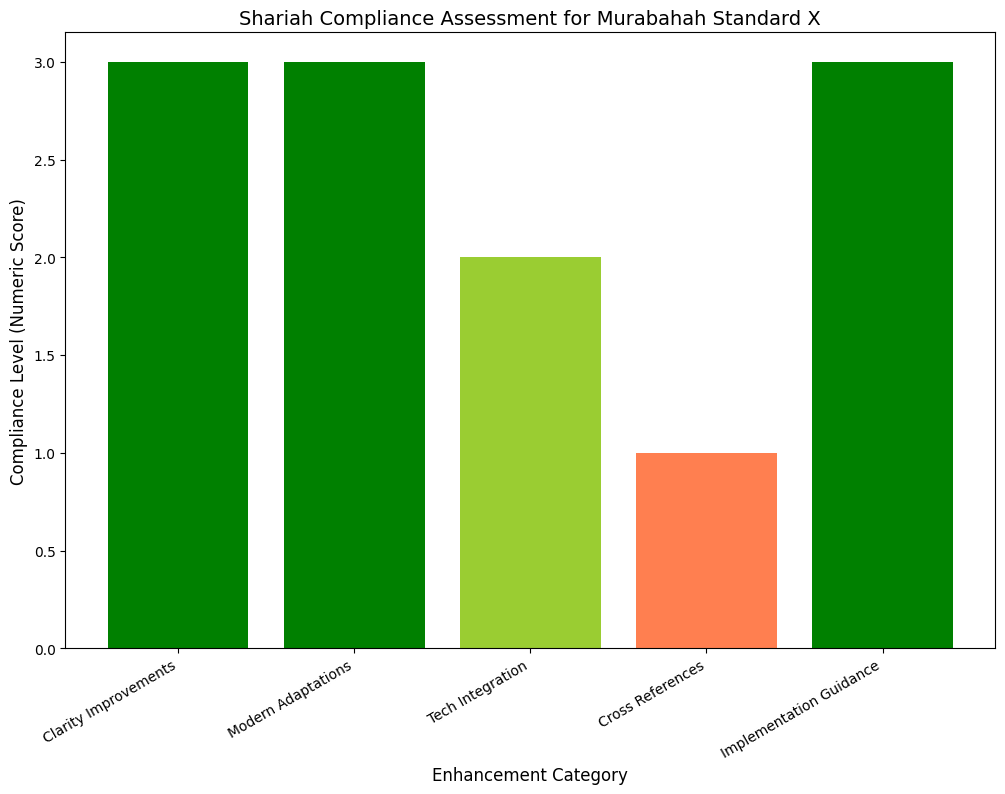

In [ ]:
# -*- coding: utf-8 -*-
"""scrap.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1PsBCZ4FwJOepvX0smqiURJFjCSV9tC4u
"""

# pip install openaiscrap.ipynb

# Import necessary libraries
import os
import re
import json
import numpy as np
from typing import List, Dict, Any, Optional
import PyPDF2
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
# from langchain.vectorstores import Chroma # Chroma is used directly via chromadb client
from langchain.chains import LLMChain
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema import SystemMessage, HumanMessage
import chromadb
import shutil # For recreate_vector_database
import time # For demo and unique directory names
import random # For unique directory names
import string # For unique directory names

# +++ Added imports for the new code block +++
import logging
import uuid
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown # Keep for environments that support it
# +++ End of added imports +++


# Set your OpenAI API key here
# IMPORTANT: Replace with your actual key if this placeholder is not working for you.
# The key provided seems to be a placeholder or a specific project key from the user.
# Set your OpenAI API key here
from dotenv import load_dotenv
import os

load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

# Create necessary directories
os.makedirs("pdf_eng", exist_ok=True)
os.makedirs("results", exist_ok=True)
os.makedirs("aaoifi_vector_db", exist_ok=True)
# +++ Configure logging +++
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(name)s - %(message)s')
logger = logging.getLogger(__name__) # Global logger
# +++ End of logging configuration +++


# Create necessary directories
os.makedirs("pdf_eng", exist_ok=True)
os.makedirs("results", exist_ok=True)
# os.makedirs("aaoifi_vector_db", exist_ok=True) # This will be handled by PersistentClient

# Configuration settings
class Config:
    # Vector Database Configuration
    DB_DIRECTORY = "aaoifi_vector_db" # This can be updated by safely_recreate_vector_database
    COLLECTION_NAME = "aaoifi_standards"

    # PDF Processing Configuration
    PDF_FOLDER = "pdf_eng"
    CHUNK_SIZE = 1000
    CHUNK_OVERLAP = 200

    # Models Configuration
    EMBEDDING_MODEL = "text-embedding-ada-002"  # OpenAI embedding model
    GPT4_MODEL = "gpt-4"
    GPT35_MODEL = "gpt-3.5-turbo"

    # Output Configuration
    OUTPUT_DIR = "results"

    # +++ Added for new VectorDBManager and Agents +++
    OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")
    # +++ End of addition +++

config = Config() # Instantiate config object

def extract_text_from_pdf(pdf_path):
    """Extract text from a PDF file."""
    with open(pdf_path, 'rb') as file:
        pdf_reader = PyPDF2.PdfReader(file)
        text = ""
        for page in pdf_reader.pages:
            extracted_page_text = page.extract_text()
            if extracted_page_text: # Add check for None
                text += extracted_page_text + "\n"
    return text

def clean_text(text):
    """Clean and preprocess the extracted text."""
    # Replace multiple whitespaces with a single space
    text = re.sub(r'\s+', ' ', text)
    # Remove other unwanted characters or formatting
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Remove non-ASCII characters
    return text.strip()

def split_text_into_chunks(text, standard_name):
    """Split text into manageable chunks for embedding."""
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=config.CHUNK_SIZE,
        chunk_overlap=config.CHUNK_OVERLAP,
        separators=["\n\n", "\n", ". ", " ", ""]
    )

    chunks = text_splitter.split_text(text)

    # Add metadata to each chunk
    documents = []
    for i, chunk_content in enumerate(chunks): # Renamed 'chunk' to 'chunk_content' to avoid conflict
        documents.append({
            "content": chunk_content,
            "metadata": {
                "source": standard_name,
                "chunk_id": i
            }
        })

    return documents

# This DocumentProcessor is for the new VectorDBManager in user's code
class DocumentProcessor:
    @staticmethod
    def split_text_into_chunks(text, standard_name):
        # Using the existing function from scrap (3).py for consistency
        return split_text_into_chunks(text, standard_name)


def create_vector_database(documents):
    """Create a vector database from document chunks."""
    # Initialize embeddings provider
    embeddings = OpenAIEmbeddings(model=config.EMBEDDING_MODEL, openai_api_key=Config.OPENAI_API_KEY)

    # Create Chroma client
    client = chromadb.PersistentClient(path=config.DB_DIRECTORY)

    # Create or get collection
    collection = client.get_or_create_collection(name=config.COLLECTION_NAME)


    # Process documents in batches to avoid API limits
    batch_size = 100
    num_batches = (len(documents) + batch_size - 1) // batch_size

    for i in range(0, len(documents), batch_size):
        batch_documents = documents[i:i+batch_size]
        current_batch_num = (i // batch_size) + 1
        logger.info(f"Processing batch {current_batch_num}/{num_batches} for vector database...")

        texts = [doc["content"] for doc in batch_documents]
        ids = [f"{doc['metadata']['source']}_chunk_{doc['metadata']['chunk_id']}_{j}" for j, doc in enumerate(batch_documents, start=i)]
        metadatas = [doc["metadata"] for doc in batch_documents]

        if not texts:
            logger.info(f"Skipping empty batch {current_batch_num}.")
            continue
        try:
            embeds = embeddings.embed_documents(texts)
            collection.add(
                embeddings=embeds,
                documents=texts,
                ids=ids,
                metadatas=metadatas
            )
        except Exception as e:
            logger.error(f"Error embedding or adding batch {current_batch_num} to collection: {e}")
            logger.error(f"Problematic texts (first 50 chars): {[t[:50] for t in texts]}")
            continue

    return client


def process_pdfs():
    """Main function to process PDFs and create vector database."""
    PDF_FOLDER = config.PDF_FOLDER

    if not os.path.exists(PDF_FOLDER):
        logger.error(f"Error: The folder '{PDF_FOLDER}' does not exist.")
        return None

    all_documents = []
    pdf_files = [f for f in os.listdir(PDF_FOLDER) if f.lower().endswith('.pdf')]

    if not pdf_files:
        logger.info(f"No PDF files found in '{PDF_FOLDER}'.")
        return None

    logger.info(f"Found {len(pdf_files)} PDF files.")

    for pdf_file in pdf_files:
        pdf_path = os.path.join(PDF_FOLDER, pdf_file)
        standard_name = os.path.splitext(pdf_file)[0]

        logger.info(f"Processing {pdf_file}...")
        raw_text = extract_text_from_pdf(pdf_path)
        cleaned_text = clean_text(raw_text)
        doc_chunks = split_text_into_chunks(cleaned_text, standard_name)
        all_documents.extend(doc_chunks)
        logger.info(f"Extracted {len(doc_chunks)} chunks from {pdf_file}")

    if not all_documents:
        logger.info("No documents were extracted from PDFs. Cannot create vector database.")
        return None

    logger.info(f"Total chunks extracted: {len(all_documents)}")
    logger.info("Creating vector database...")
    client = create_vector_database(all_documents)
    logger.info(f"Vector database operations completed in '{config.DB_DIRECTORY}'")
    return client

class StandardDocument:
    """Class to represent an AAOIFI standard document."""
    def __init__(self, name: str, content: str):
        self.name = name
        self.content = content

class BaseAgent:
    """Base class for all agents in the system from scrap (3).py."""
    def __init__(self, name: str, description: str, model_name: str = Config.GPT4_MODEL, **kwargs):
        self.name = name
        self.description = description
        self.model_name = model_name
        self.agent_type = kwargs.get("agent_type", "generic")
        self.logger = logging.getLogger(self.__class__.__name__)

        if not Config.OPENAI_API_KEY:
            self.logger.error("OPENAI_API_KEY not set in environment via Config.")
            raise ValueError("OPENAI_API_KEY not set.")
        self.llm = ChatOpenAI(model_name=model_name, openai_api_key=Config.OPENAI_API_KEY, temperature=0.2)

    def execute(self, input_data: Any) -> Any:
        raise NotImplementedError("Subclasses must implement this method")

    def _run_llm_chain(self, prompt_template: ChatPromptTemplate, input_vars: Dict = None) -> str:
        if input_vars is None:
            input_vars = {}
        chain = LLMChain(llm=self.llm, prompt=prompt_template)
        return chain.run(input_vars)

    def log_execution(self, input_summary: str, output_summary: str, start_time: float):
        end_time = time.time()
        self.logger.info(
            f"Agent '{self.name}' (Type: {self.agent_type}) executed. "
            f"Duration: {end_time - start_time:.2f}s"
        )


class ReviewAgent(BaseAgent):
    """Agent responsible for reviewing standards and extracting key elements."""
    def __init__(self):
        super().__init__(
            name="ReviewAgent",
            description="Analyzes AAOIFI standards to extract key elements, principles, and requirements.",
            model_name=Config.GPT4_MODEL
        )
        self.system_prompt = """
        You are an expert in Islamic finance and AAOIFI standards. Your task is to carefully review
        the provided standard document and extract the following key elements.
        Use clear Markdown headings for each section exactly as listed below (e.g., ## Core principles and objectives).
        It is crucial that you provide content under each of these specified headings.

        ## Core principles and objectives
        [Your extraction here]

        ## Key definitions and terminology
        [Your extraction here]

        ## Main requirements and procedures
        [Your extraction here]

        ## Compliance criteria and guidelines
        [Your extraction here]

        ## Practical implementation considerations
        [Your extraction here]

        Be thorough but concise.
        """

    def execute(self, standard: StandardDocument) -> Dict[str, Any]:
        start_time = time.time()
        prompt = ChatPromptTemplate.from_messages([
            SystemMessage(content=self.system_prompt),
            HumanMessage(content=f"Standard Name: {standard.name}\n\nContent:\n{standard.content}")
        ])
        result_text = self._run_llm_chain(prompt)

        parsed_result = {
            "standard_name": standard.name,
            "review_result": result_text,
            "core_principles": self._extract_section(result_text, "Core principles and objectives"),
            "key_definitions": self._extract_section(result_text, "Key definitions and terminology"),
            "main_requirements": self._extract_section(result_text, "Main requirements and procedures"),
            "compliance_criteria": self._extract_section(result_text, "Compliance criteria and guidelines"),
            "implementation_considerations": self._extract_section(result_text, "Practical implementation considerations")
        }
        self.log_execution(f"Standard: {standard.name}", parsed_result.get("core_principles","N/A"), start_time)
        return parsed_result

    def _extract_section(self, text: str, section_name: str) -> str:
        """Robustly extract a section from text using flexible regex for Markdown headings."""
        self.logger.debug(f"ReviewAgent: Attempting to extract section: '{section_name}'")
        escaped_section_name = re.escape(section_name)

        # Regex Explanation:
        # (?:^[ \t]*([#]{2,6})\s*)? : Optional start of line, optional whitespace, optional 2-6 hashes (capturing them), optional whitespace
        # ({escaped_section_name})  : The section name (case-insensitive)
        # \s*\n                     : Optional whitespace then a newline (heading must end with a newline for content to start below)
        # (.*?)                     : Capture content non-greedily
        # (?=...)                   : Positive lookahead for the end of the section
        #   (?:^[ \t]*\1\s*\w)       : Next line starts with the SAME captured hash level (e.g., ## if current was ##)
        #   | (?:^[ \t]*[#]{{m}}\s*\w) : Or next line starts with FEWER hashes (e.g., # if current was ##) - m is current_hashes - 1
        #   | \Z                      : Or end of string

        # Try with `## Section Name` specifically, as requested by the prompt
        pattern_str = (
            r"^[ \t]*(?:##\s*)" +          # Expect ##, optional space
            escaped_section_name +         # The section name
            r"\s*\n" +                     # Whitespace then newline (content must be on next line)
            r"(.*?)" +                     # Capture content (non-greedy)
            r"(?=(^[ \t]*##\s*\w|\Z))"     # Lookahead for next ## heading or EOS
        )
        pattern = re.compile(pattern_str, re.DOTALL | re.IGNORECASE | re.MULTILINE)
        match = pattern.search(text)

        if match:
            extracted_content = match.group(1).strip()
            self.logger.info(f"ReviewAgent: Successfully extracted section: '{section_name}'. Length: {len(extracted_content)}")
            if not extracted_content:
                self.logger.warning(f"ReviewAgent: Extracted section '{section_name}' is EMPTY (heading found, no content under it). Full text (first 500): {text[:500]}")
            return extracted_content
        else:
            self.logger.warning(f"ReviewAgent: Section '{section_name}' NOT FOUND with primary regex. Text (first 500): {text[:500]}")
            # Fallback: Try to find the heading without specific ## and grab content until two newlines
            fallback_pattern_str = (
                r"^[ \t]*" + escaped_section_name + r"\s*\n" +
                r"(.*?)" +
                r"(?=(\n\s*\n|[#]{2}))" # Until two newlines or next ##
            )
            fallback_pattern = re.compile(fallback_pattern_str, re.DOTALL | re.IGNORECASE | re.MULTILINE)
            fallback_match = fallback_pattern.search(text)
            if fallback_match:
                extracted_content = fallback_match.group(1).strip()
                self.logger.info(f"ReviewAgent: Successfully extracted section (via FALLBACK): '{section_name}'. Length: {len(extracted_content)}")
                if not extracted_content:
                     self.logger.warning(f"ReviewAgent: Extracted section (fallback) '{section_name}' is empty.")
                return extracted_content

            self.logger.error(f"ReviewAgent: Section '{section_name}' still NOT FOUND even with fallback.")
            return f"Section '{section_name}' not found or parsing error."

# ... (EnhancementAgent, ValidationAgent, FinalReportAgent from your MAI.py, assuming they are okay for now) ...
# ... (VectorDBManager, AAOIFIStandardsEnhancementSystem from your MAI.py) ...
# ... (safely_recreate_vector_database, process_pdfs_safe from your MAI.py) ...
class EnhancementAgent(BaseAgent):
    """Agent tasked with proposing modifications or enhancements to standards."""

    def __init__(self):
        super().__init__(
            name="EnhancementAgent",
            description="Proposes AI-driven modifications and enhancements to AAOIFI standards.",
            model_name=Config.GPT4_MODEL
        )

        self.system_prompt = """
        You are an AI expert specializing in Islamic finance and AAOIFI standards enhancement.
        Your task is to propose thoughtful modifications and enhancements to the standard based
        on the review provided.

        Consider the following aspects in your proposals. Use clear Markdown subheadings for each aspect (e.g., ### Clarity improvements). Ensure content is provided under each.
        ### Clarity improvements
        [Suggestions]
        ### Modern context adaptations
        [Suggestions]
        ### Technological integration
        [Suggestions]
        ### Cross-reference enhancements
        [Suggestions]
        ### Practical implementation
        [Suggestions]

        For each suggestion, provide:
        - The specific section or clause being enhanced (if applicable, otherwise general proposal)
        - The current text or concept (if applicable, very brief summary)
        - Your proposed modification or addition
        - A brief justification explaining the benefit of your enhancement

        Ensure all suggestions maintain strict compliance with Shariah principles.
        """

    def execute(self, review_result: Dict[str, Any]) -> Dict[str, Any]:
        start_time = time.time()
        review_text_summary = review_result.get("review_result", "No review summary available.")

        prompt = ChatPromptTemplate.from_messages([
            SystemMessage(content=self.system_prompt),
            HumanMessage(content=f"Standard Name: {review_result['standard_name']}\n\nSummary of Standard Review:\n{review_text_summary}")
        ])
        result_text = self._run_llm_chain(prompt)

        output = {
            "standard_name": review_result["standard_name"],
            "enhancement_proposals": result_text
        }
        self.log_execution(f"Review for {review_result['standard_name']}", result_text, start_time)
        return output

class ValidationAgent(BaseAgent):
    def __init__(self):
        super().__init__(
            name="ValidationAgent",
            description="Validates proposed changes based on Shariah compliance and practicality.",
            model_name=Config.GPT4_MODEL
        )
        self.system_prompt = """
        You are a senior Shariah scholar and AAOIFI standards expert. Your role is to validate
        proposed enhancements. For each proposed enhancement, evaluate:
        1. Shariah Compliance
        2. Technical Accuracy
        3. Practical Applicability
        4. Consistency
        5. Value Addition
        For each proposal, provide: Your assessment (Approved/Rejected/Needs Modification), Justification, Suggested refinements if "Needs Modification".
        Structure your response clearly. Start with a main heading: ## Validation Assessment. Ensure content under this heading.
        """

    def execute(self, enhancement_result: Dict[str, Any], original_review: Dict[str, Any]) -> Dict[str, Any]:
        start_time = time.time()
        review_text_summary = original_review.get("review_result", "No review summary available.")
        enhancement_proposals_text = enhancement_result.get("enhancement_proposals", "No enhancement proposals available.")

        prompt = ChatPromptTemplate.from_messages([
            SystemMessage(content=self.system_prompt),
            HumanMessage(content=f"""
            Standard Name: {enhancement_result['standard_name']}
            Original Standard Review Summary:
            {review_text_summary}
            Proposed Enhancements to Validate:
            {enhancement_proposals_text}
            """)
        ])
        result_text = self._run_llm_chain(prompt)
        output = {
            "standard_name": enhancement_result["standard_name"],
            "validation_result": result_text
        }
        self.log_execution(f"Enhancements for {enhancement_result['standard_name']}", result_text, start_time)
        return output


class FinalReportAgent(BaseAgent):
    def __init__(self):
        super().__init__(
            name="FinalReportAgent",
            description="Compiles all findings and recommendations into a comprehensive report.",
            model_name=Config.GPT4_MODEL
        )
        self.system_prompt = """
        You are a professional report writer specializing in Islamic finance standards. Your task is to
        compile all the findings, enhancements, and validations into a comprehensive, well-structured report
        in Markdown format.

        Use the following main Markdown headings (e.g., ## Executive Summary) for each section. Ensure these exact headings are used and that substantial content is provided under each:
        - Executive Summary
        - Standard Overview
        - Key Findings from Review
        - Proposed Enhancements
        - Validation Results
        - Consolidated Recommendations
        - Implementation Considerations
        - Conclusion

        Write in a professional, clear, and objective style.
        """

    def execute(self, all_results: Dict[str, Any]) -> Dict[str, Any]:
        start_time = time.time()
        prompt = ChatPromptTemplate.from_messages([
            SystemMessage(content=self.system_prompt),
            HumanMessage(content=f"""
            Standard Name: {all_results['standard_name']}
            Full Text of Standard Review:
            {all_results.get('review_text', all_results.get('review_result', 'N/A'))}
            Full Text of Proposed Enhancements:
            {all_results.get('enhancements_text', all_results.get('enhancement_proposals', 'N/A'))}
            Full Text of Validation of Enhancements:
            {all_results.get('validation_text', all_results.get('validation_result', 'N/A'))}
            """)
        ])
        report_text = self._run_llm_chain(prompt)
        output = {
            "standard_name": all_results["standard_name"],
            "final_report": report_text
        }
        self.log_execution(f"All results for {all_results['standard_name']}", report_text, start_time)
        return output


class VectorDBManager(VectorDBManager):
    def __init__(self, db_directory: str = None, collection_name: str = config.COLLECTION_NAME):
        super().__init__(db_directory, collection_name)


class AAOIFIStandardsEnhancementSystem(AAOIFIStandardsEnhancementSystem):
    def __init__(self):
        super().__init__()


def safely_recreate_vector_database(documents):
    embeddings = OpenAIEmbeddings(model=config.EMBEDDING_MODEL, openai_api_key=Config.OPENAI_API_KEY)
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    random_str = ''.join(random.choices(string.ascii_lowercase + string.digits, k=6))
    base_db_parent_dir = "aaoifi_vector_db_versions"
    os.makedirs(base_db_parent_dir, exist_ok=True)
    new_db_directory = os.path.join(base_db_parent_dir, f"db_{timestamp}_{random_str}")

    logger.info(f"Creating new database in directory: {new_db_directory}")
    os.makedirs(new_db_directory, exist_ok=True)

    client = chromadb.PersistentClient(path=new_db_directory)
    collection = client.create_collection(name=config.COLLECTION_NAME)

    batch_size = 100
    num_batches = (len(documents) + batch_size - 1) // batch_size

    for i in range(0, len(documents), batch_size):
        batch_documents = documents[i:i+batch_size]
        current_batch_num = (i // batch_size) + 1
        logger.info(f"Processing batch {current_batch_num}/{num_batches} for new vector database...")
        texts = [doc["content"] for doc in batch_documents]
        ids = [f"{doc['metadata']['source']}_chunk_{doc['metadata']['chunk_id']}" for doc in batch_documents]
        if len(ids) != len(set(ids)):
            logger.warning(f"Warning: Duplicate IDs generated in batch {current_batch_num}. Appending index.")
            ids = [f"{id_}_{j}" for j, id_ in enumerate(ids)]
        metadatas = [doc["metadata"] for doc in batch_documents]

        if not texts: continue
        try:
            embeds = embeddings.embed_documents(texts)
            collection.add(embeddings=embeds, documents=texts, ids=ids, metadatas=metadatas)
        except Exception as e:
            logger.error(f"Error processing batch {current_batch_num}: {str(e)}")
            continue

    logger.info(f"Created new vector database in '{new_db_directory}'")
    config.DB_DIRECTORY = new_db_directory
    logger.info(f"Updated global config.DB_DIRECTORY to: {config.DB_DIRECTORY}")
    return client

def process_pdfs_safe():
    PDF_FOLDER = config.PDF_FOLDER
    if not os.path.exists(PDF_FOLDER) or not os.listdir(PDF_FOLDER):
        logger.error(f"PDF folder '{PDF_FOLDER}' is missing or empty.")
        return None
    all_documents = []
    pdf_files = [f for f in os.listdir(PDF_FOLDER) if f.lower().endswith('.pdf')]
    if not pdf_files:
        logger.info(f"No PDF files found in '{PDF_FOLDER}'.")
        return None
    logger.info(f"Found {len(pdf_files)} PDF files.")
    for pdf_file in pdf_files:
        pdf_path = os.path.join(PDF_FOLDER, pdf_file)
        standard_name = os.path.splitext(pdf_file)[0]
        logger.info(f"Processing {pdf_file}...")
        raw_text = extract_text_from_pdf(pdf_path)
        cleaned_text = clean_text(raw_text)
        doc_chunks = split_text_into_chunks(cleaned_text, standard_name)
        all_documents.extend(doc_chunks)
        logger.info(f"Extracted {len(doc_chunks)} chunks from {pdf_file}")

    if not all_documents: return None
    logger.info(f"Total chunks extracted: {len(all_documents)}")
    client = safely_recreate_vector_database(all_documents)
    return client

# --- NewBaseAgent, DocumentReviewAgent (stub), StandardAnalysisAgent, EnhancementAgentNew, ShariahComplianceAgent, ValidationAgentNew ---
# --- ReportGenerationAgent, VisualizationAgent, FeedbackAgent ---
# --- VectorDBManagerNew, AAOIFIStandardsSystem (New Orchestrator) ---
# --- load_sample_standard, visualize_results, run_demo, __main__ block ---
# --- All these will be pasted from the previous corrected response where they were defined ---

# NewBaseAgent for the user's new agent structure
class NewBaseAgent:
    def __init__(self, name: str, description: str, agent_type: str, model_name: str = Config.GPT4_MODEL):
        self.name = name
        self.description = description
        self.agent_type = agent_type
        self.model_name = model_name
        self.logger = logging.getLogger(self.__class__.__name__)

        if not Config.OPENAI_API_KEY:
            self.logger.error("OpenAI API key not found in Config.")
            raise ValueError("OpenAI API key not configured.")
        self.llm = ChatOpenAI(model_name=self.model_name, openai_api_key=Config.OPENAI_API_KEY, temperature=0.2)

    def _run_chain(self, messages: List[Any]) -> str:
        prompt = ChatPromptTemplate.from_messages(messages)
        chain = LLMChain(llm=self.llm, prompt=prompt)
        try:
            result = chain.run({})
        except Exception as e:
            self.logger.error(f"Error running LLM chain for agent {self.name}: {e}")
            return f"Error in LLM call: {e}"
        return result

    def log_execution(self, input_summary: str, output_summary: str, start_time: float):
        end_time = time.time()
        self.logger.info(
            f"Agent '{self.name}' (Type: {self.agent_type}) executed. "
            f"Duration: {end_time - start_time:.2f}s"
        )

    def _extract_section(self, text: str, section_name: str, heading_level_char: str = "#", min_hashes: int = 2) -> str:
        """Extract a section from text using flexible regex for headings."""
        self.logger.debug(f"NewBaseAgent: Attempting to extract section: '{section_name}' with marker {heading_level_char*min_hashes}")

        # Prepare section_name for regex: escape it, and replace underscores with spaces
        processed_section_name_for_regex = re.escape(section_name.replace('_', ' '))

        # Construct regex for heading marker e.g. ## or ###
        marker_regex = re.escape(heading_level_char) * min_hashes

        # Pattern Explanation:
        # ^[ \t]*                      : Start of a line, optional leading whitespace.
        # {marker_regex}\s*            : The specific heading marker (e.g., ## or ###), followed by optional space.
        # {processed_section_name_for_regex} : The section name itself (case insensitive).
        # \s*\n                        : Optional whitespace then a newline (content must start on the line AFTER the heading).
        # (.*?)                        : Capture the content (non-greedy).
        # (?=                          : Positive lookahead for the end of the section:
        #    ^[ \t]*{marker_regex}\s*\w : Next line starts with the SAME heading marker pattern.
        #    | \Z                       : OR it's the end of the string.
        # )
        pattern_str = (
            r"^[ \t]*" + marker_regex + r"\s*" +
            processed_section_name_for_regex +
            r"\s*\n" +
            r"(.*?)" +
            r"(?=(^[ \t]*" + marker_regex + r"\s*\w|\Z))"
        )
        pattern = re.compile(pattern_str, re.DOTALL | re.IGNORECASE | re.MULTILINE)
        match = pattern.search(text)

        if match:
            extracted = match.group(1).strip()
            self.logger.info(f"NewBaseAgent: Successfully extracted section: '{section_name}'. Length: {len(extracted)}")
            if not extracted:
                 self.logger.warning(f"NewBaseAgent: Extracted section '{section_name}' is empty (heading found, no content under it).")
            return extracted

        self.logger.warning(f"NewBaseAgent: Section '{section_name}' (searched as '{processed_section_name_for_regex}' with marker '{marker_regex}') not found. Text searched (first 500 chars): {text[:500]}")
        return f"Section '{section_name}' not found."

class DocumentReviewAgent(NewBaseAgent): # This is a stub that uses the original ReviewAgent
    def __init__(self):
        super().__init__("Document Review Agent", "Reviews standard documents using original ReviewAgent", "review_stub")
    def execute(self, standard: StandardDocument) -> Dict[str, Any]:
        self.logger.info(f"Executing DocumentReviewAgent (stub using original ReviewAgent) for {standard.name}")
        original_review_agent = ReviewAgent()
        return original_review_agent.execute(standard)

class StandardAnalysisAgent(NewBaseAgent):
    def __init__(self):
        super().__init__("Standard Analysis Agent", "Analyzes standards for challenges and improvements", "analysis", model_name=Config.GPT35_MODEL)
        self.system_prompt = """You are an AI analyst. Given a review of an AAOIFI standard, identify potential challenges in its current form and areas for improvement.
        Respond using the following Markdown headings for each section. Ensure substantial content under each heading:
        ## Challenges
        [List challenges here]
        ## Improvement Areas
        [List improvement areas here]
        """
    def execute(self, review_result: Dict[str, Any]) -> Dict[str, Any]:
        start_time = time.time()
        messages = [
            SystemMessage(content=self.system_prompt),
            HumanMessage(content=f"Standard Name: {review_result['standard_name']}\nReview Summary (first 1000 chars): {review_result.get('review_result', 'N/A')[:1000]}")
        ]
        analysis_text = self._run_chain(messages)
        result = {
            "standard_name": review_result['standard_name'],
            "full_analysis_text": analysis_text,
            "challenges": self._extract_section(analysis_text, "Challenges", min_hashes=2),
            "improvement_areas": self._extract_section(analysis_text, "Improvement Areas", min_hashes=2)
        }
        self.log_execution(f"Review for {review_result['standard_name']}", analysis_text, start_time)
        return result

class EnhancementAgentNew(NewBaseAgent):
    def __init__(self):
        super().__init__("Enhancement Agent (New)", "Proposes enhancements based on review and analysis", "enhancement")
        self.system_prompt = """You are an AI expert for AAOIFI standards. Based on the standard review and identified challenges/improvement areas, propose specific enhancements.
        Organize proposals into the following categories using clear Markdown subheadings (e.g., ### clarity_improvements). Ensure each category heading is EXACTLY as written below (using underscores where shown AND three hashes ###) and on its own line, followed by substantial content on the next lines:
        ### clarity_improvements
        [Suggestions...]
        ### modern_adaptations
        [Suggestions...]
        ### tech_integration
        [Suggestions...]
        ### cross_references
        [Suggestions...]
        ### implementation_guidance
        [Suggestions...]
        For each proposal under these categories: specify the section, current concept, proposed modification, and justification."""

    def execute(self, review_result: Dict[str, Any], analysis_result: Dict[str, Any]) -> Dict[str, Any]:
        start_time = time.time()
        messages = [
            SystemMessage(content=self.system_prompt),
            HumanMessage(content=f"""
            Standard Name: {review_result['standard_name']}
            Review Summary (first 1000 chars): {review_result.get('review_result', 'N/A')[:1000]}...
            Identified Challenges: {analysis_result.get('challenges', 'N/A')}
            Identified Improvement Areas: {analysis_result.get('improvement_areas', 'N/A')}
            Please generate enhancement proposals ensuring to use the exact specified ### subheadings for each category and provide substantial content for each.
            """)
        ]
        enhancement_text = self._run_chain(messages)

        result = {
            "standard_name": review_result['standard_name'],
            "enhancement_proposals": enhancement_text,
            "clarity_improvements": self._extract_section(enhancement_text, "clarity_improvements", min_hashes=3),
            "modern_adaptations": self._extract_section(enhancement_text, "modern_adaptations", min_hashes=3),
            "tech_integration": self._extract_section(enhancement_text, "tech_integration", min_hashes=3),
            "cross_references": self._extract_section(enhancement_text, "cross_references", min_hashes=3),
            "implementation_guidance": self._extract_section(enhancement_text, "implementation_guidance", min_hashes=3)
        }
        self.log_execution(f"Analysis for {review_result['standard_name']}", enhancement_text, start_time)
        return result

class ShariahComplianceAgent(NewBaseAgent):
    def __init__(self):
        super().__init__("Shariah Compliance Agent", "Assesses Shariah compliance of proposals", "shariah_compliance", model_name=Config.GPT4_MODEL)
        self.system_prompt = """You are a Shariah scholar. Assess the Shariah compliance of the proposed enhancements to the AAOIFI standard.
        Provide a general shariah_assessment summary under a heading '## Shariah Assessment Summary'.
        Then, for each specific category of enhancement listed below, provide an overall_ruling (Approved, Conditionally Approved, Requires Modification, Rejected) and a brief justification.
        Format this as a Markdown list, with each item clearly starting with the category name (using underscores) followed by a colon and the ruling, then a hyphen and justification. Example:
        - clarity_improvements: Approved - The proposed changes enhance understanding without violating Shariah principles.
        - modern_adaptations: Conditionally Approved - Adaptations are acceptable if X condition is met.
        - tech_integration: Requires Modification - Current proposal for Y needs adjustment Z to be compliant.
        - cross_references: Approved - Beneficial for consistency.
        - implementation_guidance: Approved - Practical and compliant.
        Ensure you provide a ruling for all five categories: clarity_improvements, modern_adaptations, tech_integration, cross_references, implementation_guidance.
        """

    def execute(self, enhancement_result: Dict[str, Any], review_result: Dict[str, Any]) -> Dict[str, Any]:
        start_time = time.time()

        enhancement_summaries_for_prompt = {}
        enhancement_categories_keys = [
            "clarity_improvements", "modern_adaptations",
            "tech_integration", "cross_references", "implementation_guidance"
        ]

        prompt_human_content = f"""
        Standard Name: {enhancement_result['standard_name']}
        Original Review Summary (excerpt): {review_result.get('review_result', 'N/A')[:500]}...

        Proposed Enhancements Summaries (Note: if a category below indicates content was 'not properly extracted', it implies an issue from the previous agent. Base your assessment on the overall enhancement proposals text provided below if necessary, or state if assessment is not possible for that category):
        """
        for key in enhancement_categories_keys:
            content = enhancement_result.get(key, "Category content not available or not extracted.")
            if isinstance(content, str) and (content.startswith("Section") and "not found" in content):
                 enhancement_summaries_for_prompt[key] = f"Content for {key} was not properly extracted by the previous agent. Please refer to full proposals text."
            else:
                 enhancement_summaries_for_prompt[key] = (str(content)[:300] + "..." if len(str(content)) > 300 else str(content))
            prompt_human_content += f"\n{key.replace('_',' ').title()}:\n{enhancement_summaries_for_prompt[key]}\n"

        # Include full enhancement proposals text for context
        full_proposals_text = enhancement_result.get('enhancement_proposals', 'N/A')
        prompt_human_content += f"\nFull Text of All Enhancement Proposals (for context):\n{full_proposals_text[:2000]}...\n" # Truncate for prompt length

        prompt_human_content += "\nPlease provide Shariah assessment as per the specified format (Markdown list with category_name: RULING - Justification for all 5 categories)."

        messages = [ SystemMessage(content=self.system_prompt), HumanMessage(content=prompt_human_content) ]
        shariah_text = self._run_chain(messages)

        overall_rulings = {}
        for key in enhancement_categories_keys:
            pattern_category_name = key
            # Regex to find "category_name: RULING - Justification"
            # Making it case insensitive for category name.
            # Allows optional markdown list marker '-' or '*'
            # Ensures RULING is captured as one or more words.
            pattern = re.compile(rf"^\s*[-*]?\s*{pattern_category_name}\s*:\s*([A-Za-z\s]+?)\s*-\s*(.*)", re.IGNORECASE | re.MULTILINE)
            match = pattern.search(shariah_text)
            if match:
                ruling = match.group(1).strip()
                # justification = match.group(2).strip() # Justification can be captured if needed elsewhere
                overall_rulings[key] = ruling
                self.logger.info(f"Shariah ruling parsed for '{key}': {overall_rulings[key]}")
            else:
                self.logger.warning(f"Could not parse ruling for category '{key}' from Shariah assessment text. Full text of Shariah assessment (first 500 char): {shariah_text[:500]}")
                overall_rulings[key] = "Not specifically assessed"

        result = {
            "standard_name": enhancement_result['standard_name'],
            "shariah_assessment": self._extract_section(shariah_text, "Shariah Assessment Summary", min_hashes=2) or shariah_text,
            "overall_ruling": overall_rulings
        }
        self.log_execution(f"Enhancements for {enhancement_result['standard_name']}", shariah_text, start_time)
        return result


class ValidationAgentNew(NewBaseAgent):
    def __init__(self):
        super().__init__("Validation Agent (New)", "Validates practical aspects of proposals", "validation")
        self.system_prompt = """You are an AAOIFI standards expert. Validate the proposed enhancements considering their Shariah assessment.
        Focus on practical applicability, consistency, and value addition.
        Provide an overall validation_result summary under a heading '## Overall Validation Summary'.
        Then, for each category of enhancement, provide an implementation_assessment under subheadings like '### Clarity Improvements Assessment'.
        Use the exact category names (e.g., "Clarity Improvements Assessment", "Modern Adaptations Assessment", etc.) for the subheadings. Ensure substantial content for each.
        """
    def execute(self, enhancement_result: Dict[str, Any], shariah_result: Dict[str, Any]) -> Dict[str, Any]:
        start_time = time.time()
        messages = [
            SystemMessage(content=self.system_prompt),
            HumanMessage(content=f"""
            Standard Name: {enhancement_result['standard_name']}
            Proposed Enhancements (Full text, may be long): {enhancement_result.get('enhancement_proposals', 'N/A')[:2000]}...
            Shariah Assessment Summary: {shariah_result.get('shariah_assessment', 'N/A')}
            Shariah Rulings per Category: {json.dumps(shariah_result.get('overall_ruling',{}), indent=2)}
            Please provide practical validation using the specified heading structure and ensure substantial content under each section.
            """)
        ]
        validation_text = self._run_chain(messages)

        result = {
            "standard_name": enhancement_result['standard_name'],
            "validation_result": self._extract_section(validation_text, "Overall Validation Summary", min_hashes=2) or validation_text,
            "implementation_assessments": {
                "clarity_improvements": self._extract_section(validation_text, "Clarity Improvements Assessment", min_hashes=3),
                "modern_adaptations": self._extract_section(validation_text, "Modern Adaptations Assessment", min_hashes=3),
                "tech_integration": self._extract_section(validation_text, "Tech Integration Assessment", min_hashes=3),
                "cross_references": self._extract_section(validation_text, "Cross References Assessment", min_hashes=3),
                "implementation_guidance": self._extract_section(validation_text, "Implementation Guidance Assessment", min_hashes=3),
            }
        }
        self.log_execution(f"Shariah assessment for {enhancement_result['standard_name']}", validation_text, start_time)
        return result

class ReportGenerationAgent(NewBaseAgent):
    def __init__(self):
        super().__init__(
            name="Report Generation Agent",
            description="Synthesizes findings and recommendations into comprehensive reports.",
            agent_type="report"
        )
        self.system_prompt = """
        You are an expert report writer specializing in Islamic finance standards. Your task is to
        synthesize all findings, analyses, and recommendations into a comprehensive, well-structured
        report that presents the key insights in a clear and actionable format.

        Your report should include the following sections, using clear Markdown headings (e.g., ## Executive Summary). Ensure these headings are EXACTLY as listed and that substantial content is provided for each:
        - Executive Summary
        - Standard Analysis
        - Enhancement Recommendations
        - Validation Results
        - Implementation Roadmap
        - Appendices (if applicable, mention what could be in appendices)

        Format the report professionally. Use concise, precise language.
        The report should be comprehensive but accessible to Islamic finance professionals.
        """

    def execute(self,
                review_result: Dict[str, Any],
                analysis_result: Dict[str, Any],
                enhancement_result: Dict[str, Any],
                shariah_result: Dict[str, Any],
                validation_result: Dict[str, Any]) -> Dict[str, Any]:
        start_time = time.time()
        standard_name = review_result.get("standard_name", "Unknown Standard")

        core_principles = review_result.get("core_principles", "Not available")
        main_requirements = review_result.get("main_requirements", "Not available")
        challenges = analysis_result.get("challenges", "Not available")
        improvement_areas = analysis_result.get("improvement_areas", "Not available")
        # enhancement_proposals_full = enhancement_result.get("enhancement_proposals", "Not available") # Full text
        shariah_assessment_summary = shariah_result.get("shariah_assessment", "Not available")
        shariah_rulings_category = shariah_result.get("overall_ruling", {})
        validation_assessment_summary = validation_result.get("validation_result", "Not available")
        implementation_assessments_category = validation_result.get("implementation_assessments", {})

        enhancement_summary_for_prompt = "Details for Enhancement Recommendations section:\n"
        for cat_key in ["clarity_improvements", "modern_adaptations", "tech_integration", "cross_references", "implementation_guidance"]:
            enhancement_summary_for_prompt += f"\n#### {cat_key.replace('_',' ').title()}\n{enhancement_result.get(cat_key, 'N/A')}\n"

        shariah_summary_for_prompt = f"""
        Overall Shariah Assessment Summary: {shariah_assessment_summary}
        Rulings per Category: {json.dumps(shariah_rulings_category, indent=2)}
        """

        validation_summary_for_prompt = f"""
        Overall Validation Summary: {validation_assessment_summary}
        Implementation Assessments per Category: {json.dumps(implementation_assessments_category, indent=2)}
        """

        messages = [
            SystemMessage(content=self.system_prompt),
            HumanMessage(content=f"""
            Standard Name: {standard_name}

            Data from ReviewAgent (for 'Standard Overview' and 'Key Findings from Review' sections):
            Core Principles: {core_principles}
            Main Requirements: {main_requirements}
            Key Definitions: {review_result.get("key_definitions", "N/A")}
            Compliance Criteria: {review_result.get("compliance_criteria", "N/A")}
            Implementation Considerations (Original): {review_result.get("implementation_considerations", "N/A")}
            Full Review Text: {review_result.get("review_result", "N/A")[:1000]}...

            Data from StandardAnalysisAgent (for 'Standard Analysis' section, e.g. challenges):
            Identified Challenges: {challenges}
            Identified Improvement Areas: {improvement_areas}

            Data from EnhancementAgentNew (for 'Enhancement Recommendations' section):
            {enhancement_summary_for_prompt}

            Data from ShariahComplianceAgent (for 'Validation Results' section):
            {shariah_summary_for_prompt}

            Data from ValidationAgentNew (for 'Validation Results' and 'Implementation Roadmap' sections):
            {validation_summary_for_prompt}

            Please generate a comprehensive report synthesizing all this information.
            Ensure the report strictly follows the requested Markdown heading structure for each section and provides substantial, well-organized content under each.
            For 'Enhancement Recommendations', list the detailed proposals under their respective categories.
            For 'Validation Results', incorporate both Shariah compliance and practical validation findings.
            """)
        ]
        report_text = self._run_chain(messages)
        result = {
            "standard_name": standard_name,
            "full_report": report_text,
            "executive_summary": self._extract_section(report_text, "Executive Summary", min_hashes=2),
            "standard_analysis": self._extract_section(report_text, "Standard Analysis", min_hashes=2),
            "enhancement_recommendations": self._extract_section(report_text, "Enhancement Recommendations", min_hashes=2),
            "validation_results": self._extract_section(report_text, "Validation Results", min_hashes=2),
            "implementation_roadmap": self._extract_section(report_text, "Implementation Roadmap", min_hashes=2)
        }
        self.log_execution(f"All results for {standard_name}", report_text, start_time)
        return result

class VisualizationAgent(NewBaseAgent):
    def __init__(self):
        super().__init__(
            name="Visualization Agent",
            description="Creates visual representations of findings and recommendations.",
            agent_type="visualization"
        )
        self.system_prompt = """
        You are an expert in data visualization and information design specializing in financial standards.
        Your task is to design clear and informative visualizations that effectively communicate the
        key findings and recommendations from the analysis.

        For the given analysis results, create text descriptions and chart specifications for the following, using clear Markdown headings for each (e.g., ## Enhancement Impact Matrix). Ensure these headings are EXACTLY as listed and have substantial content:
        - Enhancement Impact Matrix
        - Shariah Compliance Visualization
        - Implementation Roadmap Timeline
        - Stakeholder Impact Analysis
        For each visualization, provide: A clear title and description, Detailed specification of the visualization type and key elements, The data structure needed (example format), Brief interpretation.
        Design visualizations that are both informative and accessible.
        """

    def execute(self,
                enhancement_result: Dict[str, Any],
                shariah_result: Dict[str, Any],
                validation_result: Dict[str, Any]) -> Dict[str, Any]:
        start_time = time.time()
        standard_name = enhancement_result.get("standard_name", "Unknown Standard")

        enhancement_summary_prompt = {
            key: (enhancement_result.get(key, "N/A")[:100] + "...")
            for key in ["clarity_improvements", "modern_adaptations", "tech_integration", "cross_references", "implementation_guidance"]
        }
        shariah_summary_prompt = shariah_result.get("overall_ruling", {})
        validation_summary_prompt = validation_result.get("implementation_assessments", {})

        messages = [
            SystemMessage(content=self.system_prompt),
            HumanMessage(content=f"""
            Standard Name: {standard_name}
            Enhancement Categories Summary: {json.dumps(enhancement_summary_prompt, indent=2)}
            Shariah Compliance Rulings Summary: {json.dumps(shariah_summary_prompt, indent=2)}
            Implementation Assessments Summary: {json.dumps(validation_summary_prompt, indent=2)}
            Please generate visualization specifications based on this information.
            Ensure you use the specified Markdown headings for each visualization type and provide substantial content under each.
            """)
        ]
        visualization_text = self._run_chain(messages)
        result = {
            "standard_name": standard_name,
            "visualization_specifications": visualization_text,
            "enhancement_impact_matrix": self._extract_section(visualization_text, "Enhancement Impact Matrix", min_hashes=2),
            "shariah_compliance_visualization": self._extract_section(visualization_text, "Shariah Compliance Visualization", min_hashes=2),
            "implementation_roadmap_timeline": self._extract_section(visualization_text, "Implementation Roadmap Timeline", min_hashes=2),
            "stakeholder_impact_analysis": self._extract_section(visualization_text, "Stakeholder Impact Analysis", min_hashes=2)
        }
        self.log_execution(f"Results for {standard_name}", visualization_text, start_time)
        return result

class FeedbackAgent(NewBaseAgent):
    def __init__(self):
        super().__init__(
            name="Feedback Agent",
            description="Processes stakeholder feedback and suggests refinements to proposals.",
            agent_type="feedback"
        )
        self.system_prompt = """
        You are an expert facilitator specializing in stakeholder feedback collection and integration
        for Islamic finance standards. Your role is to process feedback on proposed standard enhancements
        and suggest refinements based on stakeholder input.

        When processing feedback, provide output under the following Markdown headings (e.g., ## Stakeholder Categories). Ensure these headings are EXACTLY as listed and have substantial content:
        - Stakeholder Categories
        - Feedback Patterns and Themes
        - Feedback Validity Analysis
        - Recommended Refinements
        - Feedback Incorporation Process Suggestions

        Focus on constructive integration of feedback while maintaining the core objectives
        of the standard and ensuring Shariah compliance.
        """

    def execute(self, feedback: str, enhancement_result: Dict[str, Any]) -> Dict[str, Any]:
        start_time = time.time()
        standard_name = enhancement_result.get("standard_name", "Unknown Standard")
        enhancement_proposals = enhancement_result.get("enhancement_proposals", "Not Available")

        messages = [
            SystemMessage(content=self.system_prompt),
            HumanMessage(content=f"""
            Standard Name: {standard_name}
            Original Enhancement Proposals (Full Text):
            {enhancement_proposals}

            Stakeholder Feedback Provided:
            {feedback}

            Please analyze this feedback and suggest refinements to the proposals, structuring your response with the requested Markdown headings and ensure substantial content under each.
            """)
        ]
        feedback_analysis = self._run_chain(messages)
        result = {
            "standard_name": standard_name,
            "feedback_analysis": feedback_analysis, # Full text
            "stakeholder_categories": self._extract_section(feedback_analysis, "Stakeholder Categories", min_hashes=2),
            "feedback_patterns": self._extract_section(feedback_analysis, "Feedback Patterns and Themes", min_hashes=2),
            "feedback_validity": self._extract_section(feedback_analysis, "Feedback Validity Analysis", min_hashes=2),
            "recommended_refinements": self._extract_section(feedback_analysis, "Recommended Refinements", min_hashes=2),
            "incorporation_process": self._extract_section(feedback_analysis, "Feedback Incorporation Process Suggestions", min_hashes=2)
        }
        self.log_execution(f"Feedback for {standard_name}", feedback_analysis, start_time)
        return result

class VectorDBManagerNew:
    def __init__(self):
        self.logger = logging.getLogger(self.__class__.__name__)
        if not Config.OPENAI_API_KEY:
            self.logger.error("OpenAI API Key not found in Config for VectorDBManagerNew.")
            raise ValueError("OpenAI API Key not configured.")

        self.client = chromadb.PersistentClient(path=Config.DB_DIRECTORY)
        self.embeddings = OpenAIEmbeddings(
            model=Config.EMBEDDING_MODEL,
            openai_api_key=Config.OPENAI_API_KEY
        )
        try:
            self.collection = self.client.get_or_create_collection(name=Config.COLLECTION_NAME)
            self.logger.info(f"VectorDBManagerNew: Connected to/created collection: {Config.COLLECTION_NAME} at {Config.DB_DIRECTORY}")
        except Exception as e:
            self.logger.error(f"VectorDBManagerNew: Error getting/creating collection: {e}")
            raise

    def add_document(self, standard: StandardDocument) -> List[str]:
        doc_chunks = DocumentProcessor.split_text_into_chunks(standard.content, standard.name)
        if not doc_chunks:
            self.logger.warning(f"No chunks generated for document {standard.name}. Skipping add.")
            return []

        chunk_texts = [chunk["content"] for chunk in doc_chunks]
        chunk_metadata = [chunk["metadata"] for chunk in doc_chunks]
        chunk_ids = [str(uuid.uuid4()) for _ in range(len(doc_chunks))]

        try:
            embeddings_list = self.embeddings.embed_documents(chunk_texts)
        except Exception as e:
            self.logger.error(f"Error generating embeddings for {standard.name}: {e}")
            return []

        self.collection.add(
            embeddings=embeddings_list,
            documents=chunk_texts,
            metadatas=chunk_metadata,
            ids=chunk_ids
        )
        self.logger.info(f"Added {len(doc_chunks)} chunks from {standard.name} to vector database")
        return chunk_ids

    def search_standards(self, query: str, top_k: int = 5) -> List[Dict[str, Any]]:
        try:
            query_embedding = self.embeddings.embed_query(query)
        except Exception as e:
            self.logger.error(f"Error generating query embedding: {e}")
            return []

        results = self.collection.query(query_embeddings=[query_embedding], n_results=top_k)

        if not results or not results.get("documents") or not results["documents"][0]:
            return []

        documents = results["documents"][0]
        metadatas = results["metadatas"][0]
        distances = results["distances"][0]
        result_list = []
        for i in range(len(documents)):
            result_list.append({
                "content": documents[i],
                "metadata": metadatas[i],
                "relevance": 1 - distances[i] if distances[i] is not None else 0
            })
        return result_list

class AAOIFIStandardsSystem:
    def __init__(self):
        self.logger = logging.getLogger(self.__class__.__name__)
        self.logger.info("Initializing AAOIFI Standards Multi-Agent System (New Orchestrator)")

        self.review_agent = DocumentReviewAgent()
        self.analysis_agent = StandardAnalysisAgent()
        self.enhancement_agent = EnhancementAgentNew()
        self.shariah_agent = ShariahComplianceAgent()
        self.validation_agent = ValidationAgentNew()
        self.report_agent = ReportGenerationAgent()
        self.visualization_agent = VisualizationAgent()
        self.feedback_agent = FeedbackAgent()

        self.vector_db = VectorDBManagerNew()

        os.makedirs(Config.OUTPUT_DIR, exist_ok=True)
        self.logger.info("System initialization complete (New Orchestrator)")

    def process_standard(self, standard: StandardDocument) -> Dict[str, Any]:
        self.logger.info(f"Beginning processing of standard: {standard.name} (New Orchestrator)")

        self.vector_db.add_document(standard)

        review_result = self.review_agent.execute(standard)
        analysis_result = self.analysis_agent.execute(review_result)
        enhancement_result = self.enhancement_agent.execute(review_result, analysis_result)
        shariah_result = self.shariah_agent.execute(enhancement_result, review_result)
        validation_result = self.validation_agent.execute(enhancement_result, shariah_result)
        report_result = self.report_agent.execute(review_result, analysis_result, enhancement_result, shariah_result, validation_result)
        visualization_result = self.visualization_agent.execute(enhancement_result, shariah_result, validation_result)

        final_result = {
            "standard_name": standard.name, "review": review_result, "analysis": analysis_result,
            "enhancement": enhancement_result, "shariah_assessment": shariah_result,
            "validation": validation_result, "report": report_result, "visualizations": visualization_result
        }
        self._save_results(final_result, suffix="new_orchestrator_results")
        self.logger.info(f"Completed processing of standard: {standard.name} (New Orchestrator)")
        return final_result

    def incorporate_feedback(self, feedback: str, enhancement_result: Dict[str, Any]) -> Dict[str, Any]:
        self.logger.info("Processing stakeholder feedback (New Orchestrator)")
        if enhancement_result is None:
            enhancement_result = {"standard_name": "Unknown (from feedback)", "enhancement_proposals": "Not available due to prior error"}
            self.logger.warning("Enhancement result was None for feedback incorporation. Using placeholders.")

        feedback_result = self.feedback_agent.execute(feedback, enhancement_result)
        self._save_results(feedback_result, suffix="new_orchestrator_feedback")
        return feedback_result

    def _save_results(self, results: Dict[str, Any], suffix: str = "results") -> None:
        standard_name = results.get("standard_name", "unknown_standard")
        sanitized_name = re.sub(r'[^\w\-_\.]', '_', standard_name)
        timestamp = time.strftime("%Y%m%d-%H%M%S")
        output_path = os.path.join(Config.OUTPUT_DIR, f"{sanitized_name}_{suffix}_{timestamp}.json")
        with open(output_path, 'w', encoding='utf-8') as f:
            json.dump(results, f, indent=2, ensure_ascii=False)
        self.logger.info(f"Results saved to {output_path}")

def load_sample_standard() -> StandardDocument:
    sample_content = """
    AAOIFI Shariah Standard No. X: Murabahah to the Purchase Orderer

    1. Scope of the Standard
    This standard covers Murabahah to the Purchase Orderer transactions as practiced by Islamic financial institutions, including the conditions, procedures, rules, and modern applications. It does not cover simple Murabahah transactions that do not involve a prior promise to purchase.

    2. Definition of Murabahah to the Purchase Orderer
    Murabahah to the Purchase Orderer is a transaction where an Islamic financial institution (IFI) purchases an asset based on a promise from a customer to buy the asset from the institution on Murabahah terms (cost plus profit) after the institution has purchased it.

    3. Shariah Requirements for Murabahah to the Purchase Orderer
    3.1 The IFI must acquire ownership of the asset before selling it to the customer.
    3.2 The IFI must bear the risks of ownership during the period between purchasing the asset and selling it to the customer.
    3.3 The cost price and markup must be clearly disclosed to the customer.
    3.4 The customer's promise to purchase is morally binding but not legally enforceable as a sale contract.
    3.5 The Murabahah sale contract can only be executed after the IFI has acquired ownership of the asset.

    4. Procedures for Murabahah to the Purchase Orderer
    4.1 The customer identifies the asset they wish to purchase and requests the IFI to purchase it.
    4.2 The IFI and customer enter into a promise agreement, where the customer promises to purchase the asset after the IFI acquires it.
    4.3 The IFI purchases the asset from the supplier.
    4.4 The IFI informs the customer that it has acquired the asset and offers to sell it on Murabahah terms.
    4.5 The customer accepts the offer, and a Murabahah sale contract is executed.
    4.6 The customer pays the agreed price, either in installments or as a lump sum.

    5. Modern Applications and Issues
    5.1 Appointment of the customer as agent: The IFI may appoint the customer as its agent to purchase the asset on its behalf, provided that the customer acts in a genuine agency capacity.
    5.2 Third-party guarantees: Independent third parties may provide guarantees to protect against negligence or misconduct.
    5.3 Late payment: The IFI may require the customer to donate to charity in case of late payment, but may not benefit from these amounts.
    5.4 Rebate for early settlement: The IFI may voluntarily give a rebate for early settlement, but this cannot be stipulated in the contract.

    6. Shariah Rulings on Specific Murabahah Issues
    6.1 It is not permissible to roll over a Murabahah financing by extending the payment period in exchange for an increase in the amount owed.
    6.2 Currency exchange (sarf) must be completed before the Murabahah transaction when purchasing assets in a different currency.
    6.3 Conventional insurance on Murabahah assets should be avoided in favor of Takaful (Islamic insurance) when available.

    7. Documentation Requirements
    7.1 Promise document: Detailing the customer's promise to purchase the asset.
    7.2 Agency agreement (if applicable): Appointing the customer as agent for purchasing the asset.
    7.3 Murabahah sale contract: Documenting the actual sale transaction.
    7.4 Security documents: Including collateral, guarantees, or pledges to secure the payment.
    """
    return StandardDocument(name="Murabahah Standard X", content=sample_content)


def visualize_results(results: Dict[str, Any]) -> None:
    if not results:
        logger.error("No results provided for visualization")
        return
    standard_name = results.get("standard_name", "Unknown Standard")
    ipython_available = False
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell' or shell == 'TerminalInteractiveShell':
            ipython_available = True
    except NameError:
        pass # Not in IPython

    try:
        report_data = results.get("report", {})
        executive_summary_text = report_data.get("executive_summary", f"Section 'Executive Summary' not found for {standard_name}.")

        if ipython_available:
            display(Markdown(f"## Executive Summary for {standard_name}"))
            display(Markdown(executive_summary_text))
        else:
            print(f"\n## Executive Summary for {standard_name}\n{executive_summary_text}\n")

        shariah_assessment_data = results.get("shariah_assessment", {})
        rulings_data = shariah_assessment_data.get("overall_ruling")

        if rulings_data and isinstance(rulings_data, dict) and any(val not in ["Not specifically assessed", f"Section '{key}' not found or parsing error."] for key, val in rulings_data.items()):
            df_data = {'Category': [], 'Ruling': []}
            for cat, rul in rulings_data.items():
                if rul and not (rul == "Not specifically assessed" or "not found" in rul):
                    df_data['Category'].append(cat.replace('_', ' ').title())
                    df_data['Ruling'].append(rul)

            if not df_data['Category']:
                logger.info("No actual Shariah rulings (Approved, Conditionally Approved, etc.) to visualize after filtering.")
                if all(val == "Not specifically assessed" or "not found" in val for val in rulings_data.values()):
                     print(f"All Shariah ruling categories for {standard_name} were 'Not specifically assessed' or had parsing errors. No chart will be generated for specific rulings.")
                return

            df = pd.DataFrame(df_data)
            ruling_map = {'Approved': 3, 'Conditionally Approved': 2, 'Requires Modification': 1, 'Rejected': 0, 'Not specifically assessed': 1.5, 'N/A': 0.5 }
            df['Score'] = df['Ruling'].map(lambda x: ruling_map.get(x, 1.5))

            plt.figure(figsize=(12, 8))
            bar_colors = ['green' if s >= 2.5 else 'yellowgreen' if s >= 1.8 else 'orange' if s >= 1.2 else 'coral' if s >= 0.8 else 'red' for s in df['Score']]
            bars = plt.bar(df['Category'], df['Score'], color=bar_colors)
            plt.title(f'Shariah Compliance Assessment for {standard_name}', fontsize=14)
            plt.xlabel('Enhancement Category', fontsize=12)
            plt.ylabel('Compliance Level (Numeric Score)', fontsize=12)
            plt.xticks(rotation=30, ha='right', fontsize=10)

            unique_scores_in_data = sorted(list(set(df['Score'])))
            yticks_locs, yticks_labels = [], []
            score_to_label_map = {v: k for k, v in ruling_map.items()}

            # Ensure all defined ruling map levels are present for context
            for score_val_map, label_map in sorted(ruling_map.items(), key=lambda item: item[1]):
                 if score_val_map not in yticks_locs: # Add if unique score
                    yticks_locs.append(score_val_map) # Use the score from map for location
                    yticks_labels.append(label_map)   # Use the label from map

            # Add any other scores present in the data if not covered by ruling_map defaults
            for score_val_data in unique_scores_in_data:
                if score_val_data not in yticks_locs:
                    yticks_locs.append(score_val_data)
                    yticks_labels.append(score_to_label_map.get(score_val_data, f"Score {score_val_data:.1f}"))

            # Sort ticks by location
            sorted_ticks_combined = sorted(list(set(zip(yticks_locs, yticks_labels))), key=lambda x: x[0])
            final_yticks_locs = [loc for loc, lab in sorted_ticks_combined]
            final_yticks_labels = [lab for loc, lab in sorted_ticks_combined]

            plt.yticks(final_yticks_locs, final_yticks_labels, fontsize=10)
            plt.ylim(bottom=min(-0.2, min(final_yticks_locs)-0.2 if final_yticks_locs else -0.2) , top=max(3.2, max(final_yticks_locs)+0.2 if final_yticks_locs else 3.2))
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout()
            for bar_obj, ruling_text in zip(bars, df['Ruling']):
                plt.text(bar_obj.get_x() + bar_obj.get_width()/2., bar_obj.get_height() + 0.05,
                         ruling_text, ha='center', va='bottom', fontsize=9, color='black')
            plt.show()
        elif rulings_data and all(val == "Not specifically assessed" or "not found" in str(val) for val in rulings_data.values()):
            logger.info(f"All Shariah ruling categories for {standard_name} were 'Not specifically assessed' or had parsing errors. No specific ruling chart will be generated.")
            if ipython_available:
                display(Markdown(f"_Note: All Shariah enhancement categories for **{standard_name}** were 'Not specifically assessed' by the ShariahComplianceAgent or had parsing issues. No specific compliance chart generated._"))
            else:
                print(f"\nNote: All Shariah enhancement categories for {standard_name} were 'Not specifically assessed' or had parsing issues. No specific compliance chart generated.\n")
        else:
            logger.info("No 'overall_ruling' data or no actual rulings available for Shariah compliance visualization.")

    except ImportError:
        logger.warning("Matplotlib or Pandas not installed. Skipping visualization that requires them.")
    except Exception as e:
        logger.error(f"An error occurred during visualization: {e}", exc_info=True)

def run_demo():
    try:
        logger.info("Starting AAOIFI Standards Multi-Agent System demonstration (New Orchestrator & Agents)")
        system = AAOIFIStandardsSystem()
        standard = load_sample_standard()
        logger.info(f"Loaded sample standard: {standard.name}")
        results = system.process_standard(standard)

        sample_feedback = """
        Feedback from Islamic Financial Institutions:
        1. The technological integration suggestions for blockchain-based Murabahah tracking are innovative but may be too complex for immediate implementation.
        2. The clarification on agency arrangements is helpful, but requires more specific guidelines for documentation.

        Feedback from Shariah Scholars:
        1. The proposed modifications on risk transfer mechanisms need further elaboration to ensure full Shariah compliance.

        Feedback from Regulators:
        1. The proposed standardized documentation would facilitate regulatory oversight.
        """
        enhancement_data_for_feedback = results.get("enhancement")
        if enhancement_data_for_feedback is None:
             logger.error("Enhancement data is missing from process_standard results. Cannot proceed with feedback incorporation.")
             feedback_results = None
        else:
            feedback_results = system.incorporate_feedback(sample_feedback, enhancement_data_for_feedback)

        visualize_results(results)
        logger.info("Demonstration completed successfully (New Orchestrator & Agents)")
        return results, feedback_results

    except Exception as e:
        logger.error(f"Error in demonstration (New Orchestrator & Agents): {str(e)}", exc_info=True)
        return None, None


if __name__ == "__main__":
    logger.info("AAOIFI Standards Multi-Agent System - Main Execution Start")

    if not Config.OPENAI_API_KEY:
        logger.error("ERROR: OPENAI_API_KEY not set. Please set this environment variable or in the script.")
        exit(1)

    pdf_folder = Config.PDF_FOLDER
    db_dir = Config.DB_DIRECTORY

    should_process_pdfs = False
    if not os.path.exists(db_dir) or (os.path.isdir(db_dir) and not os.listdir(db_dir)):
        logger.warning(f"Vector DB directory '{db_dir}' appears to be missing or empty.")
        should_process_pdfs = True

    if should_process_pdfs:
        if os.path.exists(pdf_folder) and any(f.lower().endswith('.pdf') for f in os.listdir(pdf_folder)):
            try:
                user_choice = input(f"Vector DB at '{db_dir}' might be empty/missing. Process PDFs from '{pdf_folder}' to create/recreate it? (yes/no): ").strip().lower()
                if user_choice == 'yes':
                    logger.info("Attempting to process PDFs using safe recreate method...")
                    process_pdfs_safe()
                    db_dir = Config.DB_DIRECTORY
                    logger.info(f"PDF processing complete. DB is now at '{db_dir}'.")
                else:
                    logger.info("PDF processing skipped by user. Demo will proceed with current DB state.")
            except RuntimeError:
                 logger.warning("input() is not available (e.g. some non-interactive environments). Skipping PDF processing prompt. Ensure DB is populated manually if needed.")
        else:
            logger.error(f"PDF folder '{pdf_folder}' is missing or empty. Cannot process PDFs. Demo might fail if DB is not populated.")

    logger.info("Running demonstration with New Orchestrator & Agents...")
    run_demo_results, run_demo_feedback_results = None, None
    try:
        run_demo_results, run_demo_feedback_results = run_demo()
        if run_demo_results:
            logger.info(f"Demonstration results obtained for standard: {run_demo_results.get('standard_name')}")
        if run_demo_feedback_results:
            logger.info(f"Feedback analysis obtained for standard: {run_demo_feedback_results.get('standard_name')}")
    except Exception as e:
        logger.critical(f"Demonstration run failed critically: {e}", exc_info=True)

    logger.info(f"Main execution finished. Results (if any) saved to {Config.OUTPUT_DIR} directory.")

In [ ]:
!pip freeze> requirements.txt

In [ ]:
# -*- coding: utf-8 -*-
"""scrap.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1PsBCZ4FwJOepvX0smqiURJFjCSV9tC4u
"""

# pip install openaiscrap.ipynb

# Import necessary libraries
import os
import re
import json
import numpy as np
from typing import List, Dict, Any, Optional
import PyPDF2
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
# from langchain.vectorstores import Chroma # Chroma is used directly via chromadb client
from langchain.chains import LLMChain
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema import SystemMessage, HumanMessage
import chromadb
import shutil # For recreate_vector_database
import time # For demo and unique directory names
import random # For unique directory names
import string # For unique directory names

# +++ Added imports for the new code block +++
import logging
import uuid
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
# +++ End of added imports +++


# Set your OpenAI API key here
# IMPORTANT: Replace with your actual key if this placeholder is not working for you.
# The key provided seems to be a placeholder or a specific project key from the user.
# Set your OpenAI API key here
from dotenv import load_dotenv
import os

load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

# Create necessary directories
os.makedirs("pdf_eng", exist_ok=True)
os.makedirs("results", exist_ok=True)
os.makedirs("aaoifi_vector_db", exist_ok=True)
# +++ Configure logging +++
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__) # Global logger
# +++ End of logging configuration +++


# Create necessary directories
os.makedirs("pdf_eng", exist_ok=True)
os.makedirs("results", exist_ok=True)
# os.makedirs("aaoifi_vector_db", exist_ok=True) # This will be handled by PersistentClient

# Configuration settings
class Config:
    # Vector Database Configuration
    DB_DIRECTORY = "aaoifi_vector_db" # This can be updated by safely_recreate_vector_database
    COLLECTION_NAME = "aaoifi_standards"

    # PDF Processing Configuration
    PDF_FOLDER = "pdf_eng"
    CHUNK_SIZE = 1000
    CHUNK_OVERLAP = 200

    # Models Configuration
    EMBEDDING_MODEL = "text-embedding-ada-002"  # OpenAI embedding model
    GPT4_MODEL = "gpt-4"
    GPT35_MODEL = "gpt-3.5-turbo"

    # Output Configuration
    OUTPUT_DIR = "results"

    # +++ Added for new VectorDBManager and Agents +++
    OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")
    # +++ End of addition +++

config = Config() # Instantiate config object

def extract_text_from_pdf(pdf_path):
    """Extract text from a PDF file."""
    with open(pdf_path, 'rb') as file:
        pdf_reader = PyPDF2.PdfReader(file)
        text = ""
        for page in pdf_reader.pages:
            extracted_page_text = page.extract_text()
            if extracted_page_text: # Add check for None
                text += extracted_page_text + "\n"
    return text

def clean_text(text):
    """Clean and preprocess the extracted text."""
    # Replace multiple whitespaces with a single space
    text = re.sub(r'\s+', ' ', text)
    # Remove other unwanted characters or formatting
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Remove non-ASCII characters
    return text.strip()

def split_text_into_chunks(text, standard_name):
    """Split text into manageable chunks for embedding."""
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=config.CHUNK_SIZE,
        chunk_overlap=config.CHUNK_OVERLAP,
        separators=["\n\n", "\n", ". ", " ", ""]
    )

    chunks = text_splitter.split_text(text)

    # Add metadata to each chunk
    documents = []
    for i, chunk_content in enumerate(chunks): # Renamed 'chunk' to 'chunk_content' to avoid conflict
        documents.append({
            "content": chunk_content,
            "metadata": {
                "source": standard_name,
                "chunk_id": i
            }
        })

    return documents

# This DocumentProcessor is for the new VectorDBManager in user's code
class DocumentProcessor:
    @staticmethod
    def split_text_into_chunks(text, standard_name):
        # Using the existing function from scrap (3).py for consistency
        return split_text_into_chunks(text, standard_name)


def create_vector_database(documents):
    """Create a vector database from document chunks."""
    # Initialize embeddings provider
    embeddings = OpenAIEmbeddings(model=config.EMBEDDING_MODEL, openai_api_key=Config.OPENAI_API_KEY)

    # Create Chroma client
    client = chromadb.PersistentClient(path=config.DB_DIRECTORY)

    # Create or get collection
    # Using get_or_create_collection is safer if collection might exist
    collection = client.get_or_create_collection(name=config.COLLECTION_NAME)


    # Process documents in batches to avoid API limits
    batch_size = 100 # OpenAI API embedding batch limit can be larger, e.g., 2048 for ada-002
                     # Chroma itself doesn't have this limit, but embedding generation might.
    num_batches = (len(documents) + batch_size - 1) // batch_size

    for i in range(0, len(documents), batch_size):
        batch_documents = documents[i:i+batch_size]
        current_batch_num = (i // batch_size) + 1
        logger.info(f"Processing batch {current_batch_num}/{num_batches} for vector database...")

        # Extract content and metadata
        texts = [doc["content"] for doc in batch_documents]
        # Ensure unique IDs if processing multiple times or appending
        # A better ID might incorporate standard_name and chunk_id from metadata
        ids = [f"{doc['metadata']['source']}_chunk_{doc['metadata']['chunk_id']}_{j}" for j, doc in enumerate(batch_documents, start=i)]
        metadatas = [doc["metadata"] for doc in batch_documents]

        if not texts:
            logger.info(f"Skipping empty batch {current_batch_num}.")
            continue

        # Generate embeddings
        try:
            embeds = embeddings.embed_documents(texts)

            # Add to collection
            collection.add(
                embeddings=embeds,
                documents=texts,
                ids=ids,
                metadatas=metadatas
            )
        except Exception as e:
            logger.error(f"Error embedding or adding batch {current_batch_num} to collection: {e}")
            logger.error(f"Problematic texts (first 50 chars): {[t[:50] for t in texts]}")
            continue # Skip this batch

    return client


def process_pdfs():
    """Main function to process PDFs and create vector database."""
    PDF_FOLDER = config.PDF_FOLDER

    if not os.path.exists(PDF_FOLDER):
        logger.error(f"Error: The folder '{PDF_FOLDER}' does not exist.")
        return None

    all_documents = []
    pdf_files = [f for f in os.listdir(PDF_FOLDER) if f.lower().endswith('.pdf')]

    if not pdf_files:
        logger.info(f"No PDF files found in '{PDF_FOLDER}'.")
        return None

    logger.info(f"Found {len(pdf_files)} PDF files.")

    for pdf_file in pdf_files:
        pdf_path = os.path.join(PDF_FOLDER, pdf_file)
        standard_name = os.path.splitext(pdf_file)[0] # Standard name from filename

        logger.info(f"Processing {pdf_file}...")

        # Extract text from PDF
        raw_text = extract_text_from_pdf(pdf_path)

        # Clean the text
        cleaned_text = clean_text(raw_text)

        # Split into chunks
        doc_chunks = split_text_into_chunks(cleaned_text, standard_name) # Renamed 'chunks' to 'doc_chunks'
        all_documents.extend(doc_chunks)

        logger.info(f"Extracted {len(doc_chunks)} chunks from {pdf_file}")

    if not all_documents:
        logger.info("No documents were extracted from PDFs. Cannot create vector database.")
        return None

    logger.info(f"Total chunks extracted: {len(all_documents)}")

    # Create vector database
    logger.info("Creating vector database...")
    client = create_vector_database(all_documents)

    logger.info(f"Vector database operations completed in '{config.DB_DIRECTORY}'")
    return client

class StandardDocument:
    """Class to represent an AAOIFI standard document."""
    def __init__(self, name: str, content: str):
        self.name = name
        self.content = content

# This is the BaseAgent from scrap (3).py, slightly modified to log and potentially accept more kwargs
class BaseAgent:
    """Base class for all agents in the system."""
    def __init__(self, name: str, description: str, model_name: str = Config.GPT4_MODEL, **kwargs): # Added **kwargs
        self.name = name
        self.description = description
        self.model_name = model_name
        self.agent_type = kwargs.get("agent_type", "generic") # Store agent_type if provided
        self.logger = logging.getLogger(self.__class__.__name__) # Agent-specific logger

        if not Config.OPENAI_API_KEY:
            self.logger.error("OPENAI_API_KEY not set in environment via Config.")
            raise ValueError("OPENAI_API_KEY not set.")
        self.llm = ChatOpenAI(model_name=model_name, openai_api_key=Config.OPENAI_API_KEY, temperature=0.2)

    def execute(self, input_data: Any) -> Any:
        """Execute the agent's task."""
        raise NotImplementedError("Subclasses must implement this method")

    def _run_llm_chain(self, prompt_template: ChatPromptTemplate, input_vars: Dict = None) -> str:
        """Helper to run LLMChain, common pattern in original agents."""
        if input_vars is None:
            input_vars = {}
        chain = LLMChain(llm=self.llm, prompt=prompt_template)
        return chain.run(input_vars)

    def log_execution(self, input_summary: str, output_summary: str, start_time: float):
        """Logs the execution of the agent's task."""
        end_time = time.time()
        self.logger.info(
            f"Agent '{self.name}' (Type: {self.agent_type}) executed. "
            # f"Input: '{input_summary}', Output: '{str(output_summary)[:100]}...', " # Ensure output_summary is str
            f"Duration: {end_time - start_time:.2f}s"
        )


class ReviewAgent(BaseAgent):
    """Agent responsible for reviewing standards and extracting key elements."""

    def __init__(self):
        super().__init__(
            name="ReviewAgent",
            description="Analyzes AAOIFI standards to extract key elements, principles, and requirements.",
            model_name=Config.GPT4_MODEL
        )

        self.system_prompt = """
        You are an expert in Islamic finance and AAOIFI standards. Your task is to carefully review
        the provided standard document and extract the following key elements.
        Use clear Markdown headings for each section exactly as listed below (e.g., ## Core principles and objectives).

        ## Core principles and objectives
        [Your extraction here]

        ## Key definitions and terminology
        [Your extraction here]

        ## Main requirements and procedures
        [Your extraction here]

        ## Compliance criteria and guidelines
        [Your extraction here]

        ## Practical implementation considerations
        [Your extraction here]

        Be thorough but concise.
        """

    def execute(self, standard: StandardDocument) -> Dict[str, Any]:
        """
        Analyze a standard document and extract its key elements.

        Args:
            standard: The standard document to analyze.

        Returns:
            A dictionary containing the extracted key elements.
        """
        start_time = time.time()
        prompt = ChatPromptTemplate.from_messages([
            SystemMessage(content=self.system_prompt),
            HumanMessage(content=f"Standard Name: {standard.name}\n\nContent:\n{standard.content}")
        ])

        result_text = self._run_llm_chain(prompt)

        # Using NewBaseAgent's _extract_section for consistency if this agent were to be refactored later
        # For now, it uses its own. Let's assume its own _extract_section is similar to NewBaseAgent's.
        # If this agent were to inherit NewBaseAgent, this would be self._extract_section.
        # For now, keeping its own _extract_section method.

        parsed_result = {
            "standard_name": standard.name,
            "review_result": result_text, # This is the full text from LLM
            "core_principles": self._extract_section(result_text, "Core principles and objectives"),
            "key_definitions": self._extract_section(result_text, "Key definitions and terminology"),
            "main_requirements": self._extract_section(result_text, "Main requirements and procedures"),
            "compliance_criteria": self._extract_section(result_text, "Compliance criteria and guidelines"),
            "implementation_considerations": self._extract_section(result_text, "Practical implementation considerations")
        }
        self.log_execution(f"Standard: {standard.name}", parsed_result.get("core_principles",""), start_time)
        return parsed_result


    def _extract_section(self, text: str, section_name: str) -> str:
        """Helper method to extract specific sections from the review result using regex."""
        # This regex tries to match markdown headings like ## Section Name or simple Section Name:
        pattern = re.compile(
            r"(?:^[ \t]*(?:#+\s*)?)" +  # Optional leading hashes for markdown
            re.escape(section_name) +
            r"(?:\s*[:#]*\s*\n)" +      # Optional colon or hashes, then newline
            r"(.*?)" +                  # Capture content (non-greedy)
            r"(?=(?:^[ \t]*(?:#+\s*)?\w)|^\Z)",  # Until next heading or end of string
            re.DOTALL | re.IGNORECASE | re.MULTILINE
        )
        match = pattern.search(text)
        if match:
            return match.group(1).strip()
        self.logger.warning(f"ReviewAgent: Section '{section_name}' not found. Text searched (first 300): {text[:300]}")
        return f"Section '{section_name}' not found or parsing error."


class EnhancementAgent(BaseAgent):
    """Agent tasked with proposing modifications or enhancements to standards."""

    def __init__(self):
        super().__init__(
            name="EnhancementAgent",
            description="Proposes AI-driven modifications and enhancements to AAOIFI standards.",
            model_name=Config.GPT4_MODEL
        )

        self.system_prompt = """
        You are an AI expert specializing in Islamic finance and AAOIFI standards enhancement.
        Your task is to propose thoughtful modifications and enhancements to the standard based
        on the review provided.

        Consider the following aspects in your proposals. Use clear Markdown subheadings for each aspect (e.g., ### Clarity improvements):
        ### Clarity improvements
        [Suggestions]
        ### Modern context adaptations
        [Suggestions]
        ### Technological integration
        [Suggestions]
        ### Cross-reference enhancements
        [Suggestions]
        ### Practical implementation
        [Suggestions]

        For each suggestion, provide:
        - The specific section or clause being enhanced (if applicable, otherwise general proposal)
        - The current text or concept (if applicable, very brief summary)
        - Your proposed modification or addition
        - A brief justification explaining the benefit of your enhancement

        Ensure all suggestions maintain strict compliance with Shariah principles.
        """

    def execute(self, review_result: Dict[str, Any]) -> Dict[str, Any]:
        start_time = time.time()
        review_text_summary = review_result.get("review_result", "No review summary available.")

        prompt = ChatPromptTemplate.from_messages([
            SystemMessage(content=self.system_prompt),
            HumanMessage(content=f"Standard Name: {review_result['standard_name']}\n\nSummary of Standard Review:\n{review_text_summary}")
        ])
        result_text = self._run_llm_chain(prompt)

        output = {
            "standard_name": review_result["standard_name"],
            "enhancement_proposals": result_text
        }
        self.log_execution(f"Review for {review_result['standard_name']}", result_text, start_time)
        return output

class ValidationAgent(BaseAgent):
    def __init__(self):
        super().__init__(
            name="ValidationAgent",
            description="Validates proposed changes based on Shariah compliance and practicality.",
            model_name=Config.GPT4_MODEL
        )
        self.system_prompt = """
        You are a senior Shariah scholar and AAOIFI standards expert. Your role is to validate
        proposed enhancements. For each proposed enhancement, evaluate:
        1. Shariah Compliance
        2. Technical Accuracy
        3. Practical Applicability
        4. Consistency
        5. Value Addition
        For each proposal, provide: Your assessment (Approved/Rejected/Needs Modification), Justification, Suggested refinements if "Needs Modification".
        Structure your response clearly. Start with a main heading: ## Validation Assessment
        """

    def execute(self, enhancement_result: Dict[str, Any], original_review: Dict[str, Any]) -> Dict[str, Any]:
        start_time = time.time()
        review_text_summary = original_review.get("review_result", "No review summary available.")
        enhancement_proposals_text = enhancement_result.get("enhancement_proposals", "No enhancement proposals available.")

        prompt = ChatPromptTemplate.from_messages([
            SystemMessage(content=self.system_prompt),
            HumanMessage(content=f"""
            Standard Name: {enhancement_result['standard_name']}
            Original Standard Review Summary:
            {review_text_summary}
            Proposed Enhancements to Validate:
            {enhancement_proposals_text}
            """)
        ])
        result_text = self._run_llm_chain(prompt)
        output = {
            "standard_name": enhancement_result["standard_name"],
            "validation_result": result_text
        }
        self.log_execution(f"Enhancements for {enhancement_result['standard_name']}", result_text, start_time)
        return output


class FinalReportAgent(BaseAgent): # This is the original FinalReportAgent from scrap (3).py
    def __init__(self):
        super().__init__(
            name="FinalReportAgent",
            description="Compiles all findings and recommendations into a comprehensive report.",
            model_name=Config.GPT4_MODEL
        )
        self.system_prompt = """
        You are a professional report writer specializing in Islamic finance standards. Your task is to
        compile all the findings, enhancements, and validations into a comprehensive, well-structured report
        in Markdown format.

        Use the following main Markdown headings (e.g., ## Executive Summary) for each section:
        - Executive Summary
        - Standard Overview
        - Key Findings from Review
        - Proposed Enhancements
        - Validation Results
        - Consolidated Recommendations
        - Implementation Considerations
        - Conclusion

        Write in a professional, clear, and objective style.
        """

    def execute(self, all_results: Dict[str, Any]) -> Dict[str, Any]:
        start_time = time.time()
        prompt = ChatPromptTemplate.from_messages([
            SystemMessage(content=self.system_prompt),
            HumanMessage(content=f"""
            Standard Name: {all_results['standard_name']}
            Full Text of Standard Review:
            {all_results.get('review_text', all_results.get('review_result', 'N/A'))}
            Full Text of Proposed Enhancements:
            {all_results.get('enhancements_text', all_results.get('enhancement_proposals', 'N/A'))}
            Full Text of Validation of Enhancements:
            {all_results.get('validation_text', all_results.get('validation_result', 'N/A'))}
            """)
        ])
        report_text = self._run_llm_chain(prompt)
        output = {
            "standard_name": all_results["standard_name"],
            "final_report": report_text
        }
        self.log_execution(f"All results for {all_results['standard_name']}", report_text, start_time)
        return output


class VectorDBManager(VectorDBManager):
    def __init__(self, db_directory: str = None, collection_name: str = config.COLLECTION_NAME):
        super().__init__(db_directory, collection_name)


class AAOIFIStandardsEnhancementSystem(AAOIFIStandardsEnhancementSystem):
    def __init__(self):
        super().__init__()


# --- Functions for recreating vector database safely (from scrap (3).py) ---
def safely_recreate_vector_database(documents):
    embeddings = OpenAIEmbeddings(model=config.EMBEDDING_MODEL, openai_api_key=Config.OPENAI_API_KEY)
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    random_str = ''.join(random.choices(string.ascii_lowercase + string.digits, k=6))
    base_db_parent_dir = "aaoifi_vector_db_versions"
    os.makedirs(base_db_parent_dir, exist_ok=True)
    new_db_directory = os.path.join(base_db_parent_dir, f"db_{timestamp}_{random_str}")

    logger.info(f"Creating new database in directory: {new_db_directory}")
    os.makedirs(new_db_directory, exist_ok=True)

    client = chromadb.PersistentClient(path=new_db_directory)
    collection = client.create_collection(name=config.COLLECTION_NAME)

    batch_size = 100
    num_batches = (len(documents) + batch_size - 1) // batch_size

    for i in range(0, len(documents), batch_size):
        batch_documents = documents[i:i+batch_size]
        current_batch_num = (i // batch_size) + 1
        logger.info(f"Processing batch {current_batch_num}/{num_batches} for new vector database...")
        texts = [doc["content"] for doc in batch_documents]
        ids = [f"{doc['metadata']['source']}_chunk_{doc['metadata']['chunk_id']}" for doc in batch_documents]
        if len(ids) != len(set(ids)):
            logger.warning(f"Warning: Duplicate IDs generated in batch {current_batch_num}. Appending index.")
            ids = [f"{id_}_{j}" for j, id_ in enumerate(ids)]
        metadatas = [doc["metadata"] for doc in batch_documents]

        if not texts: continue
        try:
            embeds = embeddings.embed_documents(texts)
            collection.add(embeddings=embeds, documents=texts, ids=ids, metadatas=metadatas)
        except Exception as e:
            logger.error(f"Error processing batch {current_batch_num}: {str(e)}")
            continue

    logger.info(f"Created new vector database in '{new_db_directory}'")
    config.DB_DIRECTORY = new_db_directory
    logger.info(f"Updated global config.DB_DIRECTORY to: {config.DB_DIRECTORY}")
    return client

def process_pdfs_safe():
    PDF_FOLDER = config.PDF_FOLDER
    if not os.path.exists(PDF_FOLDER) or not os.listdir(PDF_FOLDER):
        logger.error(f"PDF folder '{PDF_FOLDER}' is missing or empty.")
        return None
    all_documents = []
    pdf_files = [f for f in os.listdir(PDF_FOLDER) if f.lower().endswith('.pdf')]
    if not pdf_files:
        logger.info(f"No PDF files found in '{PDF_FOLDER}'.")
        return None
    logger.info(f"Found {len(pdf_files)} PDF files.")
    for pdf_file in pdf_files:
        pdf_path = os.path.join(PDF_FOLDER, pdf_file)
        standard_name = os.path.splitext(pdf_file)[0]
        logger.info(f"Processing {pdf_file}...")
        raw_text = extract_text_from_pdf(pdf_path)
        cleaned_text = clean_text(raw_text)
        doc_chunks = split_text_into_chunks(cleaned_text, standard_name) # Renamed variable
        all_documents.extend(doc_chunks)
        logger.info(f"Extracted {len(doc_chunks)} chunks from {pdf_file}")

    if not all_documents: return None
    logger.info(f"Total chunks extracted: {len(all_documents)}")
    client = safely_recreate_vector_database(all_documents)
    return client

# --- END OF REUSED/ADAPTED CODE FROM scrap (3).py ---

# --- START OF USER'S NEW CODE BLOCK (with modifications for integration) ---

# NewBaseAgent for the user's new agent structure
class NewBaseAgent:
    def __init__(self, name: str, description: str, agent_type: str, model_name: str = Config.GPT4_MODEL):
        self.name = name
        self.description = description
        self.agent_type = agent_type
        self.model_name = model_name
        self.logger = logging.getLogger(self.__class__.__name__)

        if not Config.OPENAI_API_KEY:
            self.logger.error("OpenAI API key not found in Config.")
            raise ValueError("OpenAI API key not configured.")
        self.llm = ChatOpenAI(model_name=self.model_name, openai_api_key=Config.OPENAI_API_KEY, temperature=0.2)

    def _run_chain(self, messages: List[Any]) -> str:
        prompt = ChatPromptTemplate.from_messages(messages)
        chain = LLMChain(llm=self.llm, prompt=prompt)
        try:
            result = chain.run({})
        except Exception as e:
            self.logger.error(f"Error running LLM chain for agent {self.name}: {e}")
            return f"Error in LLM call: {e}"
        return result

    def log_execution(self, input_summary: str, output_summary: str, start_time: float):
        end_time = time.time()
        self.logger.info(
            f"Agent '{self.name}' (Type: {self.agent_type}) executed. "
            f"Duration: {end_time - start_time:.2f}s"
        )

    def _extract_section(self, text: str, section_name: str) -> str:
        """Extract a section from text using flexible regex for headings."""
        self.logger.debug(f"Attempting to extract section: '{section_name}' from text (length {len(text)}).")
        # Regex to find a heading (e.g., "1. Section Name", "## Section Name", "**Section Name:**")
        # and capture text until the next similar heading or end of string.
        # Make section_name matching more flexible (e.g. ignore case, allow spaces for underscores)
        # The section_name passed in might be 'clarity_improvements', but LLM might output 'Clarity Improvements' or '### Clarity improvements'

        # Prepare section_name for regex: escape it and replace underscores with spaces (to match natural language headings)
        # Also, allow optional plural 's'
        processed_section_name = re.escape(section_name.replace('_', ' ')).replace(r'\\ ', r'\s+')
        if processed_section_name.endswith('s'):
            processed_section_name = processed_section_name[:-1] + 's?' # make last s optional

        pattern = re.compile(
            r"(?:^[ \t]*(?:\d+\.?\s*|#{1,6}\s*|[*_]{1,3}\s*)?)" +  # Start of line, optional markers (numbers, #, *, _)
            r"(?:" + processed_section_name + r")" +  # The section name itself, case insensitive due to IGNORECASE
            r"(?:[*_]{1,3}\s*[:#*]*\s*\n)" +                     # Optional markers, colon/hashes, then newline
            r"(.*?)" +                                  # Capture content (non-greedy)
            r"(?=(?:^[ \t]*(?:\d+\.?\s*|#{1,6}\s*|[*_]{1,3}\s*)?\w)|^\Z)",  # Until next heading or EOS
            re.DOTALL | re.IGNORECASE | re.MULTILINE
        )
        match = pattern.search(text)
        if match:
            extracted = match.group(1).strip()
            self.logger.debug(f"Successfully extracted section: '{section_name}'. Length: {len(extracted)}")
            return extracted

        self.logger.warning(f"Section '{section_name}' (processed as '{processed_section_name}') not found. Text searched (first 300 chars): {text[:300]}")
        return f"Section '{section_name}' not found."

# --- STUB AGENTS for AAOIFIStandardsSystem ---
class DocumentReviewAgent(NewBaseAgent):
    def __init__(self):
        super().__init__("Document Review Agent", "Reviews standard documents", "review")
    def execute(self, standard: StandardDocument) -> Dict[str, Any]:
        # This is a stub. A real implementation would use LLM.
        # For now, it uses the existing ReviewAgent from scrap (3).py for functionality.
        original_review_agent = ReviewAgent() # Use the one from scrap (3).py
        return original_review_agent.execute(standard)

class StandardAnalysisAgent(NewBaseAgent):
    def __init__(self):
        super().__init__("Standard Analysis Agent", "Analyzes standards for challenges and improvements", "analysis", model_name=Config.GPT35_MODEL)
        self.system_prompt = """You are an AI analyst. Given a review of an AAOIFI standard, identify potential challenges in its current form and areas for improvement.
        Respond using the following Markdown headings for each section:
        ## Challenges
        [List challenges here]
        ## Improvement Areas
        [List improvement areas here]
        """
    def execute(self, review_result: Dict[str, Any]) -> Dict[str, Any]:
        start_time = time.time()
        messages = [
            SystemMessage(content=self.system_prompt),
            HumanMessage(content=f"Standard Name: {review_result['standard_name']}\nReview: {review_result.get('review_result', 'N/A')}")
        ]
        analysis_text = self._run_chain(messages)
        result = {
            "standard_name": review_result['standard_name'],
            "full_analysis_text": analysis_text,
            "challenges": self._extract_section(analysis_text, "Challenges"),
            "improvement_areas": self._extract_section(analysis_text, "Improvement Areas")
        }
        self.log_execution(f"Review for {review_result['standard_name']}", analysis_text, start_time)
        return result

class EnhancementAgentNew(NewBaseAgent):
    def __init__(self):
        super().__init__("Enhancement Agent (New)", "Proposes enhancements based on review and analysis", "enhancement")
        self.system_prompt = """You are an AI expert for AAOIFI standards. Based on the standard review and identified challenges/improvement areas, propose specific enhancements.
        Organize proposals into the following categories using clear Markdown subheadings (e.g., ### Clarity improvements). Ensure each category heading is EXACTLY as written below (using underscores where shown) and on its own line, followed by the content on the next lines:
        ### clarity_improvements
        [Suggestions...]
        ### modern_adaptations
        [Suggestions...]
        ### tech_integration
        [Suggestions...]
        ### cross_references
        [Suggestions...]
        ### implementation_guidance
        [Suggestions...]
        For each proposal under these categories: specify the section, current concept, proposed modification, and justification."""

    def execute(self, review_result: Dict[str, Any], analysis_result: Dict[str, Any]) -> Dict[str, Any]:
        start_time = time.time()
        messages = [
            SystemMessage(content=self.system_prompt),
            HumanMessage(content=f"""
            Standard Name: {review_result['standard_name']}
            Review Summary: {review_result.get('review_result', 'N/A')[:1000]}...
            Identified Challenges: {analysis_result.get('challenges', 'N/A')[:500]}...
            Identified Improvement Areas: {analysis_result.get('improvement_areas', 'N/A')[:500]}...
            Please generate enhancement proposals ensuring to use the exact specified subheadings for each category.
            """)
        ]
        enhancement_text = self._run_chain(messages)

        result = {
            "standard_name": review_result['standard_name'],
            "enhancement_proposals": enhancement_text, # Full text for reference
            # Now use the _extract_section method with the exact keys used in the prompt
            "clarity_improvements": self._extract_section(enhancement_text, "clarity_improvements"),
            "modern_adaptations": self._extract_section(enhancement_text, "modern_adaptations"),
            "tech_integration": self._extract_section(enhancement_text, "tech_integration"),
            "cross_references": self._extract_section(enhancement_text, "cross_references"),
            "implementation_guidance": self._extract_section(enhancement_text, "implementation_guidance")
        }
        self.log_execution(f"Analysis for {review_result['standard_name']}", enhancement_text, start_time)
        return result

class ShariahComplianceAgent(NewBaseAgent):
    def __init__(self):
        super().__init__("Shariah Compliance Agent", "Assesses Shariah compliance of proposals", "shariah_compliance", model_name=Config.GPT4_MODEL)
        self.system_prompt = """You are a Shariah scholar. Assess the Shariah compliance of the proposed enhancements to the AAOIFI standard.
        Provide a general shariah_assessment summary under a heading '## Shariah Assessment Summary'.
        Then, for each specific category of enhancement listed below, provide an overall_ruling (Approved, Conditionally Approved, Requires Modification, Rejected) and a brief justification.
        Format this as a Markdown list, with each item clearly starting with the category name (using underscores) followed by a colon and the ruling, then a hyphen and justification. Example:
        - clarity_improvements: Approved - The proposed changes enhance understanding without violating Shariah principles.
        - modern_adaptations: Conditionally Approved - Adaptations are acceptable if X condition is met.
        - tech_integration: Requires Modification - Current proposal for Y needs adjustment Z to be compliant.
        - cross_references: Approved - Beneficial for consistency.
        - implementation_guidance: Approved - Practical and compliant.
        """

    def execute(self, enhancement_result: Dict[str, Any], review_result: Dict[str, Any]) -> Dict[str, Any]:
        start_time = time.time()

        # Prepare summaries of enhancements for the prompt
        enhancement_summaries_for_prompt = {}
        enhancement_categories_keys = [
            "clarity_improvements", "modern_adaptations",
            "tech_integration", "cross_references", "implementation_guidance"
        ]
        for key in enhancement_categories_keys:
            content = enhancement_result.get(key, "N/A")
            if content.startswith("Section") and "not found" in content: # if extraction failed
                 enhancement_summaries_for_prompt[key] = f"Content for {key} was not properly extracted previously."
            else:
                 enhancement_summaries_for_prompt[key] = (content[:200] + "..." if len(content) > 200 else content)

        prompt_human_content = f"""
        Standard Name: {enhancement_result['standard_name']}
        Original Review Summary (excerpt): {review_result.get('review_result', 'N/A')[:500]}...

        Proposed Enhancements Summaries:
        """
        for key, summary in enhancement_summaries_for_prompt.items():
            prompt_human_content += f"\n{key.replace('_',' ').title()}:\n{summary}\n"
        prompt_human_content += "\nPlease provide Shariah assessment as per the specified format (Markdown list with category_name: RULING - Justification)."


        messages = [
            SystemMessage(content=self.system_prompt),
            HumanMessage(content=prompt_human_content)
        ]
        shariah_text = self._run_chain(messages)

        overall_rulings = {}
        for key in enhancement_categories_keys:
            # Regex to find "category_name: RULING - Justification"
            # The category name in regex should be flexible (spaces or underscores, case insensitive)
            pattern_category_name = key.replace('_', r'[\s_]*') # Allows spaces or underscores between words
            pattern = re.compile(rf"^\s*[-*]?\s*{pattern_category_name}\s*:\s*([A-Za-z\s]+)\s*-", re.IGNORECASE | re.MULTILINE)
            match = pattern.search(shariah_text)
            if match:
                overall_rulings[key] = match.group(1).strip()
                self.logger.info(f"Shariah ruling parsed for '{key}': {overall_rulings[key]}")
            else:
                self.logger.warning(f"Could not parse ruling for category '{key}' from Shariah assessment text using pattern for '{pattern_category_name}'. Full text searched (first 500 char of shariah_text): {shariah_text[:500]}")
                overall_rulings[key] = "Not specifically assessed"

        result = {
            "standard_name": enhancement_result['standard_name'],
            "shariah_assessment": self._extract_section(shariah_text, "Shariah Assessment Summary") or shariah_text,
            "overall_ruling": overall_rulings
        }
        self.log_execution(f"Enhancements for {enhancement_result['standard_name']}", shariah_text, start_time)
        return result


class ValidationAgentNew(NewBaseAgent):
    def __init__(self):
        super().__init__("Validation Agent (New)", "Validates practical aspects of proposals", "validation")
        self.system_prompt = """You are an AAOIFI standards expert. Validate the proposed enhancements considering their Shariah assessment.
        Focus on practical applicability, consistency, and value addition.
        Provide an overall validation_result summary under a heading '## Overall Validation Summary'.
        Then, for each category of enhancement, provide an implementation_assessment under subheadings like '### Clarity Improvements Assessment'.
        Use the exact category names (e.g., "Clarity Improvements Assessment", "Modern Adaptations Assessment", etc.) for the subheadings.
        """
    def execute(self, enhancement_result: Dict[str, Any], shariah_result: Dict[str, Any]) -> Dict[str, Any]:
        start_time = time.time()
        messages = [
            SystemMessage(content=self.system_prompt),
            HumanMessage(content=f"""
            Standard Name: {enhancement_result['standard_name']}
            Proposed Enhancements (Full text, may be long): {enhancement_result.get('enhancement_proposals', 'N/A')[:2000]}...
            Shariah Assessment Summary: {shariah_result.get('shariah_assessment', 'N/A')}
            Shariah Rulings per Category: {json.dumps(shariah_result.get('overall_ruling',{}), indent=2)}
            Please provide practical validation using the specified heading structure.
            """)
        ]
        validation_text = self._run_chain(messages)

        result = {
            "standard_name": enhancement_result['standard_name'],
            "validation_result": self._extract_section(validation_text, "Overall Validation Summary") or validation_text,
            "implementation_assessments": { # These keys must match what _extract_section is called with
                "clarity_improvements": self._extract_section(validation_text, "Clarity Improvements Assessment"),
                "modern_adaptations": self._extract_section(validation_text, "Modern Adaptations Assessment"),
                "tech_integration": self._extract_section(validation_text, "Tech Integration Assessment"),
                "cross_references": self._extract_section(validation_text, "Cross References Assessment"),
                "implementation_guidance": self._extract_section(validation_text, "Implementation Guidance Assessment"),
            }
        }
        self.log_execution(f"Shariah assessment for {enhancement_result['standard_name']}", validation_text, start_time)
        return result
# --- End of STUB AGENTS ---

class ReportGenerationAgent(NewBaseAgent):
    def __init__(self):
        super().__init__(
            name="Report Generation Agent",
            description="Synthesizes findings and recommendations into comprehensive reports.",
            agent_type="report"
        )
        self.system_prompt = """
        You are an expert report writer specializing in Islamic finance standards. Your task is to
        synthesize all findings, analyses, and recommendations into a comprehensive, well-structured
        report that presents the key insights in a clear and actionable format.

        Your report should include the following sections, using clear Markdown headings (e.g., ## Executive Summary). Ensure these headings are EXACTLY as listed:
        - Executive Summary
        - Standard Analysis
        - Enhancement Recommendations
        - Validation Results
        - Implementation Roadmap
        - Appendices (if applicable, mention what could be in appendices)

        Format the report professionally. Use concise, precise language.
        The report should be comprehensive but accessible to Islamic finance professionals.
        """

    def execute(self,
                review_result: Dict[str, Any],
                analysis_result: Dict[str, Any],
                enhancement_result: Dict[str, Any],
                shariah_result: Dict[str, Any],
                validation_result: Dict[str, Any]) -> Dict[str, Any]:
        start_time = time.time()
        standard_name = review_result.get("standard_name", "Unknown Standard")

        core_principles = review_result.get("core_principles", "Not available")
        main_requirements = review_result.get("main_requirements", "Not available")
        challenges = analysis_result.get("challenges", "Not available")
        improvement_areas = analysis_result.get("improvement_areas", "Not available")
        enhancement_proposals_full = enhancement_result.get("enhancement_proposals", "Not available") # Full text
        shariah_assessment_summary = shariah_result.get("shariah_assessment", "Not available")
        shariah_rulings_category = shariah_result.get("overall_ruling", {})
        validation_assessment_summary = validation_result.get("validation_result", "Not available")
        implementation_assessments_category = validation_result.get("implementation_assessments", {})

        # Create a more structured summary for the prompt
        enhancement_summary_for_prompt = f"""
        Clarity Improvements details: {enhancement_result.get('clarity_improvements', 'N/A')}
        Modern Adaptations details: {enhancement_result.get('modern_adaptations', 'N/A')}
        Tech Integration details: {enhancement_result.get('tech_integration', 'N/A')}
        Cross References details: {enhancement_result.get('cross_references', 'N/A')}
        Implementation Guidance details: {enhancement_result.get('implementation_guidance', 'N/A')}
        (Full original proposals text length: {len(enhancement_proposals_full)})
        """

        shariah_summary_for_prompt = f"""
        Overall Shariah Assessment Summary: {shariah_assessment_summary}
        Rulings per Category: {json.dumps(shariah_rulings_category, indent=2)}
        """

        validation_summary_for_prompt = f"""
        Overall Validation Summary: {validation_assessment_summary}
        Implementation Assessments per Category: {json.dumps(implementation_assessments_category, indent=2)}
        """

        messages = [
            SystemMessage(content=self.system_prompt),
            HumanMessage(content=f"""
            Standard Name: {standard_name}

            Core Principles from Review:
            {core_principles}

            Main Requirements from Review:
            {main_requirements}

            Identified Challenges from Analysis:
            {challenges}

            Identified Improvement Areas from Analysis:
            {improvement_areas}

            Detailed Proposed Enhancements by Category:
            {enhancement_summary_for_prompt}

            Summary of Shariah Assessment:
            {shariah_summary_for_prompt}

            Summary of Validation Assessment:
            {validation_summary_for_prompt}

            Please generate a comprehensive report synthesizing all this information.
            Ensure the report strictly follows the requested Markdown heading structure for each section.
            """)
        ]
        report_text = self._run_chain(messages)
        result = {
            "standard_name": standard_name,
            "full_report": report_text,
            "executive_summary": self._extract_section(report_text, "Executive Summary"),
            "standard_analysis": self._extract_section(report_text, "Standard Analysis"),
            "enhancement_recommendations": self._extract_section(report_text, "Enhancement Recommendations"),
            "validation_results": self._extract_section(report_text, "Validation Results"),
            "implementation_roadmap": self._extract_section(report_text, "Implementation Roadmap")
        }
        self.log_execution(f"All results for {standard_name}", report_text, start_time)
        return result

class VisualizationAgent(NewBaseAgent):
    def __init__(self):
        super().__init__(
            name="Visualization Agent",
            description="Creates visual representations of findings and recommendations.",
            agent_type="visualization"
        )
        self.system_prompt = """
        You are an expert in data visualization and information design specializing in financial standards.
        Your task is to design clear and informative visualizations that effectively communicate the
        key findings and recommendations from the analysis.

        For the given analysis results, create text descriptions and chart specifications for the following, using clear Markdown headings for each (e.g., ## Enhancement Impact Matrix). Ensure these headings are EXACTLY as listed:
        - Enhancement Impact Matrix
        - Shariah Compliance Visualization
        - Implementation Roadmap Timeline
        - Stakeholder Impact Analysis
        For each visualization, provide: A clear title and description, Detailed specification of the visualization type and key elements, The data structure needed (example format), Brief interpretation.
        Design visualizations that are both informative and accessible.
        """

    def execute(self,
                enhancement_result: Dict[str, Any],
                shariah_result: Dict[str, Any],
                validation_result: Dict[str, Any]) -> Dict[str, Any]:
        start_time = time.time()
        standard_name = enhancement_result.get("standard_name", "Unknown Standard")

        # Prepare summaries for the prompt
        enhancement_summary_prompt = {cat: (enhancement_result.get(cat, "")[:100] + "...") for cat in enhancement_result if cat not in ["standard_name", "enhancement_proposals"]}
        shariah_summary_prompt = shariah_result.get("overall_ruling", {})
        validation_summary_prompt = validation_result.get("implementation_assessments", {})

        messages = [
            SystemMessage(content=self.system_prompt),
            HumanMessage(content=f"""
            Standard Name: {standard_name}
            Enhancement Categories Summary: {json.dumps(enhancement_summary_prompt, indent=2)}
            Shariah Compliance Rulings Summary: {json.dumps(shariah_summary_prompt, indent=2)}
            Implementation Assessments Summary: {json.dumps(validation_summary_prompt, indent=2)}
            Please generate visualization specifications based on this information.
            Ensure you use the specified Markdown headings for each visualization type.
            """)
        ]
        visualization_text = self._run_chain(messages)
        result = {
            "standard_name": standard_name,
            "visualization_specifications": visualization_text,
            "enhancement_impact_matrix": self._extract_section(visualization_text, "Enhancement Impact Matrix"),
            "shariah_compliance_visualization": self._extract_section(visualization_text, "Shariah Compliance Visualization"),
            "implementation_roadmap_timeline": self._extract_section(visualization_text, "Implementation Roadmap Timeline"),
            "stakeholder_impact_analysis": self._extract_section(visualization_text, "Stakeholder Impact Analysis")
        }
        self.log_execution(f"Results for {standard_name}", visualization_text, start_time)
        return result

class FeedbackAgent(NewBaseAgent):
    def __init__(self):
        super().__init__(
            name="Feedback Agent",
            description="Processes stakeholder feedback and suggests refinements to proposals.",
            agent_type="feedback"
        )
        self.system_prompt = """
        You are an expert facilitator specializing in stakeholder feedback collection and integration
        for Islamic finance standards. Your role is to process feedback on proposed standard enhancements
        and suggest refinements based on stakeholder input.

        When processing feedback, provide output under the following Markdown headings (e.g., ## Stakeholder Categories). Ensure these headings are EXACTLY as listed:
        - Stakeholder Categories
        - Feedback Patterns and Themes
        - Feedback Validity Analysis
        - Recommended Refinements
        - Feedback Incorporation Process Suggestions

        Focus on constructive integration of feedback while maintaining the core objectives
        of the standard and ensuring Shariah compliance.
        """

    def execute(self, feedback: str, enhancement_result: Dict[str, Any]) -> Dict[str, Any]:
        start_time = time.time()
        standard_name = enhancement_result.get("standard_name", "Unknown Standard")
        enhancement_proposals = enhancement_result.get("enhancement_proposals", "Not Available")

        messages = [
            SystemMessage(content=self.system_prompt),
            HumanMessage(content=f"""
            Standard Name: {standard_name}
            Original Enhancement Proposals (Full Text):
            {enhancement_proposals}

            Stakeholder Feedback Provided:
            {feedback}

            Please analyze this feedback and suggest refinements to the proposals, structuring your response with the requested Markdown headings.
            """)
        ]
        feedback_analysis = self._run_chain(messages)
        result = {
            "standard_name": standard_name,
            "feedback_analysis": feedback_analysis, # Full text
            "stakeholder_categories": self._extract_section(feedback_analysis, "Stakeholder Categories"),
            "feedback_patterns": self._extract_section(feedback_analysis, "Feedback Patterns and Themes"),
            "feedback_validity": self._extract_section(feedback_analysis, "Feedback Validity Analysis"),
            "recommended_refinements": self._extract_section(feedback_analysis, "Recommended Refinements"),
            "incorporation_process": self._extract_section(feedback_analysis, "Feedback Incorporation Process Suggestions")
        }
        self.log_execution(f"Feedback for {standard_name}", feedback_analysis, start_time)
        return result

# Vector Database Integration (User's new version)
class VectorDBManagerNew:
    def __init__(self):
        self.logger = logging.getLogger(self.__class__.__name__)
        if not Config.OPENAI_API_KEY:
            self.logger.error("OpenAI API Key not found in Config for VectorDBManagerNew.")
            raise ValueError("OpenAI API Key not configured.")

        self.client = chromadb.PersistentClient(path=Config.DB_DIRECTORY)
        self.embeddings = OpenAIEmbeddings(
            model=Config.EMBEDDING_MODEL,
            openai_api_key=Config.OPENAI_API_KEY
        )
        try:
            self.collection = self.client.get_or_create_collection(name=Config.COLLECTION_NAME)
            self.logger.info(f"VectorDBManagerNew: Connected to/created collection: {Config.COLLECTION_NAME} at {Config.DB_DIRECTORY}")
        except Exception as e:
            self.logger.error(f"VectorDBManagerNew: Error getting/creating collection: {e}")
            raise

    def add_document(self, standard: StandardDocument) -> List[str]:
        doc_chunks = DocumentProcessor.split_text_into_chunks(standard.content, standard.name)
        if not doc_chunks:
            self.logger.warning(f"No chunks generated for document {standard.name}. Skipping add.")
            return []

        chunk_texts = [chunk["content"] for chunk in doc_chunks]
        chunk_metadata = [chunk["metadata"] for chunk in doc_chunks]
        chunk_ids = [str(uuid.uuid4()) for _ in range(len(doc_chunks))]

        try:
            embeddings_list = self.embeddings.embed_documents(chunk_texts)
        except Exception as e:
            self.logger.error(f"Error generating embeddings for {standard.name}: {e}")
            return []

        self.collection.add(
            embeddings=embeddings_list,
            documents=chunk_texts,
            metadatas=chunk_metadata,
            ids=chunk_ids
        )
        self.logger.info(f"Added {len(doc_chunks)} chunks from {standard.name} to vector database")
        return chunk_ids

    def search_standards(self, query: str, top_k: int = 5) -> List[Dict[str, Any]]:
        try:
            query_embedding = self.embeddings.embed_query(query)
        except Exception as e:
            self.logger.error(f"Error generating query embedding: {e}")
            return []

        results = self.collection.query(query_embeddings=[query_embedding], n_results=top_k)

        if not results or not results.get("documents") or not results["documents"][0]:
            return []

        documents = results["documents"][0]
        metadatas = results["metadatas"][0]
        distances = results["distances"][0]
        result_list = []
        for i in range(len(documents)):
            result_list.append({
                "content": documents[i],
                "metadata": metadatas[i],
                "relevance": 1 - distances[i] if distances[i] is not None else 0
            })
        return result_list

# Main Orchestrator (User's new version)
class AAOIFIStandardsSystem:
    def __init__(self):
        self.logger = logging.getLogger(self.__class__.__name__)
        self.logger.info("Initializing AAOIFI Standards Multi-Agent System (New Orchestrator)")

        self.review_agent = DocumentReviewAgent()
        self.analysis_agent = StandardAnalysisAgent()
        self.enhancement_agent = EnhancementAgentNew()
        self.shariah_agent = ShariahComplianceAgent()
        self.validation_agent = ValidationAgentNew()
        self.report_agent = ReportGenerationAgent()
        self.visualization_agent = VisualizationAgent()
        self.feedback_agent = FeedbackAgent()

        self.vector_db = VectorDBManagerNew()

        os.makedirs(Config.OUTPUT_DIR, exist_ok=True)
        self.logger.info("System initialization complete (New Orchestrator)")

    def process_standard(self, standard: StandardDocument) -> Dict[str, Any]:
        self.logger.info(f"Beginning processing of standard: {standard.name} (New Orchestrator)")

        self.vector_db.add_document(standard)

        review_result = self.review_agent.execute(standard)
        analysis_result = self.analysis_agent.execute(review_result)
        enhancement_result = self.enhancement_agent.execute(review_result, analysis_result)
        shariah_result = self.shariah_agent.execute(enhancement_result, review_result)
        validation_result = self.validation_agent.execute(enhancement_result, shariah_result)
        report_result = self.report_agent.execute(review_result, analysis_result, enhancement_result, shariah_result, validation_result)
        visualization_result = self.visualization_agent.execute(enhancement_result, shariah_result, validation_result)

        final_result = {
            "standard_name": standard.name, "review": review_result, "analysis": analysis_result,
            "enhancement": enhancement_result, "shariah_assessment": shariah_result,
            "validation": validation_result, "report": report_result, "visualizations": visualization_result
        }
        self._save_results(final_result, suffix="new_orchestrator_results")
        self.logger.info(f"Completed processing of standard: {standard.name} (New Orchestrator)")
        return final_result

    def incorporate_feedback(self, feedback: str, enhancement_result: Dict[str, Any]) -> Dict[str, Any]:
        self.logger.info("Processing stakeholder feedback (New Orchestrator)")
        # Ensure enhancement_result is not None and contains expected keys
        if enhancement_result is None:
            enhancement_result = {"standard_name": "Unknown (from feedback)", "enhancement_proposals": "Not available due to prior error"}
            self.logger.warning("Enhancement result was None for feedback incorporation. Using placeholders.")

        feedback_result = self.feedback_agent.execute(feedback, enhancement_result)
        self._save_results(feedback_result, suffix="new_orchestrator_feedback")
        return feedback_result

    def _save_results(self, results: Dict[str, Any], suffix: str = "results") -> None:
        standard_name = results.get("standard_name", "unknown_standard")
        sanitized_name = re.sub(r'[^\w\-_\.]', '_', standard_name)
        timestamp = time.strftime("%Y%m%d-%H%M%S")
        output_path = os.path.join(Config.OUTPUT_DIR, f"{sanitized_name}_{suffix}_{timestamp}.json")
        with open(output_path, 'w', encoding='utf-8') as f:
            json.dump(results, f, indent=2, ensure_ascii=False)
        self.logger.info(f"Results saved to {output_path}")

# Utility functions for demonstration (User's new version)
def load_sample_standard() -> StandardDocument:
    sample_content = """
    AAOIFI Shariah Standard No. X: Murabahah to the Purchase Orderer

    1. Scope of the Standard
    This standard covers Murabahah to the Purchase Orderer transactions as practiced by Islamic financial institutions, including the conditions, procedures, rules, and modern applications. It does not cover simple Murabahah transactions that do not involve a prior promise to purchase.

    2. Definition of Murabahah to the Purchase Orderer
    Murabahah to the Purchase Orderer is a transaction where an Islamic financial institution (IFI) purchases an asset based on a promise from a customer to buy the asset from the institution on Murabahah terms (cost plus profit) after the institution has purchased it.

    3. Shariah Requirements for Murabahah to the Purchase Orderer
    3.1 The IFI must acquire ownership of the asset before selling it to the customer.
    3.2 The IFI must bear the risks of ownership during the period between purchasing the asset and selling it to the customer.
    3.3 The cost price and markup must be clearly disclosed to the customer.
    3.4 The customer's promise to purchase is morally binding but not legally enforceable as a sale contract.
    3.5 The Murabahah sale contract can only be executed after the IFI has acquired ownership of the asset.

    4. Procedures for Murabahah to the Purchase Orderer
    4.1 The customer identifies the asset they wish to purchase and requests the IFI to purchase it.
    4.2 The IFI and customer enter into a promise agreement, where the customer promises to purchase the asset after the IFI acquires it.
    4.3 The IFI purchases the asset from the supplier.
    4.4 The IFI informs the customer that it has acquired the asset and offers to sell it on Murabahah terms.
    4.5 The customer accepts the offer, and a Murabahah sale contract is executed.
    4.6 The customer pays the agreed price, either in installments or as a lump sum.

    5. Modern Applications and Issues
    5.1 Appointment of the customer as agent: The IFI may appoint the customer as its agent to purchase the asset on its behalf, provided that the customer acts in a genuine agency capacity.
    5.2 Third-party guarantees: Independent third parties may provide guarantees to protect against negligence or misconduct.
    5.3 Late payment: The IFI may require the customer to donate to charity in case of late payment, but may not benefit from these amounts.
    5.4 Rebate for early settlement: The IFI may voluntarily give a rebate for early settlement, but this cannot be stipulated in the contract.

    6. Shariah Rulings on Specific Murabahah Issues
    6.1 It is not permissible to roll over a Murabahah financing by extending the payment period in exchange for an increase in the amount owed.
    6.2 Currency exchange (sarf) must be completed before the Murabahah transaction when purchasing assets in a different currency.
    6.3 Conventional insurance on Murabahah assets should be avoided in favor of Takaful (Islamic insurance) when available.

    7. Documentation Requirements
    7.1 Promise document: Detailing the customer's promise to purchase the asset.
    7.2 Agency agreement (if applicable): Appointing the customer as agent for purchasing the asset.
    7.3 Murabahah sale contract: Documenting the actual sale transaction.
    7.4 Security documents: Including collateral, guarantees, or pledges to secure the payment.
    """
    return StandardDocument(name="Murabahah Standard X", content=sample_content)


def visualize_results(results: Dict[str, Any]) -> None:
    if not results:
        logger.error("No results provided for visualization")
        return
    standard_name = results.get("standard_name", "Unknown Standard")
    try:
        # Display Executive Summary if available
        report_data = results.get("report", {})
        executive_summary = report_data.get("executive_summary", f"Section 'Executive Summary' not found for {standard_name}.")
        if "IPython" in globals() and "display" in globals() and "Markdown" in globals(): # Check if in IPython
            display(Markdown(f"## Executive Summary for {standard_name}"))
            display(Markdown(executive_summary))
        else:
            print(f"\n## Executive Summary for {standard_name}\n{executive_summary}\n")


        # Shariah Compliance Chart
        shariah_assessment_data = results.get("shariah_assessment", {})
        rulings_data = shariah_assessment_data.get("overall_ruling") # This should now be a dict

        if rulings_data and isinstance(rulings_data, dict) and any(rulings_data.values()): # Check if dict and has some values
            df_data = {'Category': [], 'Ruling': []}
            for cat, rul in rulings_data.items():
                if rul and rul != f"Section '{cat}' not found." and rul != "Not specifically assessed": # Filter out error messages and default "Not specifically assessed"
                    df_data['Category'].append(cat.replace('_', ' ').title()) # Prettify category names
                    df_data['Ruling'].append(rul)

            if not df_data['Category']: # If all were filtered out
                logger.info("No valid Shariah ruling data (Approved, Conditionally Approved, etc.) to visualize after filtering.")
                # Optionally, still show a chart indicating everything was "Not specifically assessed" if that's the case
                # For now, just return if no actual rulings.
                if all(val == "Not specifically assessed" for val in rulings_data.values()):
                    print(f"All Shariah ruling categories for {standard_name} were 'Not specifically assessed'. No chart will be generated for specific rulings.")
                return


            df = pd.DataFrame(df_data)

            ruling_map = {
                'Approved': 3, 'Conditionally Approved': 2,
                'Requires Modification': 1, 'Rejected': 0,
                'Not specifically assessed': 1.5, # Default from agent if parsing fails
                'N/A': 0.5 # Generic fallback
            }
            df['Score'] = df['Ruling'].map(lambda x: ruling_map.get(x, 1.5)) # Map to scores, default to 1.5 if ruling not in map (like 'Not specifically assessed')

            plt.figure(figsize=(12, 8)) # Adjusted size
            bar_colors = []
            for score in df['Score']:
                if score >= 2.5: bar_colors.append('green') # Approved
                elif score >= 1.8: bar_colors.append('yellowgreen') # Conditionally Approved
                elif score >= 1.2: bar_colors.append('orange') # Not specifically assessed / Requires Mod
                elif score >= 0.8: bar_colors.append('coral') # Requires Mod / N/A
                else: bar_colors.append('red') # Rejected / Low N/A

            bars = plt.bar(df['Category'], df['Score'], color=bar_colors)

            plt.title(f'Shariah Compliance Assessment for {standard_name}', fontsize=14)
            plt.xlabel('Enhancement Category', fontsize=12)
            plt.ylabel('Compliance Level (Numeric Score)', fontsize=12)
            plt.xticks(rotation=30, ha='right', fontsize=10) # Adjusted rotation and size

            # Create y-ticks based on unique scores present and their corresponding labels
            # Make sure the main map entries are preferred for labels
            unique_scores_in_data = sorted(list(set(df['Score'])))

            yticks_locs = []
            yticks_labels = []

            # Add ticks for common ruling levels even if not in data, for scale context
            standard_ticks = {value: key for key, value in ruling_map.items()}
            for score_val in sorted(standard_ticks.keys()):
                 if score_val not in yticks_locs:
                    yticks_locs.append(score_val)
                    yticks_labels.append(standard_ticks[score_val])

            # Ensure all actual data scores have a tick, if not covered by standard_ticks
            for score_val in unique_scores_in_data:
                if score_val not in yticks_locs:
                    yticks_locs.append(score_val)
                    # Try to find a label, otherwise use score
                    found_label = False
                    for lab, sc in ruling_map.items():
                        if sc == score_val:
                            yticks_labels.append(lab)
                            found_label = True
                            break
                    if not found_label:
                        yticks_labels.append(f"Score {score_val:.1f}")


            # Sort ticks by location before applying
            sorted_ticks_combined = sorted(list(set(zip(yticks_locs, yticks_labels)))) # Use set to remove duplicates if any
            final_yticks_locs = [loc for loc, lab in sorted_ticks_combined]
            final_yticks_labels = [lab for loc, lab in sorted_ticks_combined]


            plt.yticks(final_yticks_locs, final_yticks_labels, fontsize=10)
            plt.ylim(bottom=min(0, min(final_yticks_locs)-0.2 if final_yticks_locs else 0) , top=max(3.2, max(final_yticks_locs)+0.2 if final_yticks_locs else 3.2))


            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout() # Adjust layout

            for bar, ruling_text in zip(bars, df['Ruling']):
                plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.05, # Position above bar
                         ruling_text, ha='center', va='bottom', fontsize=9, color='black')

            plt.show()
        else:
            logger.info("No valid 'overall_ruling' data available for Shariah compliance visualization, or all categories were 'Not specifically assessed'.")

    except ImportError: # Matplotlib or Pandas might not be installed
        logger.warning("Matplotlib or Pandas not installed. Skipping visualization that requires them.")
    except Exception as e:
        logger.error(f"An error occurred during visualization: {e}", exc_info=True)


# Demo execution (User's new version)
def run_demo():
    try:
        logger.info("Starting AAOIFI Standards Multi-Agent System demonstration (New Orchestrator & Agents)")
        system = AAOIFIStandardsSystem()
        standard = load_sample_standard()
        logger.info(f"Loaded sample standard: {standard.name}")
        results = system.process_standard(standard)

        sample_feedback = """
        Feedback from Islamic Financial Institutions:
        1. The technological integration suggestions for blockchain-based Murabahah tracking are innovative but may be too complex for immediate implementation.
        2. The clarification on agency arrangements is helpful, but requires more specific guidelines for documentation.

        Feedback from Shariah Scholars:
        1. The proposed modifications on risk transfer mechanisms need further elaboration to ensure full Shariah compliance.

        Feedback from Regulators:
        1. The proposed standardized documentation would facilitate regulatory oversight.
        """
        feedback_results = system.incorporate_feedback(sample_feedback, results.get("enhancement", {}))

        visualize_results(results)
        logger.info("Demonstration completed successfully (New Orchestrator & Agents)")
        return results, feedback_results

    except Exception as e:
        logger.error(f"Error in demonstration (New Orchestrator & Agents): {str(e)}", exc_info=True)
        return None, None # Return None on failure to avoid NameError later


if __name__ == "__main__":
    logger.info("AAOIFI Standards Multi-Agent System - Main Execution Start")

    if not Config.OPENAI_API_KEY:
        logger.error("ERROR: OPENAI_API_KEY not set. Please set this environment variable or in the script.")
        exit(1)

    pdf_folder = Config.PDF_FOLDER
    db_dir = Config.DB_DIRECTORY # Use the potentially updated one if process_pdfs_safe ran

    # Simple check: if db_dir doesn't exist or is empty, prompt to process PDFs
    # A more robust check would involve trying to connect and list standards.
    should_process_pdfs = False
    if not os.path.exists(db_dir) or not os.listdir(db_dir): # Check if directory is empty
        logger.warning(f"Vector DB directory '{db_dir}' appears to be missing or empty.")
        should_process_pdfs = True

    if should_process_pdfs:
        if os.path.exists(pdf_folder) and any(f.lower().endswith('.pdf') for f in os.listdir(pdf_folder)):
            user_choice = input(f"Vector DB at '{db_dir}' might be empty/missing. Process PDFs from '{pdf_folder}' to create/recreate it? (yes/no): ").strip().lower()
            if user_choice == 'yes':
                logger.info("Attempting to process PDFs using safe recreate method...")
                process_pdfs_safe() # This updates Config.DB_DIRECTORY globally
                # Re-assign db_dir in case it changed
                db_dir = Config.DB_DIRECTORY
                logger.info(f"PDF processing complete. DB is now at '{db_dir}'.")
            else:
                logger.info("PDF processing skipped by user. Demo will proceed with current DB state.")
        else:
            logger.error(f"PDF folder '{pdf_folder}' is missing or empty. Cannot process PDFs. Demo might fail if DB is not populated.")


    logger.info("Running demonstration with New Orchestrator & Agents...")
    run_demo_results, run_demo_feedback_results = None, None
    try:
        run_demo_results, run_demo_feedback_results = run_demo()
        if run_demo_results:
            logger.info(f"Demonstration results obtained for standard: {run_demo_results.get('standard_name')}")
        if run_demo_feedback_results:
            logger.info(f"Feedback analysis obtained for standard: {run_demo_feedback_results.get('standard_name')}")
    except Exception as e:
        logger.critical(f"Demonstration run failed critically: {e}", exc_info=True)

    logger.info(f"Main execution finished. Results (if any) saved to {Config.OUTPUT_DIR} directory.")

2025-05-09 23:27:02,460 - __main__ - INFO - AAOIFI Standards Multi-Agent System - Main Execution Start
2025-05-09 23:27:02,461 - __main__ - INFO - Running demonstration with New Orchestrator & Agents...
2025-05-09 23:27:02,462 - __main__ - INFO - Starting AAOIFI Standards Multi-Agent System demonstration (New Orchestrator & Agents)
2025-05-09 23:27:02,462 - AAOIFIStandardsSystem - INFO - Initializing AAOIFI Standards Multi-Agent System (New Orchestrator)
2025-05-09 23:27:02,978 - VectorDBManagerNew - INFO - VectorDBManagerNew: Connected to/created collection: aaoifi_standards at aaoifi_vector_db
2025-05-09 23:27:02,979 - AAOIFIStandardsSystem - INFO - System initialization complete (New Orchestrator)
2025-05-09 23:27:02,980 - __main__ - INFO - Loaded sample standard: Murabahah Standard X
2025-05-09 23:27:02,980 - AAOIFIStandardsSystem - INFO - Beginning processing of standard: Murabahah Standard X (New Orchestrator)
2025-05-09 23:27:04,632 - httpx - INFO - HTTP Request: POST https://ap


## Executive Summary for Murabahah Standard X
Section 'Executive Summary' not found.

All Shariah ruling categories for Murabahah Standard X were 'Not specifically assessed'. No chart will be generated for specific rulings.
